In [0]:
import PIL
from IPython.display import display

def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks."""
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

In [0]:
import numpy as np
import cv2

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
class HandTracker(object):
  def __init__(self, source):
    self.cap = cv2.VideoCapture(source)
    self.cap.set(cv2.CAP_PROP_POS_MSEC, 39500)
    
    self.height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    self.width =  int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    
    self.tracker = cv2.TrackerMedianFlow_create()

    x1 = int(width*0.3)
    x2 = int(width*0.46)
    y1 = int(height*0.15)
    y2 = int(height*0.35)

    self.centerPoint = [(x1+x2)//2, (y1+y2)//2]

  def filterDepth(self, frame, closestDistant, furthestDistant):
    return (np.where(((frame <= furthestDistant) & (frame >= closestDistant)), 128, 0)).astype(np.uint8)
  
  def enhanceFrame(self, frame):
    np.clip(frame, 0, 2**10-1, frame)
    frame >>= 2
    return frame.astype(np.uint8)
  
  def getNeighbourhoodROI(self, frame, centerPoint, side):
    lowerHeight = centerPoint[1] - side//2 
    upperHeight = centerPoint[1] + side//2 
    lowerWidth = centerPoint[0] - side//2 
    upperWidth = centerPoint[0] + side//2 
    return frame[lowerHeight:upperHeight,lowerWidth:upperWidth]
  
  def filterFrame(self, frame, center, condition=5, kernelSize=3, iterations=1):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    median = np.uint8(np.median(center))
    frame = frame.astype(np.int)
    frame = np.where((abs(frame - int(median)) <= condition), 128, 0)
    frame = frame.astype(np.uint8)
    return self.morphClose(frame, kernelSize=kernelSize, iterations=iterations)

  def morphClose(self,frame,kernelSize=3, iterations=1):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernelSize, kernelSize))
    return cv2.morphologyEx(frame, cv2.MORPH_CLOSE, kernel, iterations=iterations)
  
  def floodFill(self, frame):
    mask = np.zeros((self.height+2, self.width+2), np.uint8)
    flood = frame.copy()
    cv2.floodFill(flood, mask, (self.centerPoint[0],self.centerPoint[1]), 255)
    return flood
  
  def findHandContour(self, frame, drawContour=False):
    contours = cv2.findContours(frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    max_contour = max(contours, key=cv2.contourArea)
    moment = cv2.moments(max_contour)
    if moment['m00'] != 0:
        cx = int(moment['m10'] / moment['m00'])
        cy = int(moment['m01'] / moment['m00'])
    boundRect = cv2.boundingRect(max_contour)
    if drawContour:
      img = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
      cv2.drawContours(img, max_contour, -1, (0,102,255), 2)
      cv2.circle(img, (cx, cy), 3, (0, 0, 255), -1)
      cv2.rectangle(img, (int(boundRect[0]), int(boundRect[1])),
                    (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), (255,255,0),2)
      return img, max_contour, [cx, cy], boundRect
    return max_contour, [cx, cy], boundRect
  
  def initTracker(self, boundingBox):
    frame = self.cap.read()[1]
    frame = self.enhanceFrame(frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    center = self.getNeighbourhoodROI(gray, self.centerPoint, 40)
    filtered = self.filterFrame(frame, center)
    flood = self.floodFill(filtered)
    img, boundingBox = self.findHandContour(flood, drawContour=True)[0:4:3]
    cv2_imshow(filtered)
    self.tracker.init(filtered, boundingBox)
    
  def trackHand(self):
    for a in range(1000):
      frameLoaded, frame = self.cap.read()
      if not frameLoaded:
        break
      frame = self.enhanceFrame(frame)
      color = frame.copy()

      frame = self.filterDepth(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 10, 30)
      cv2_imshow(frame)
      trackerUpdated, boundRect = self.tracker.update(frame)
      if trackerUpdated:
      # Tracking success
        p1 = (int(boundRect[0]), int(boundRect[1]))
        p2 = (int(boundRect[0] + boundRect[2]), int(boundRect[1] + boundRect[3]))
        cv2.rectangle(color, p1, p2, (255,0,0), 2, 1)
        cv2.circle(color, ((p1[0]+p2[0])//2, (p1[1]+p2[1])//2), 3, (0, 0, 255), -1)
        cv2.putText(color, str(a), (20,20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)

      else :
        # Tracking failure
        cv2.putText(color, "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
      cv2_imshow(color)




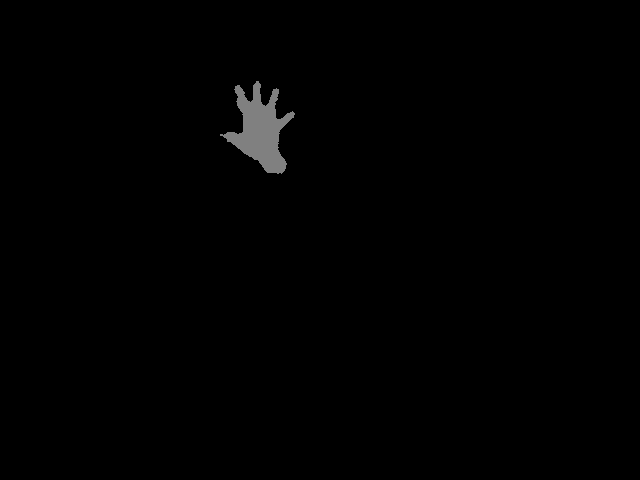

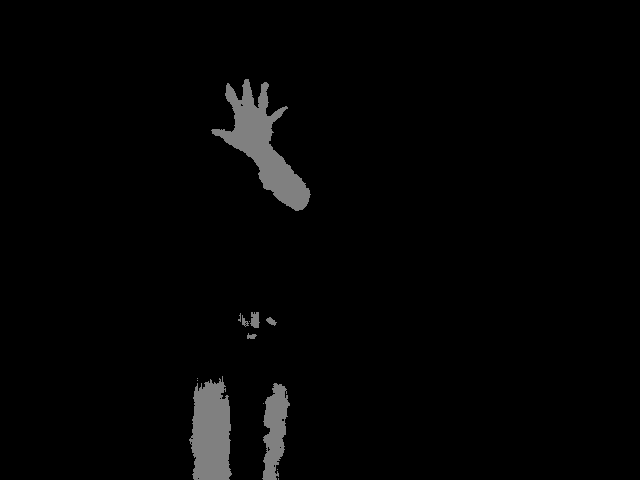

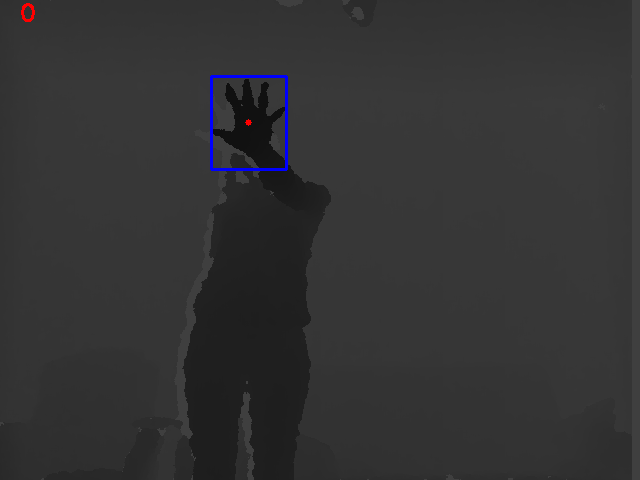

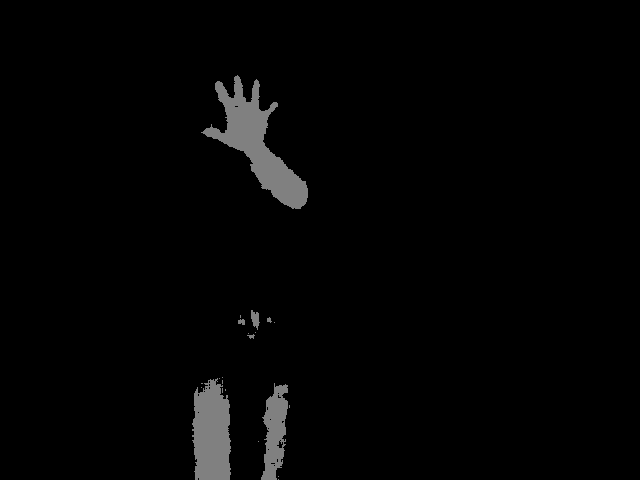

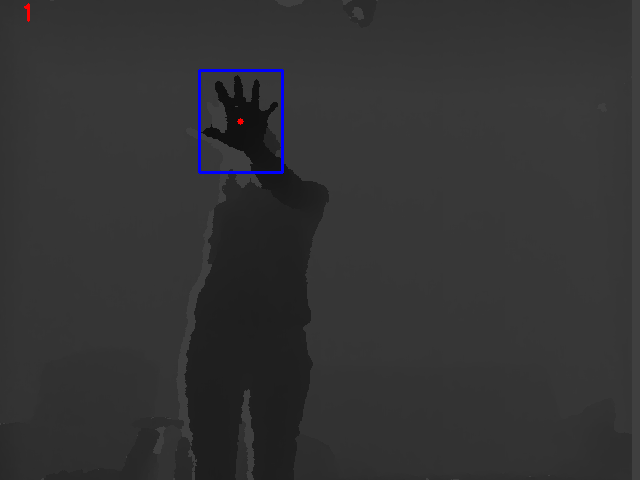

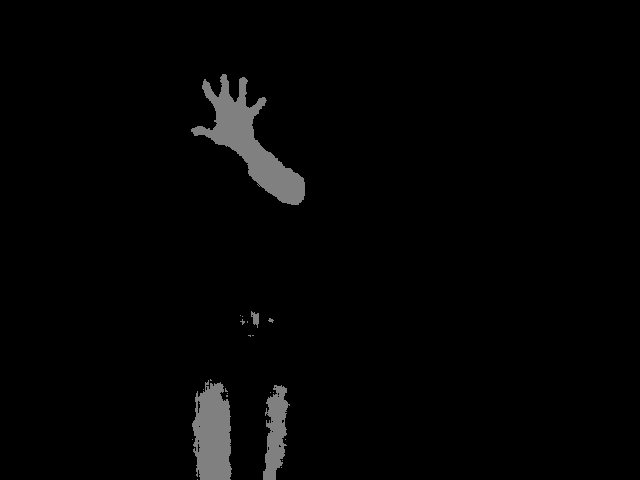

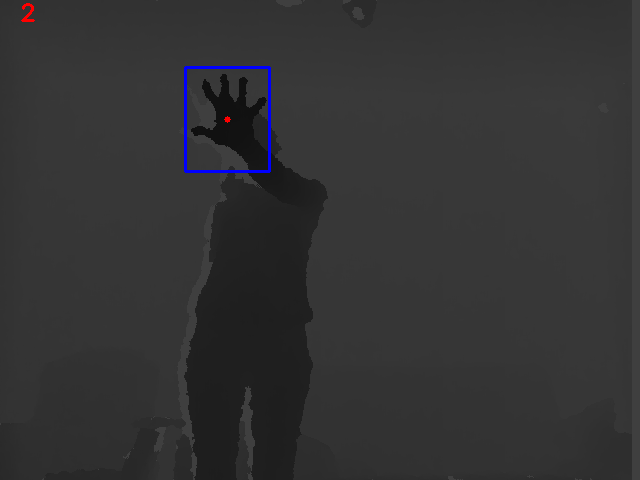

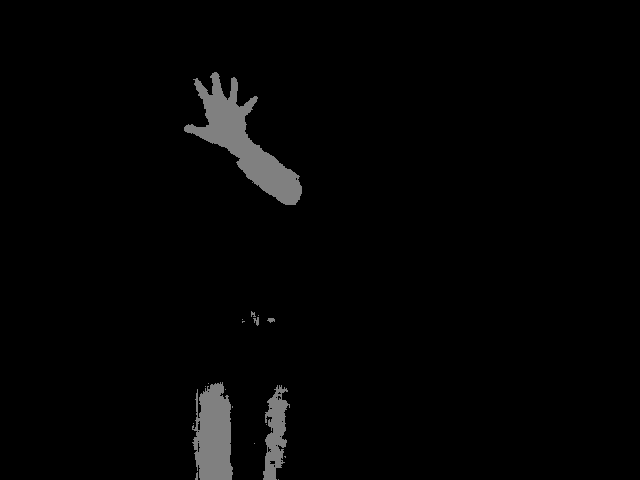

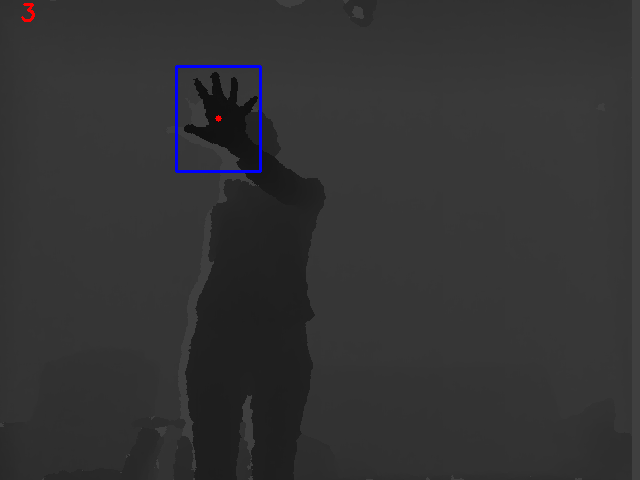

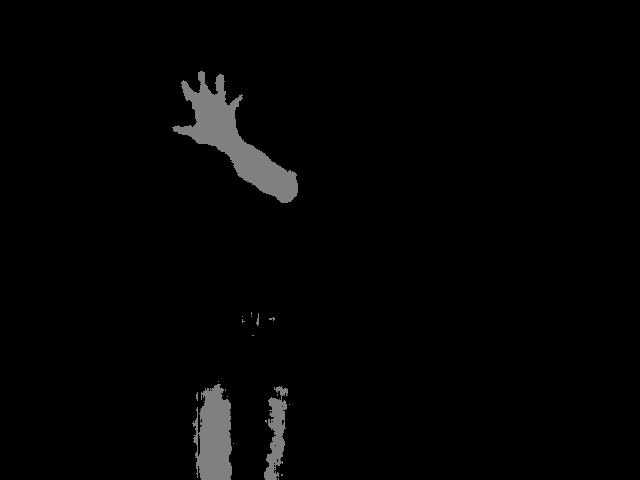

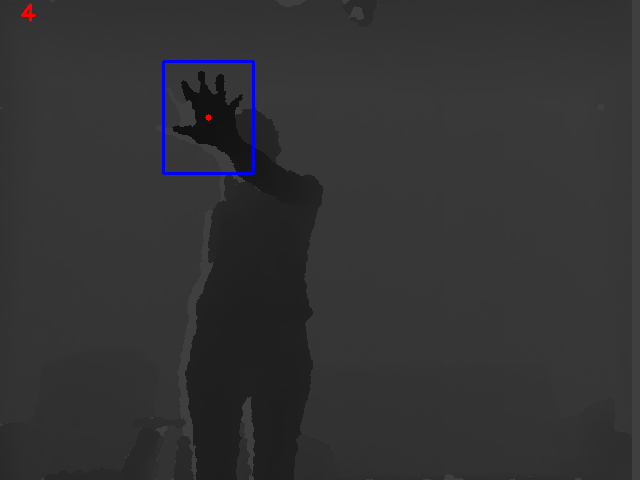

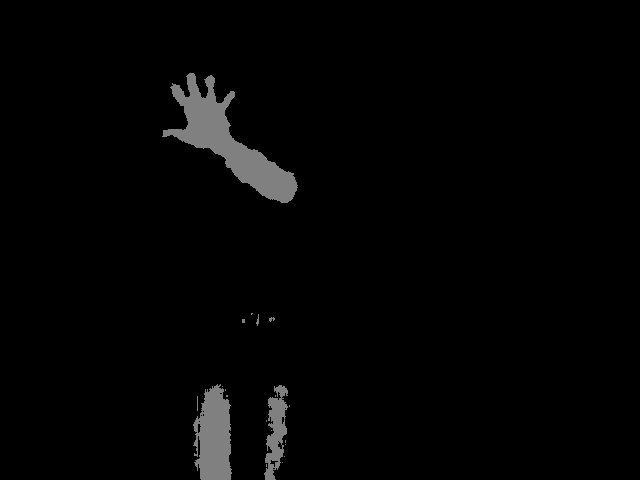

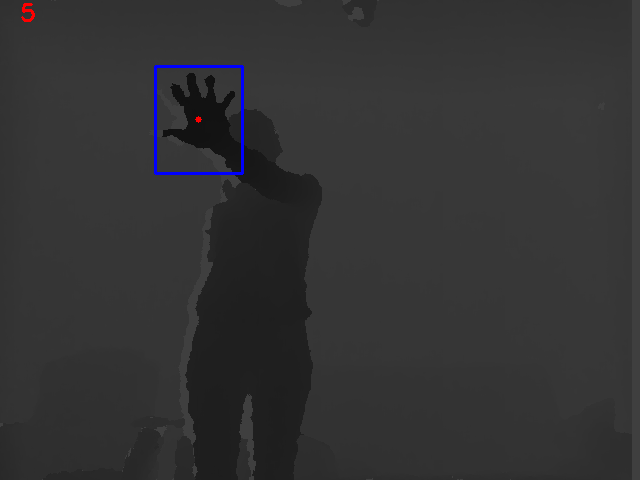

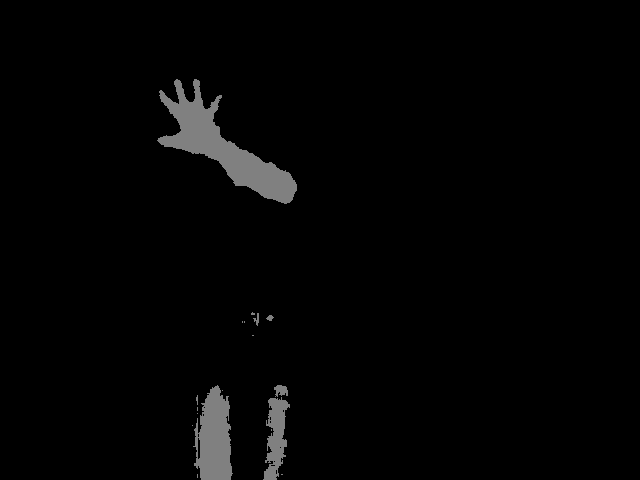

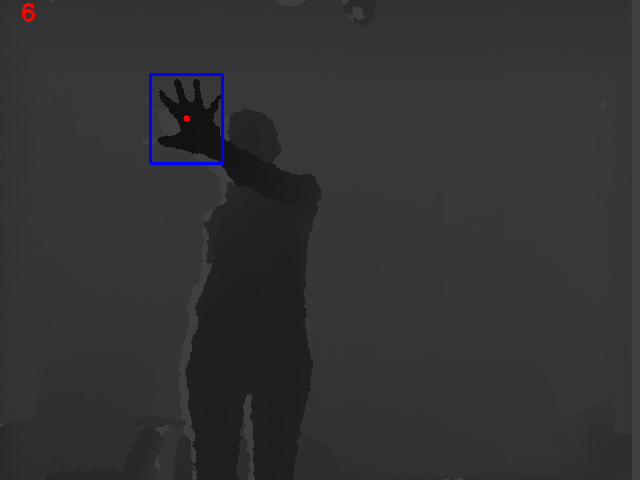

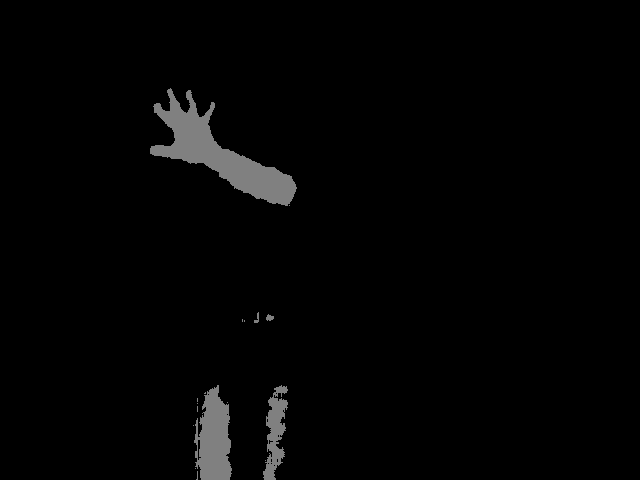

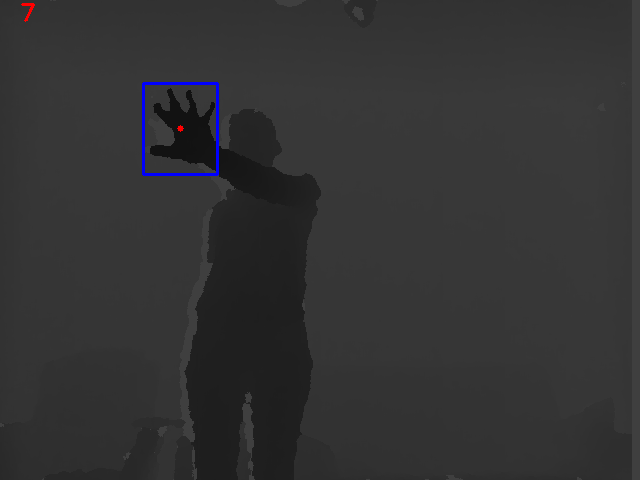

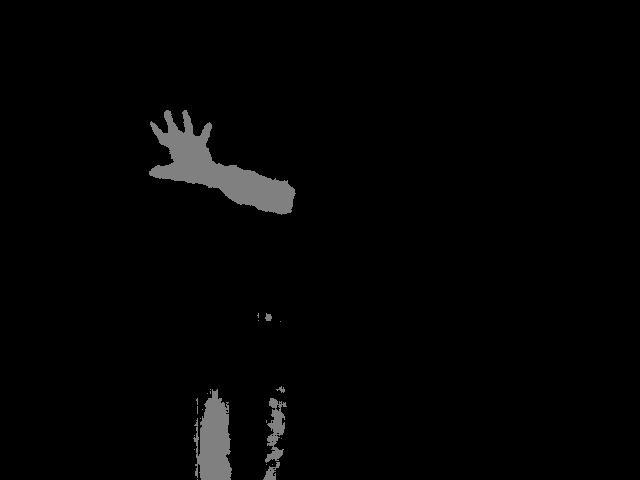

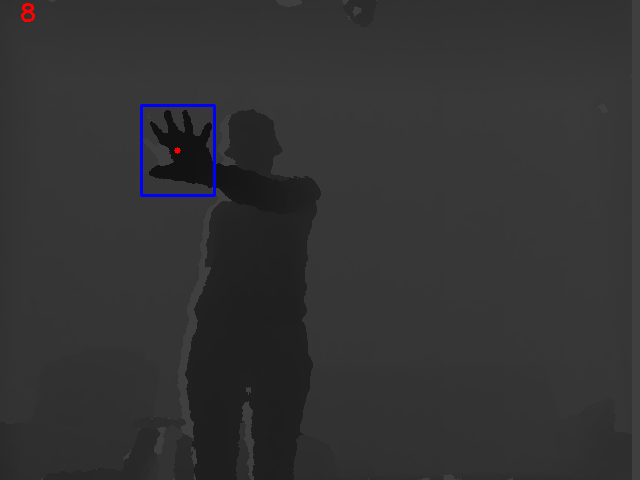

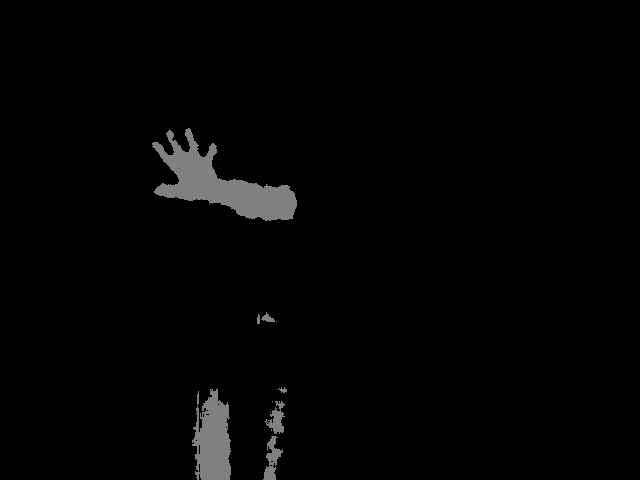

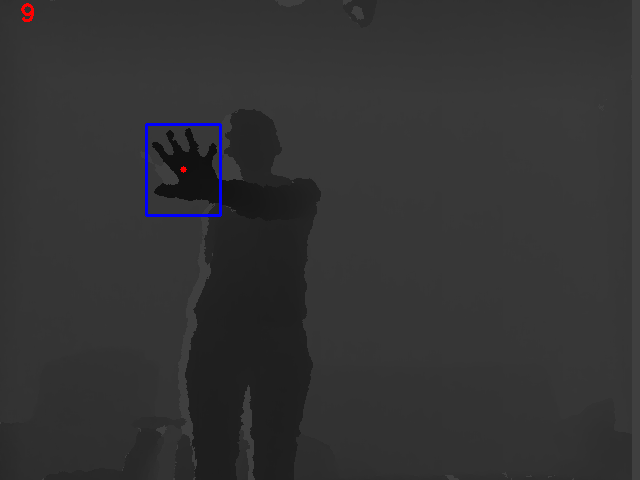

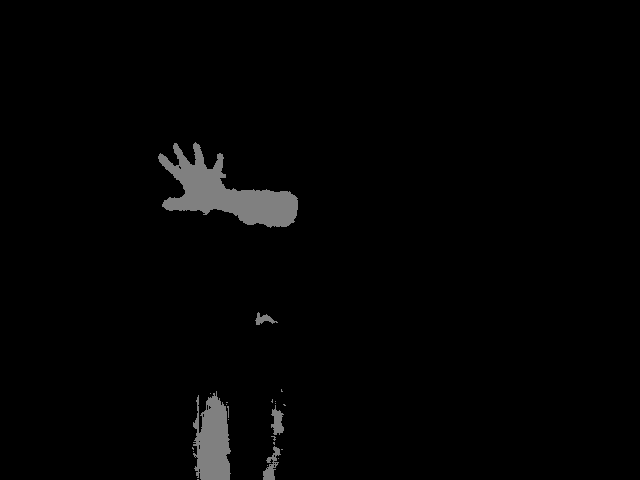

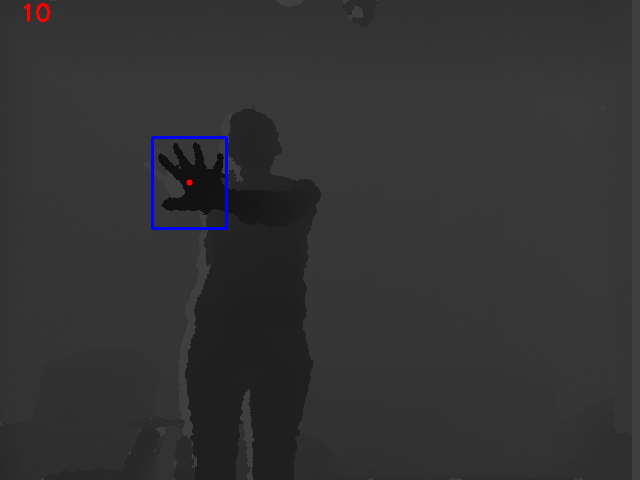

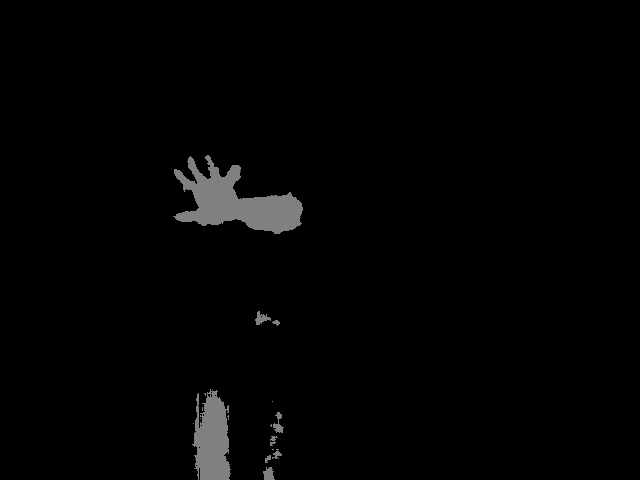

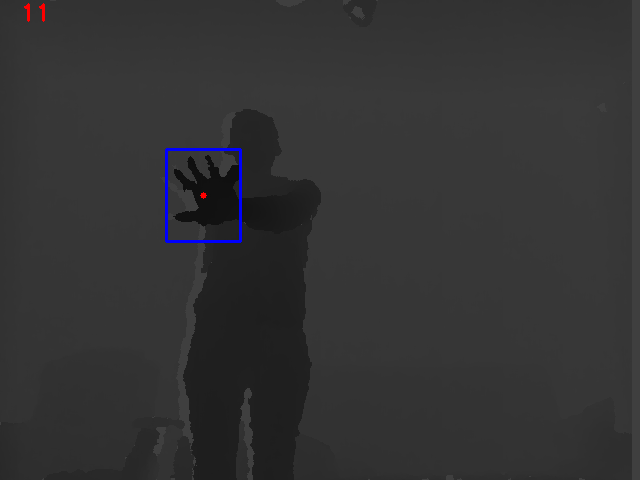

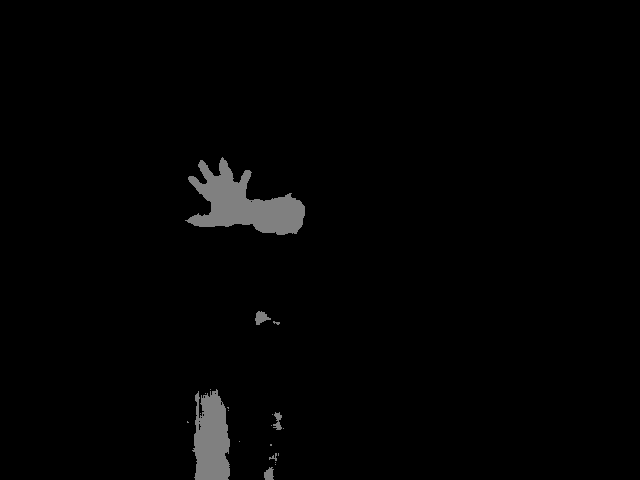

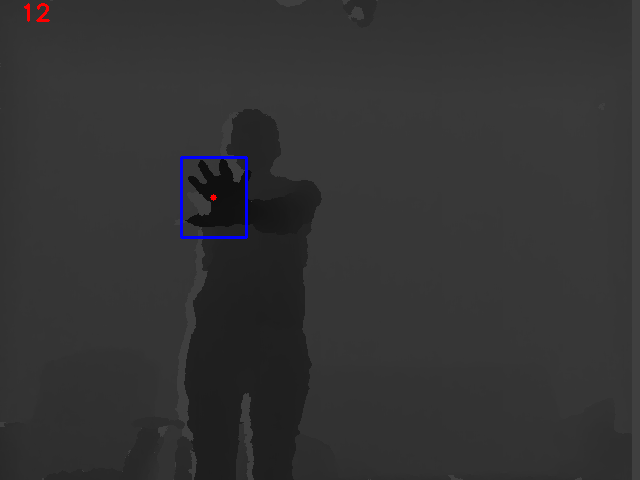

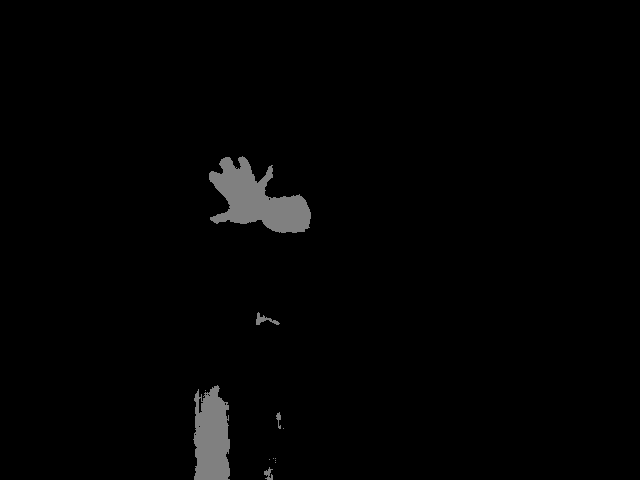

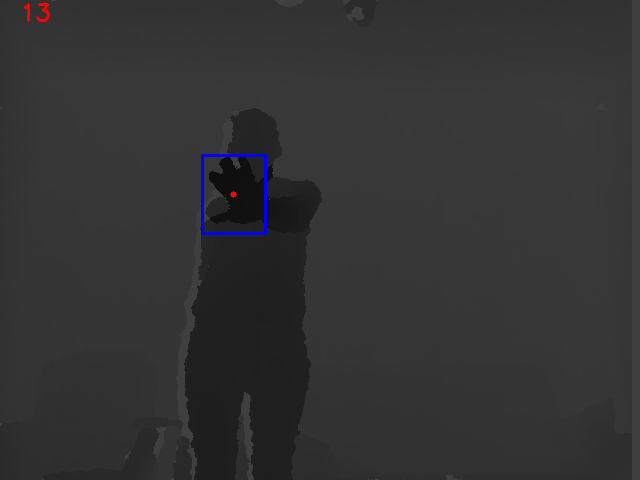

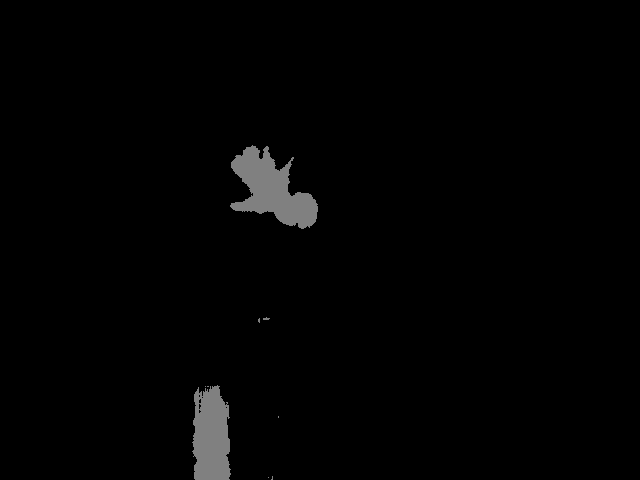

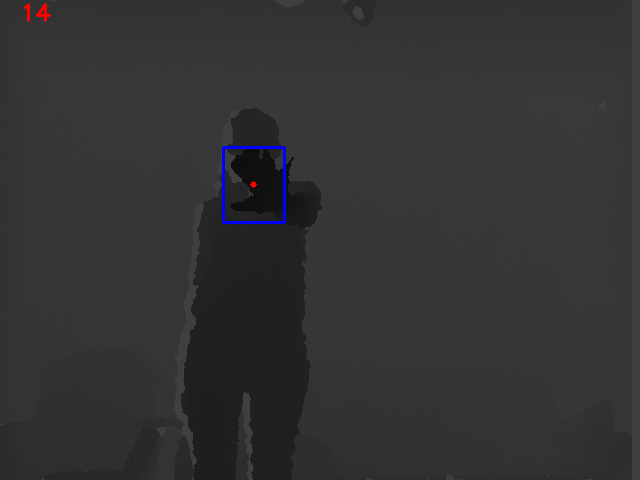

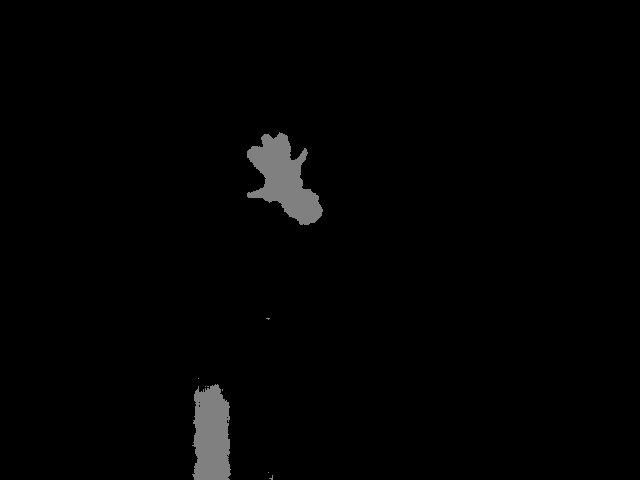

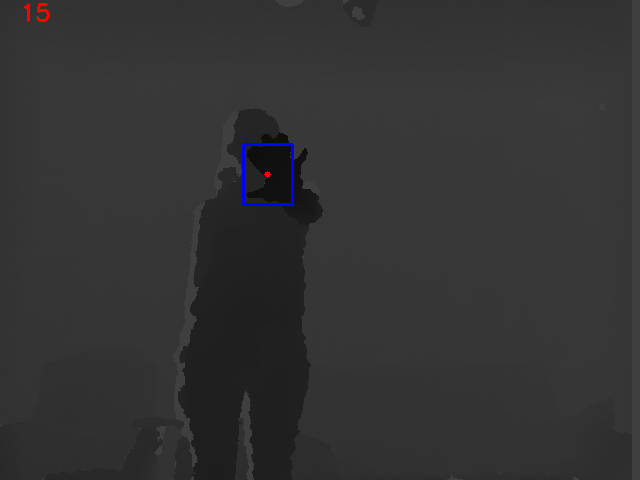

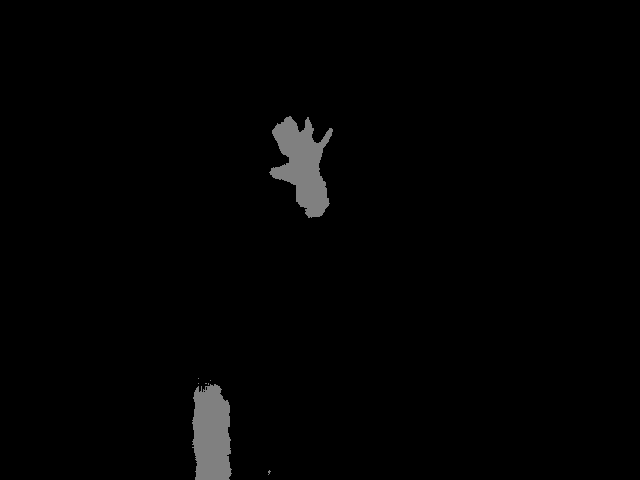

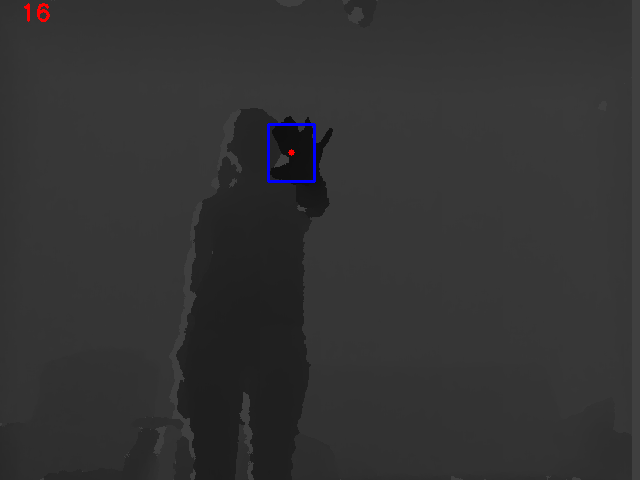

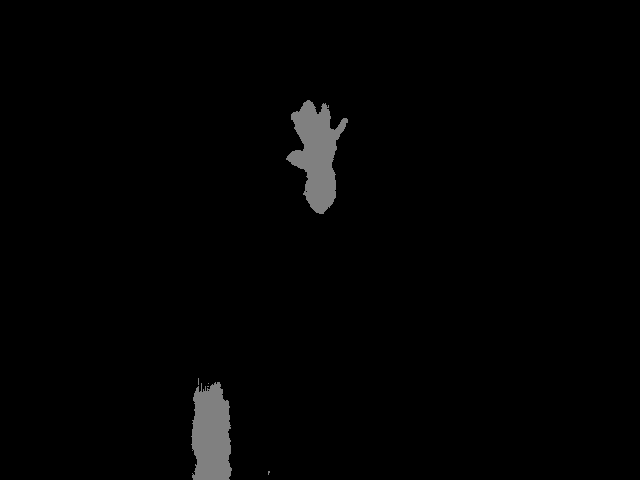

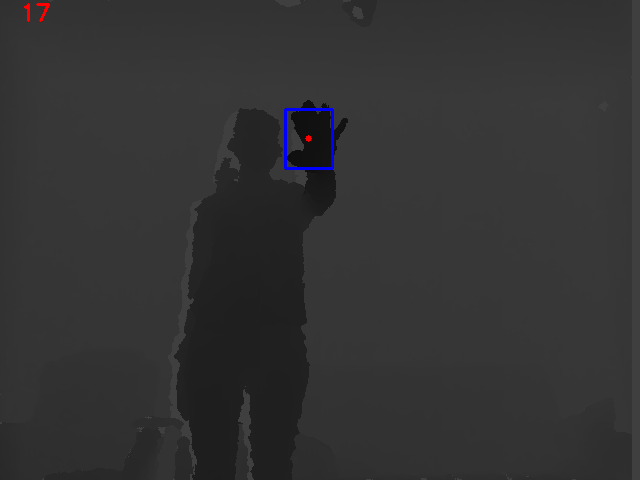

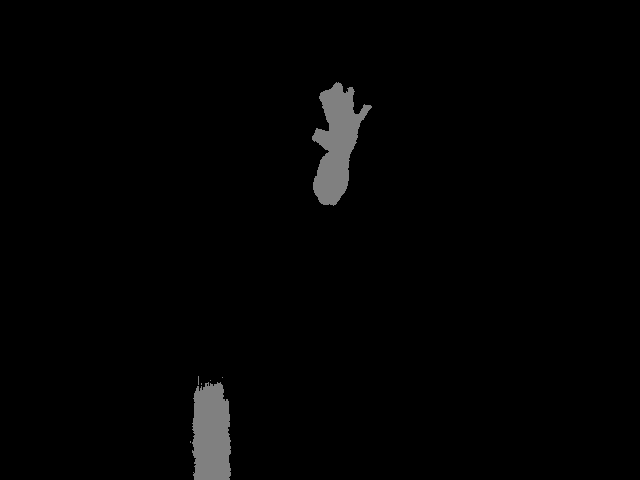

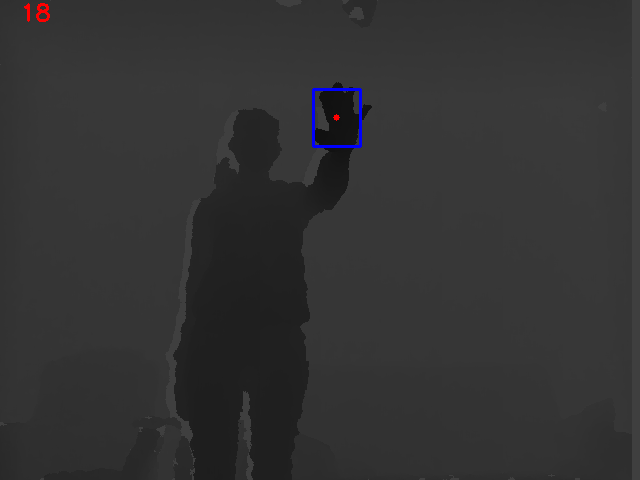

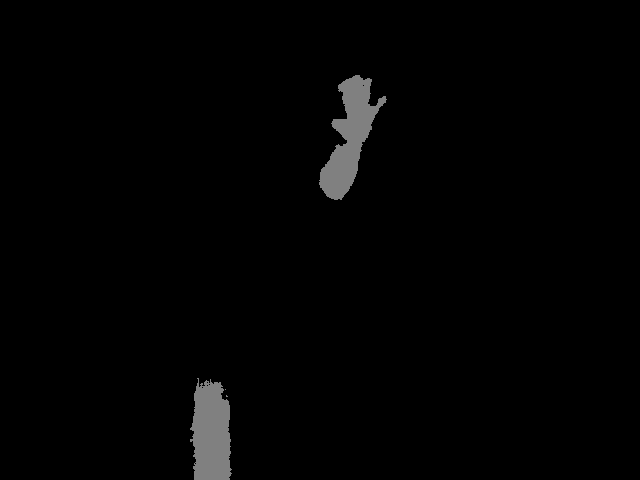

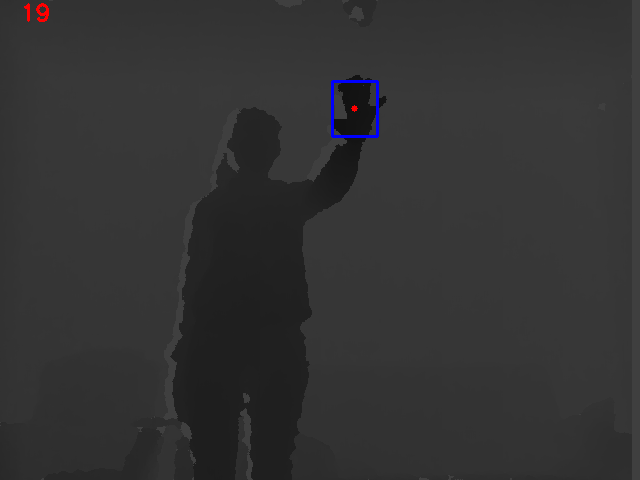

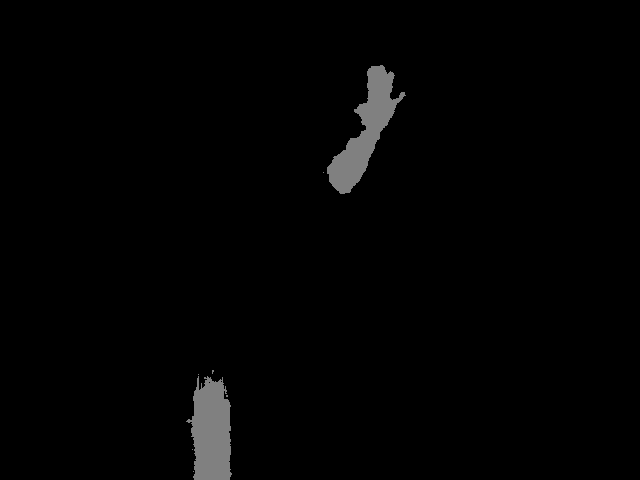

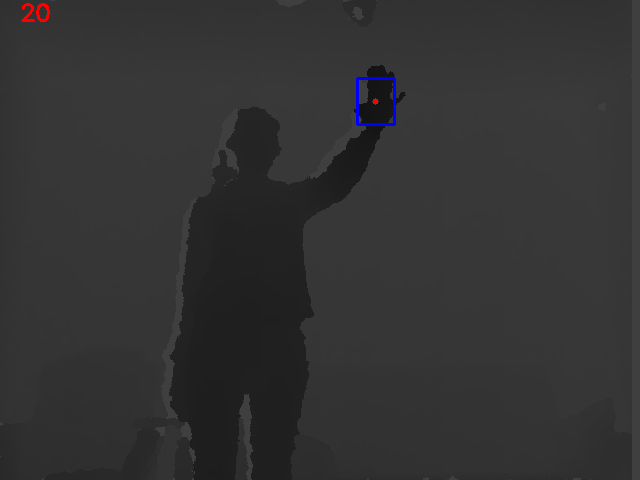

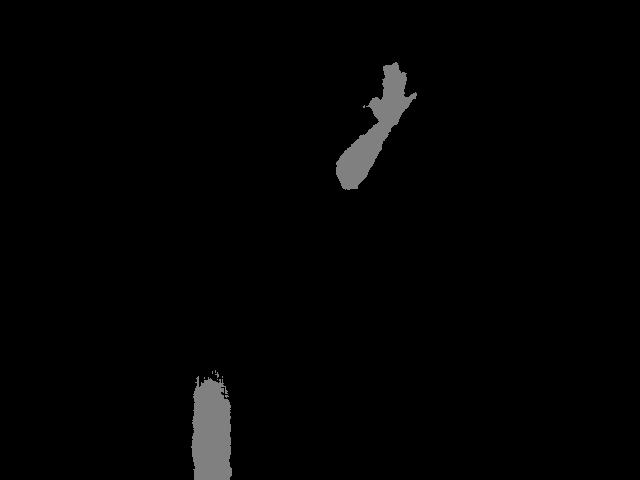

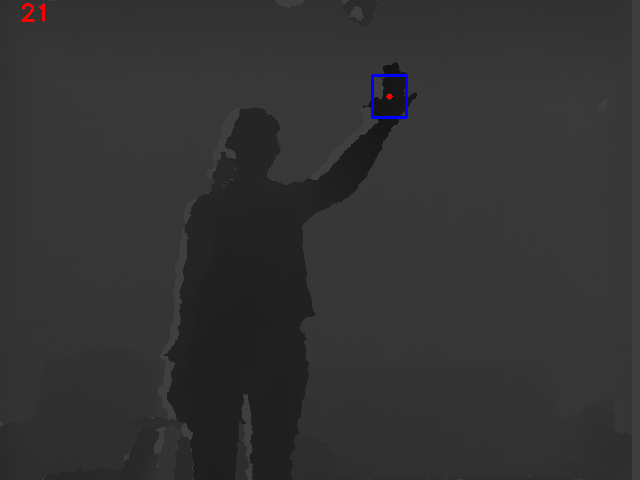

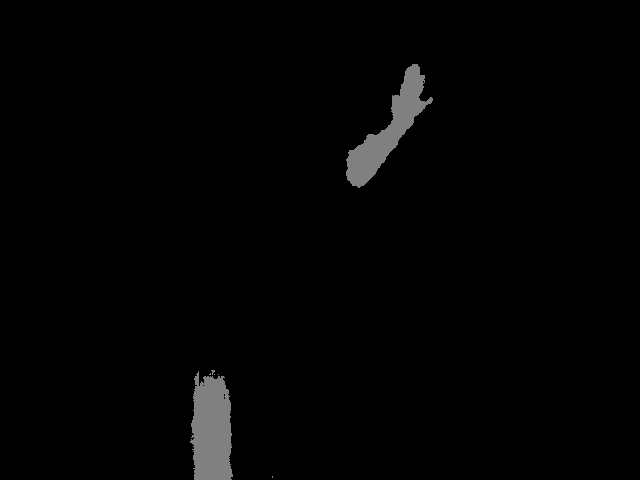

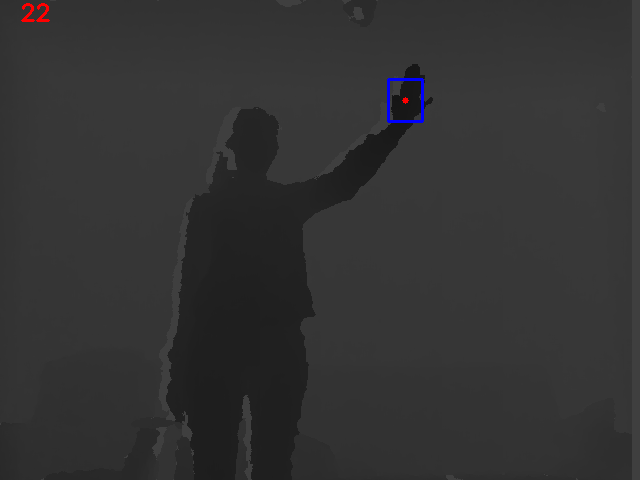

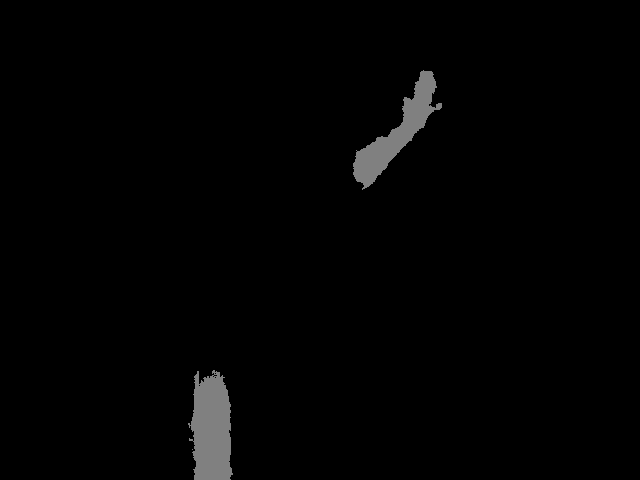

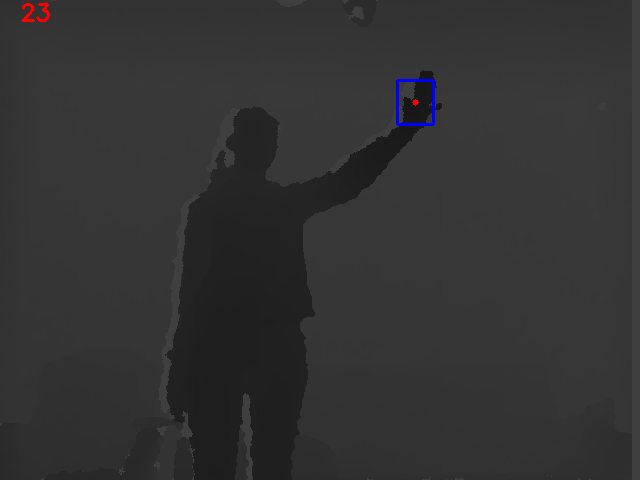

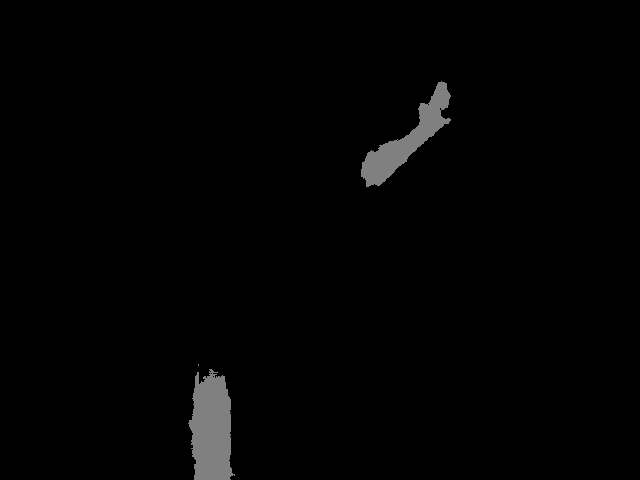

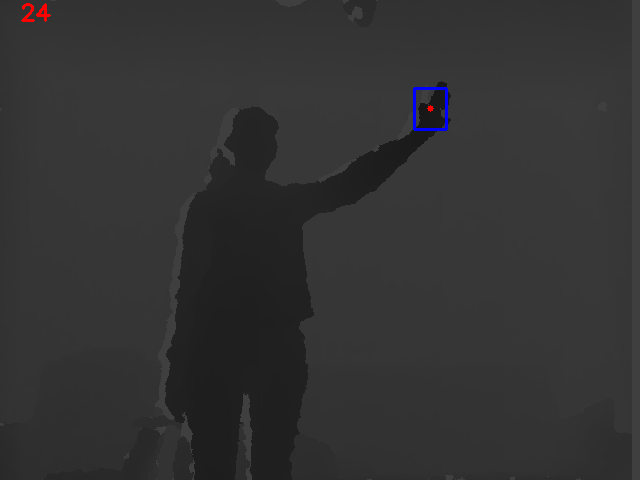

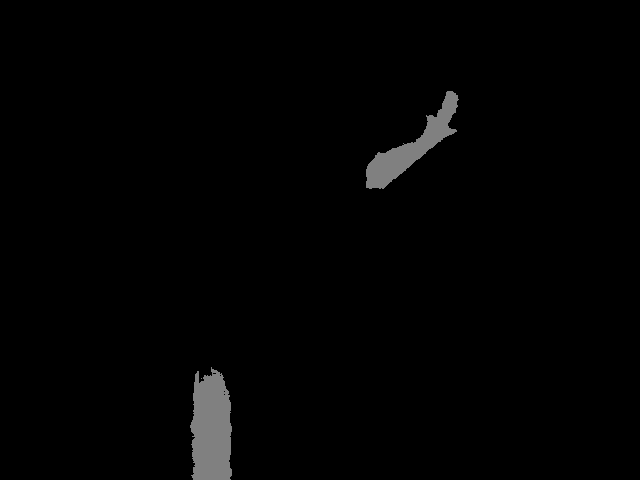

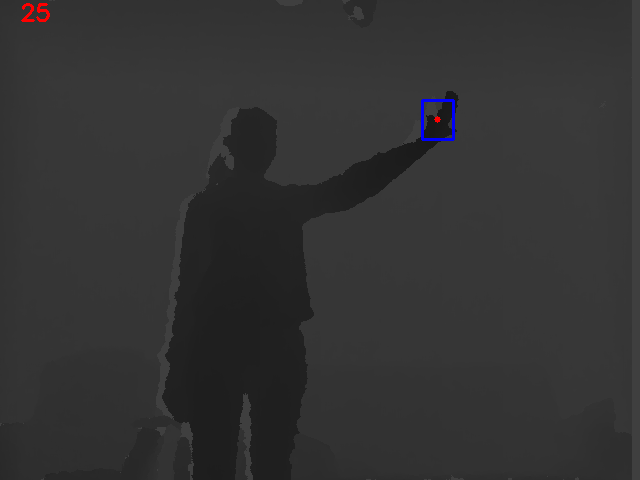

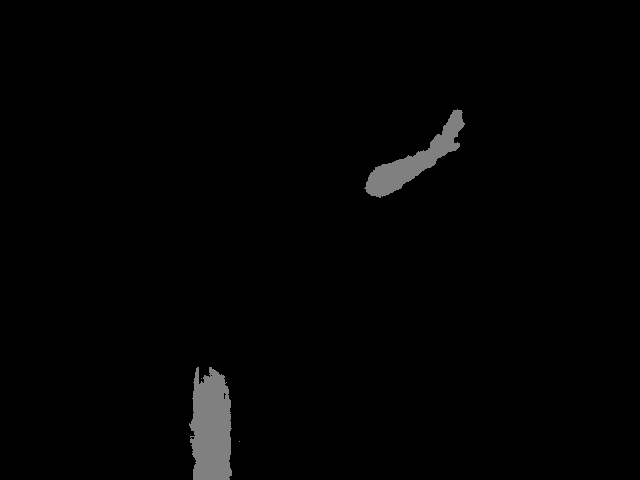

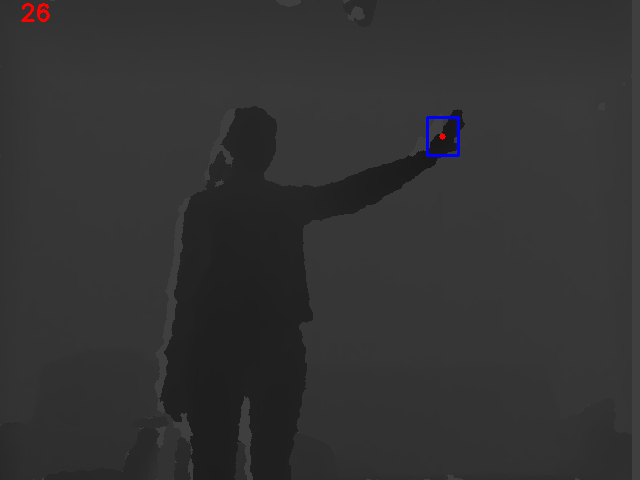

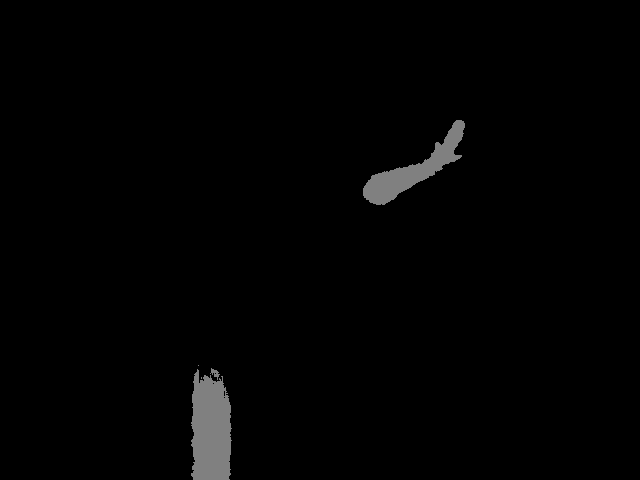

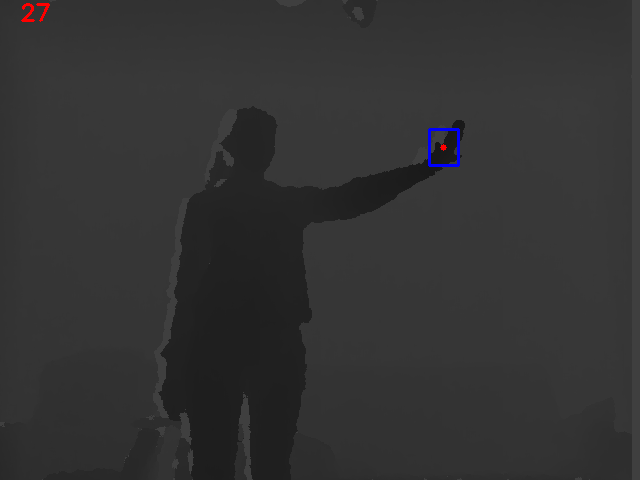

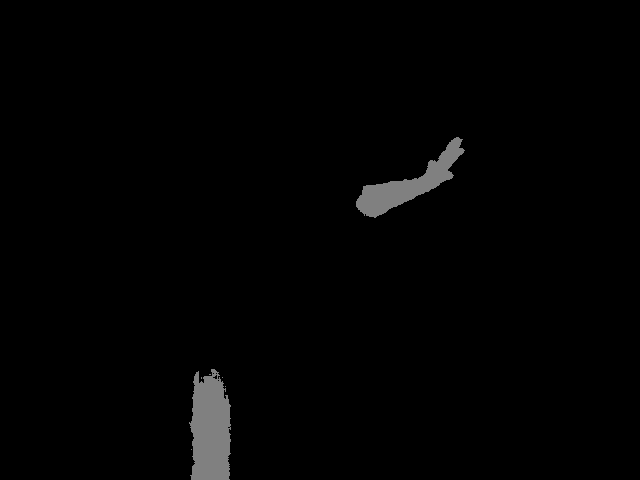

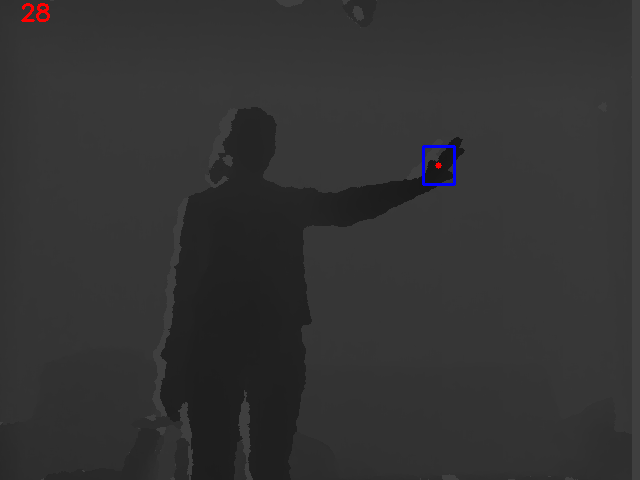

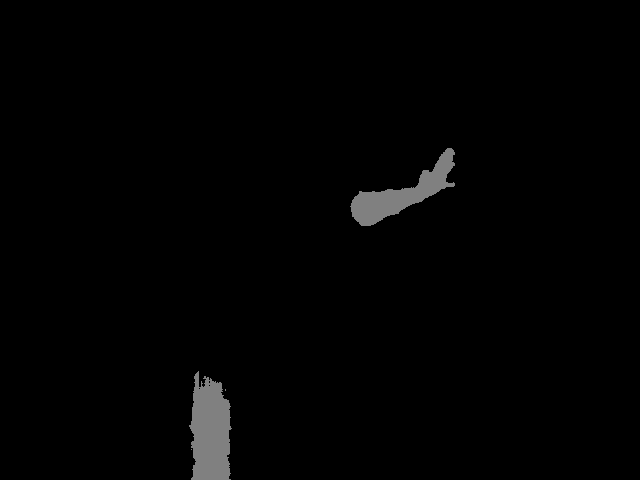

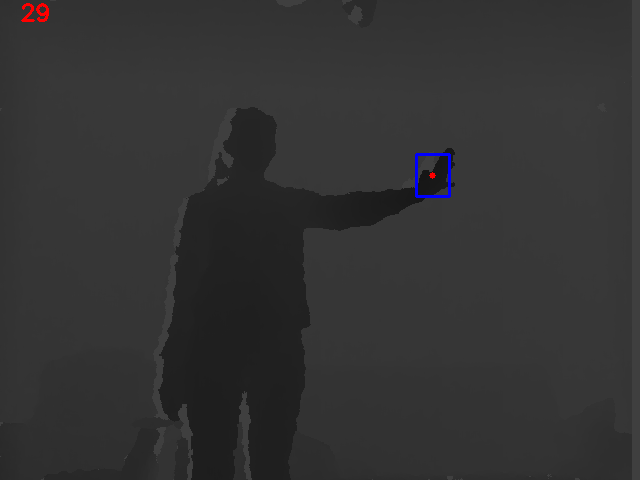

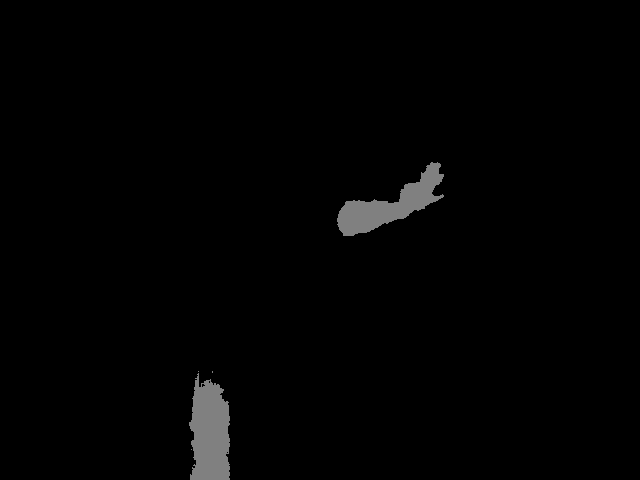

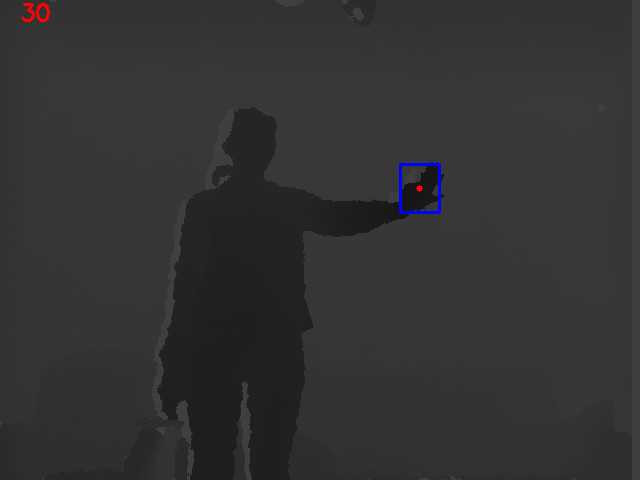

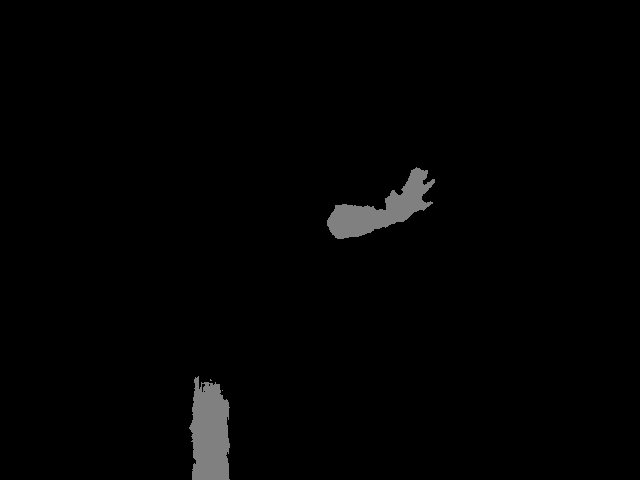

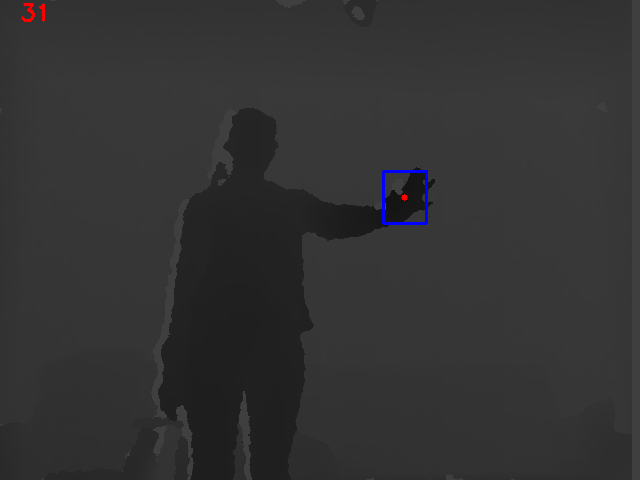

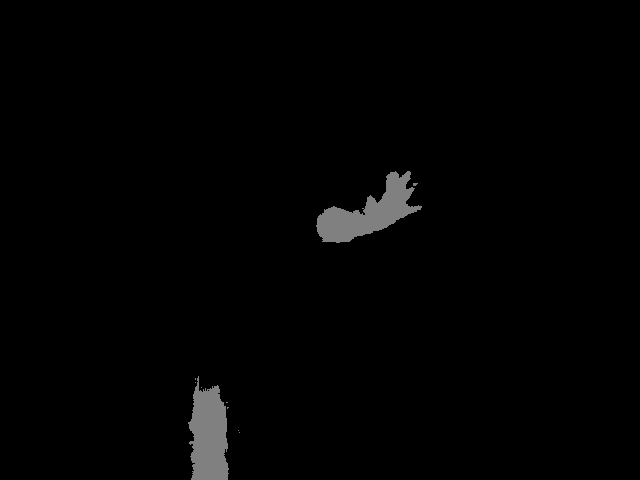

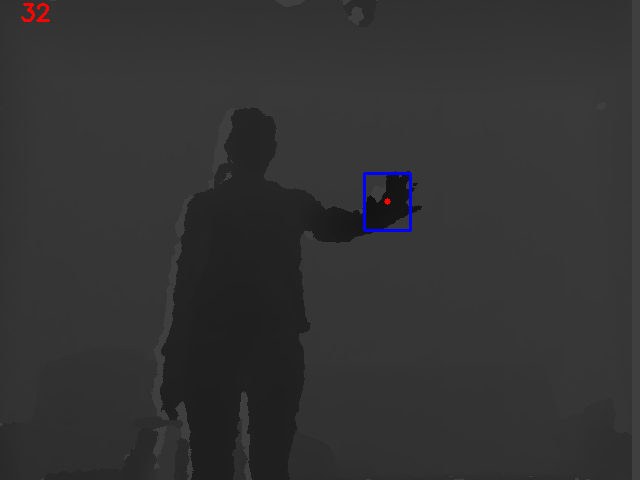

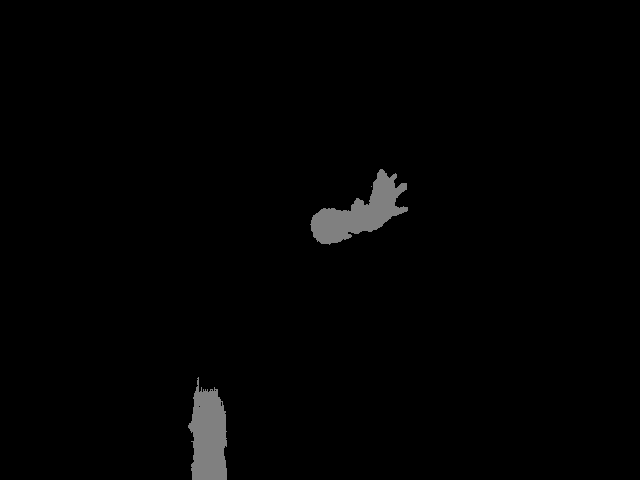

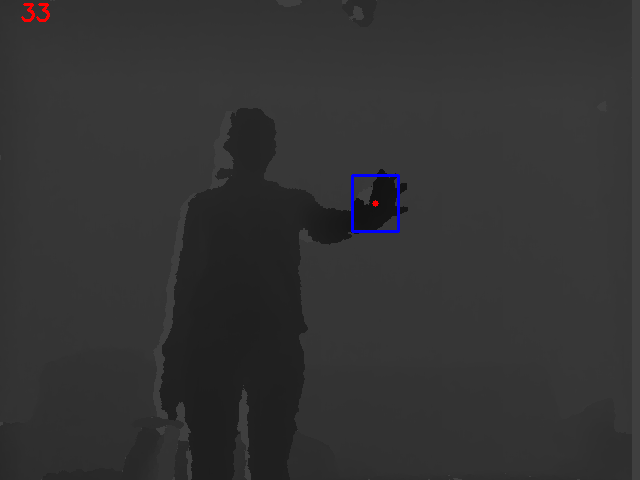

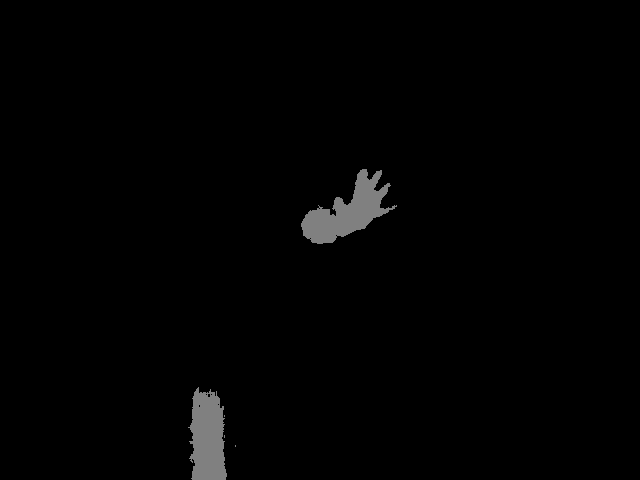

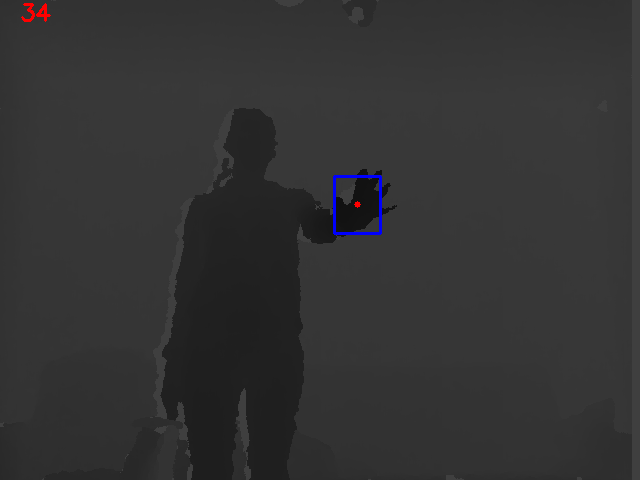

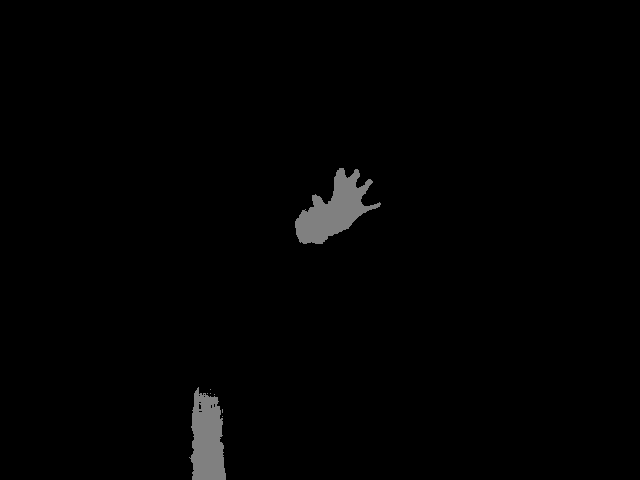

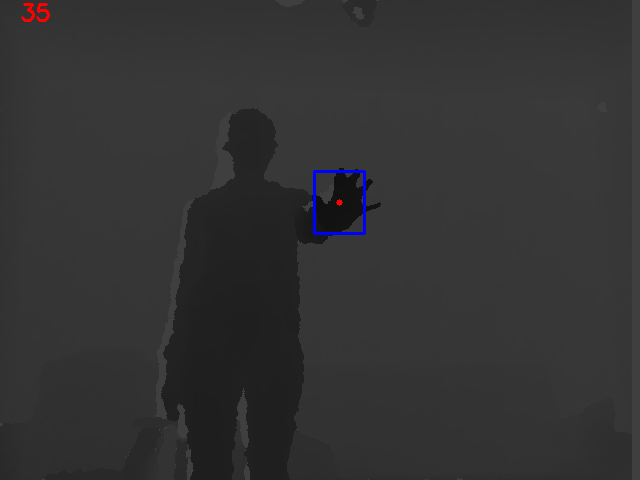

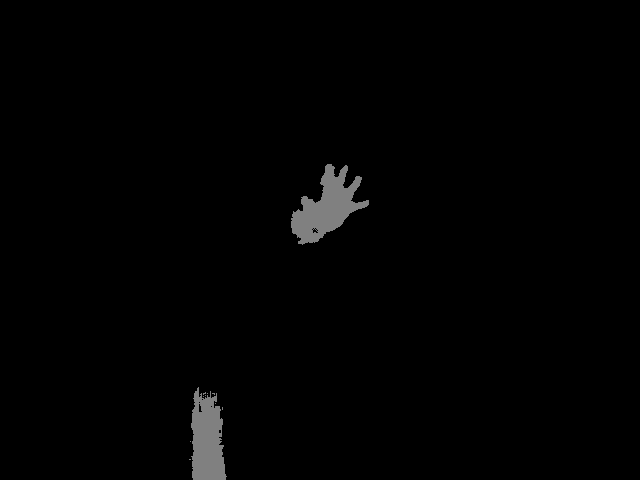

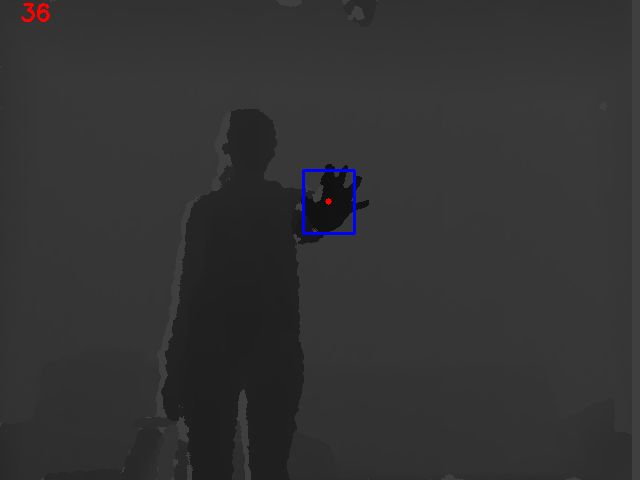

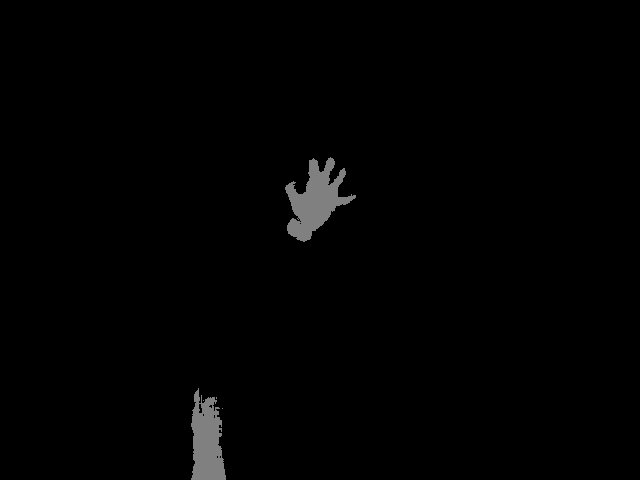

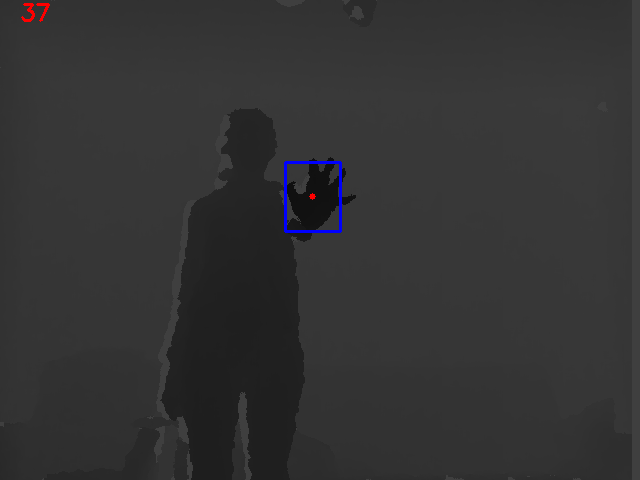

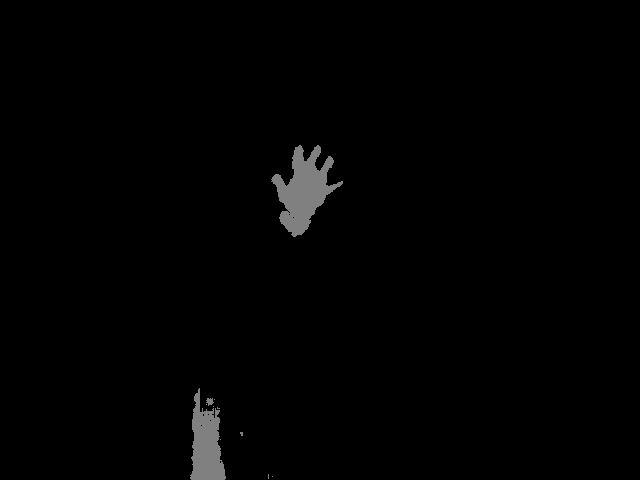

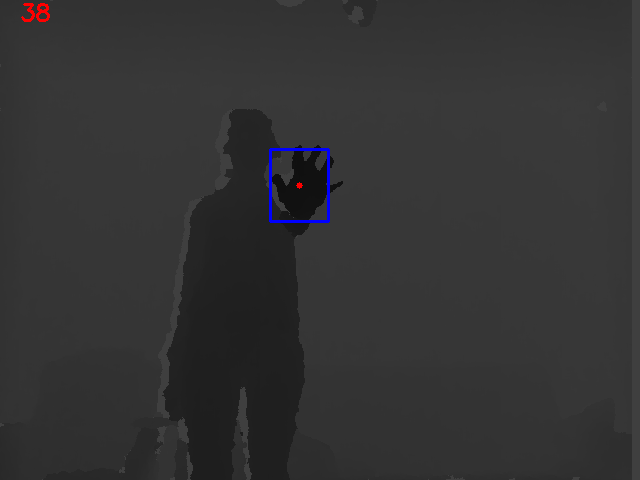

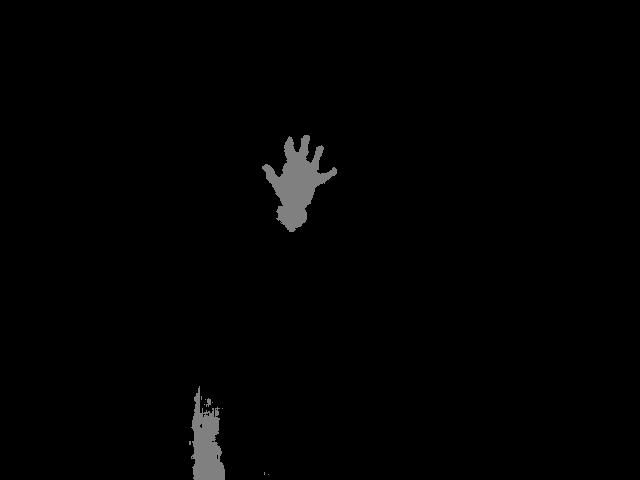

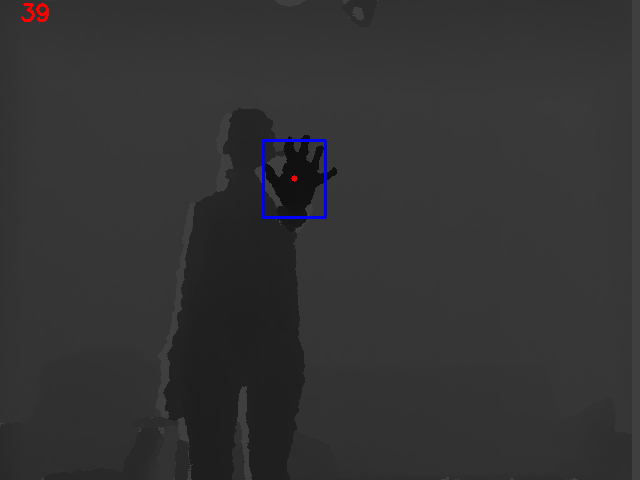

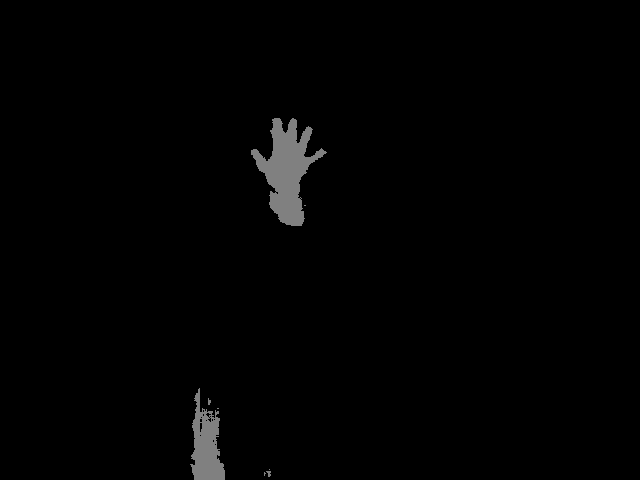

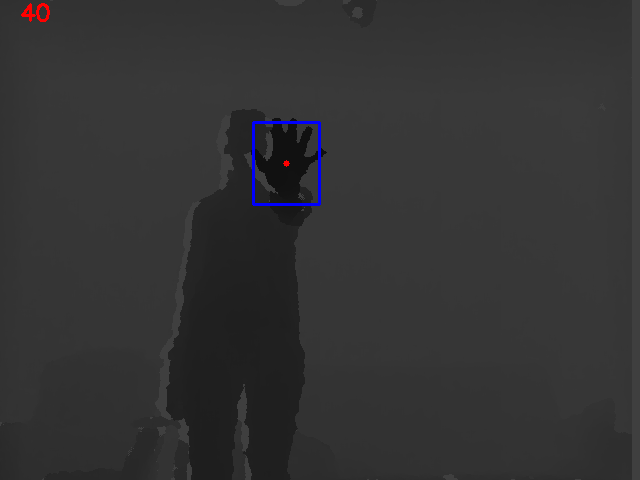

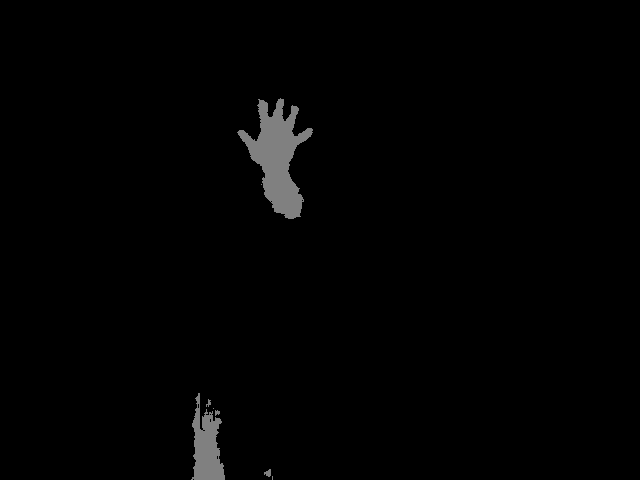

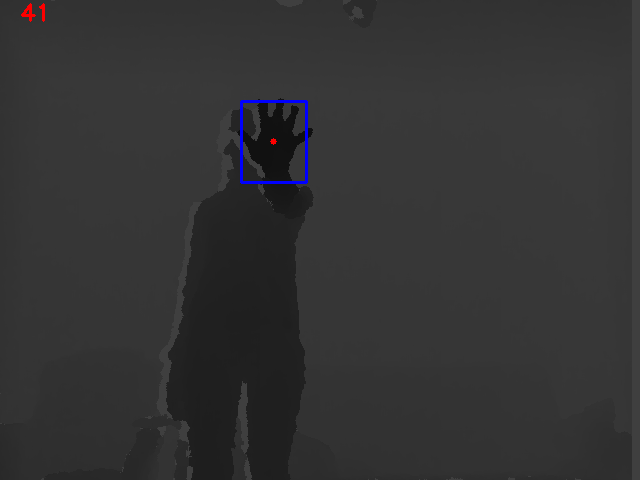

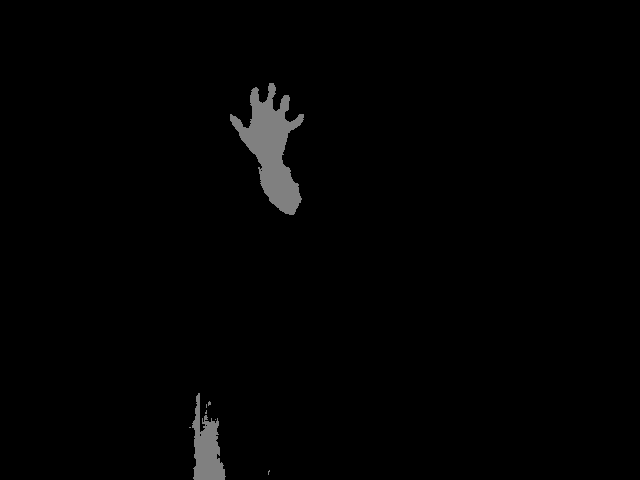

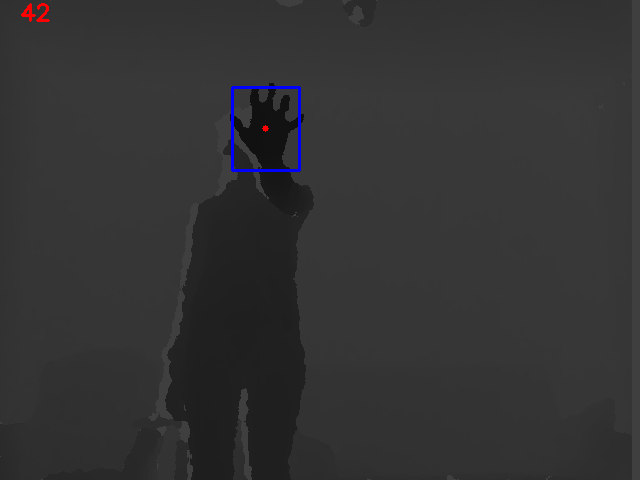

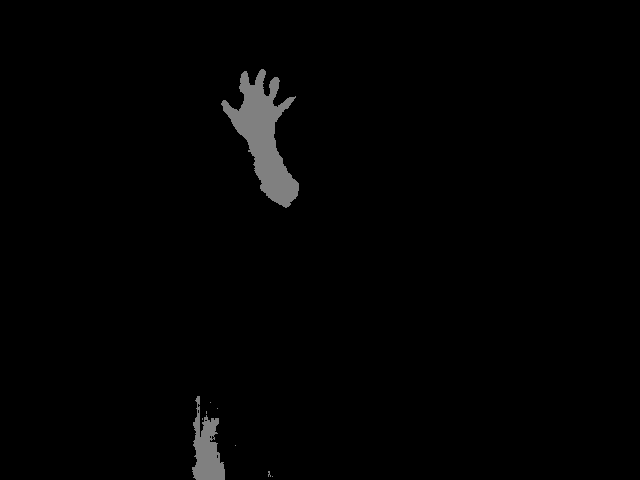

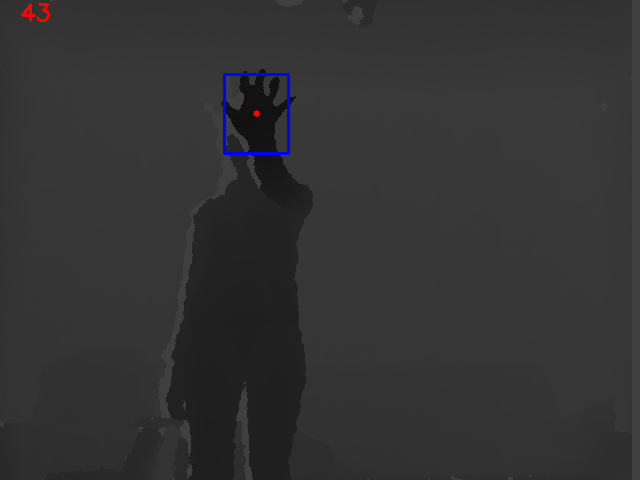

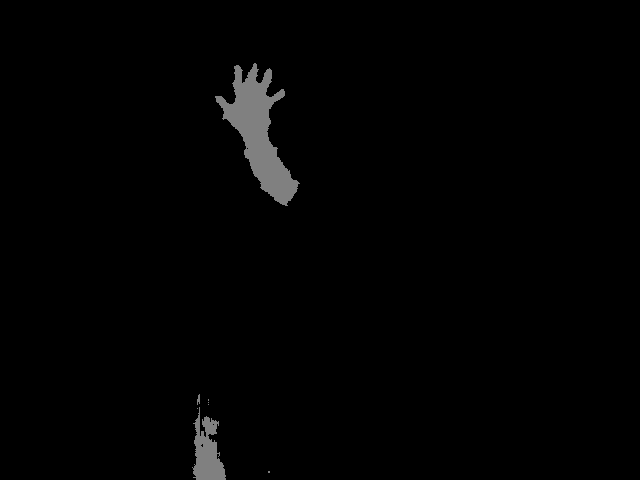

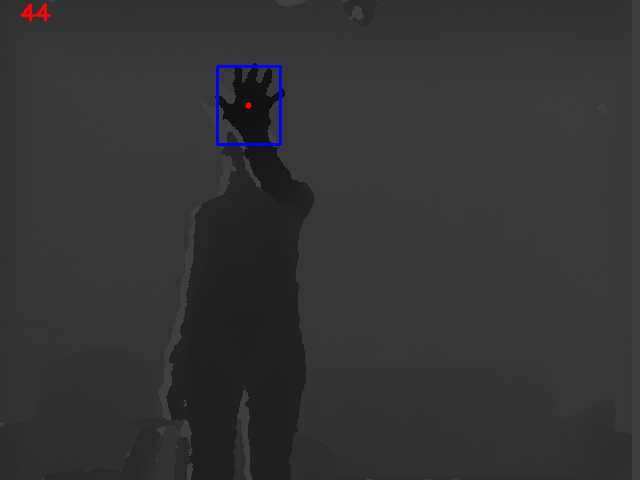

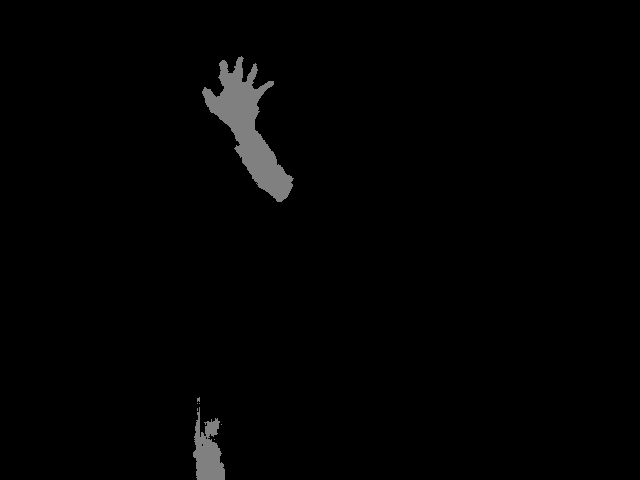

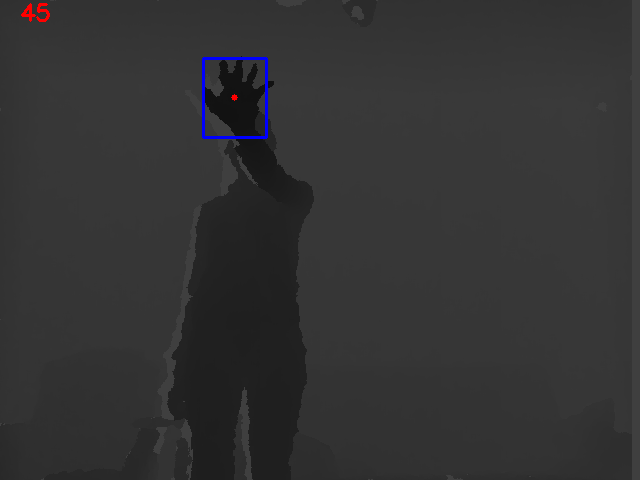

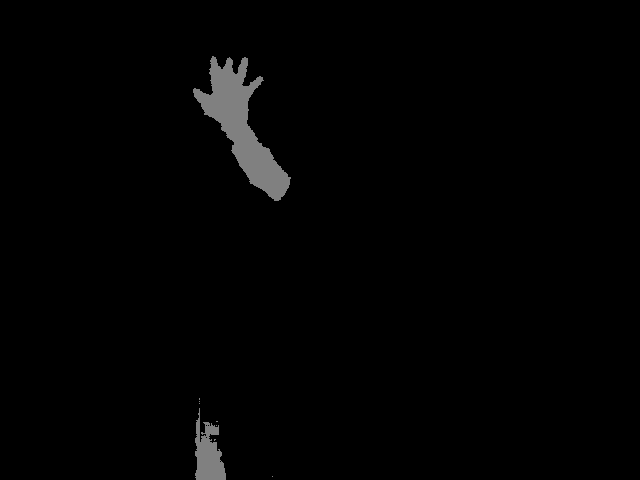

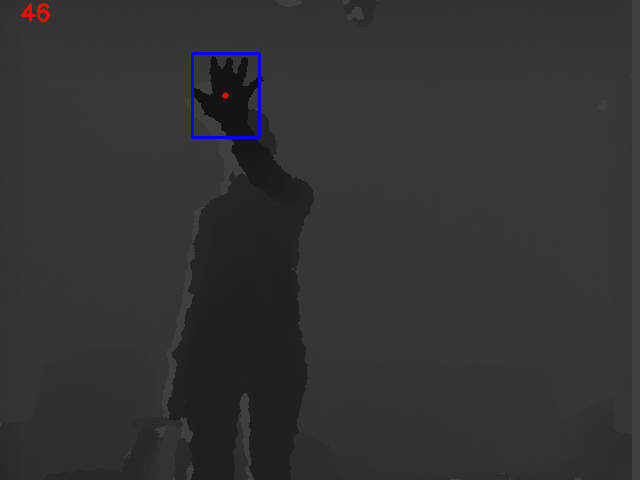

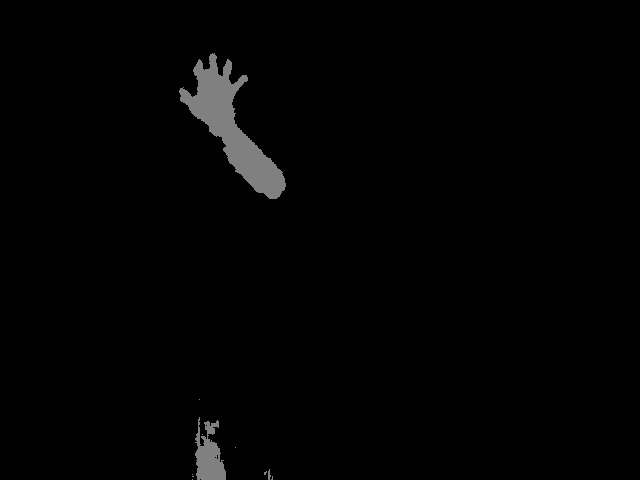

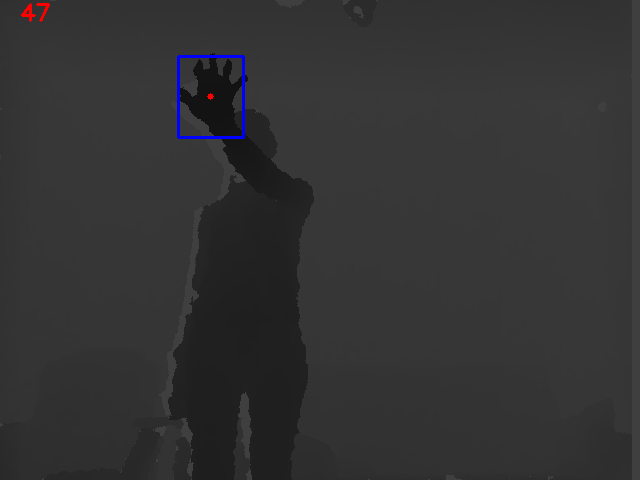

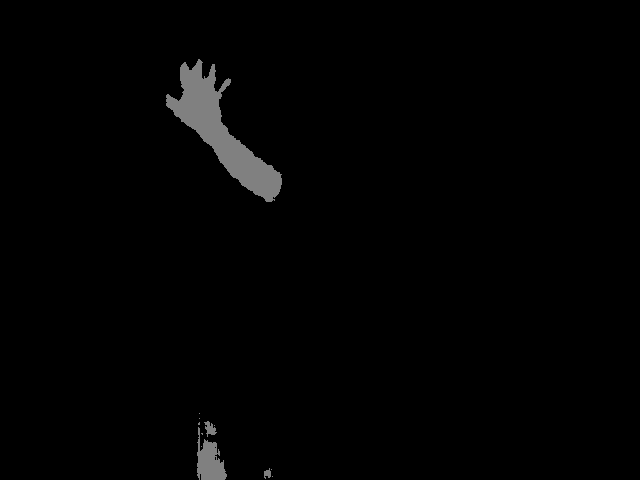

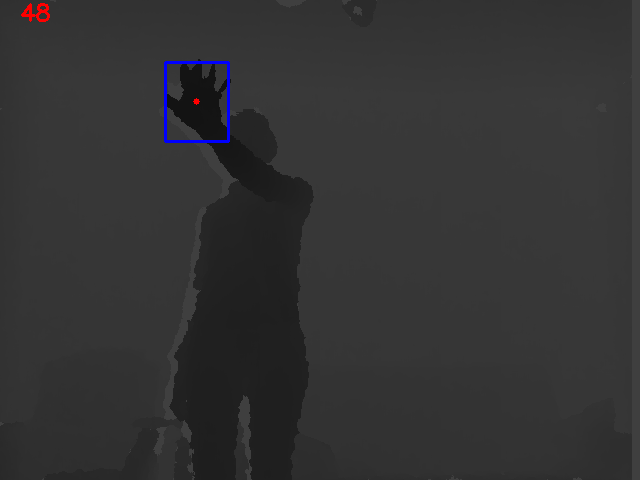

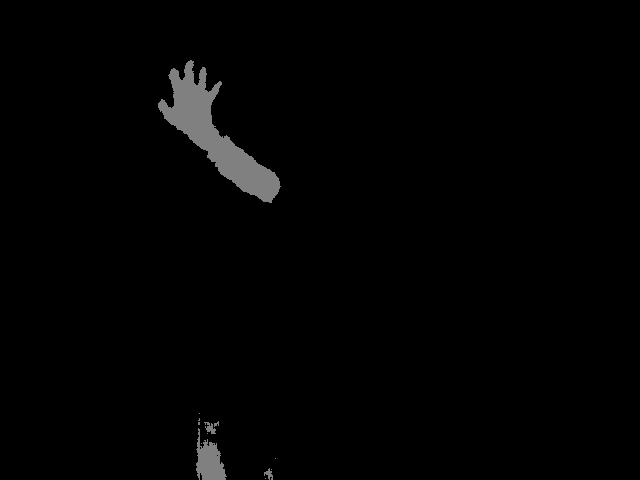

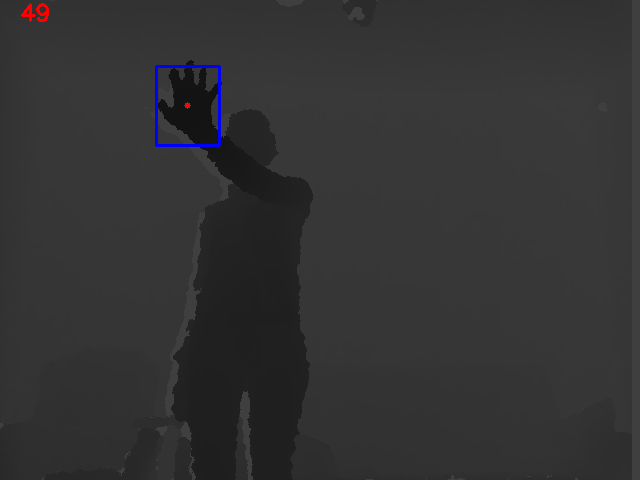

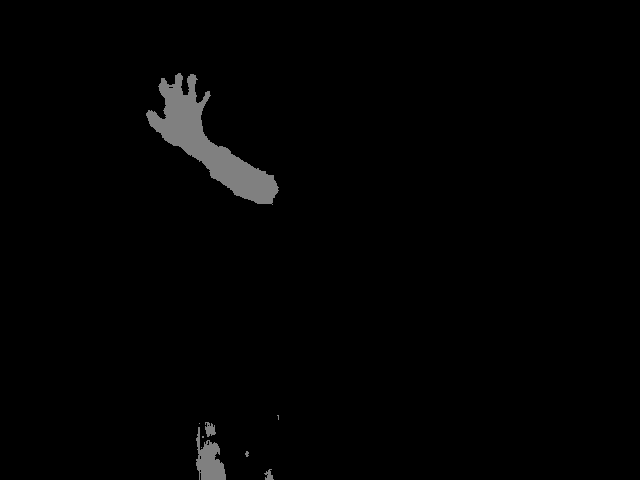

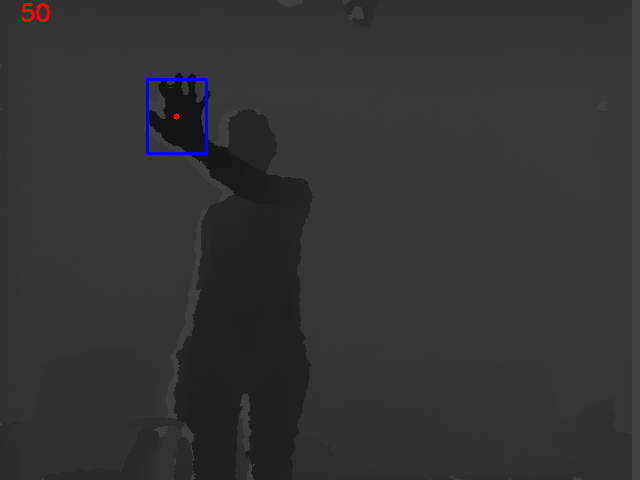

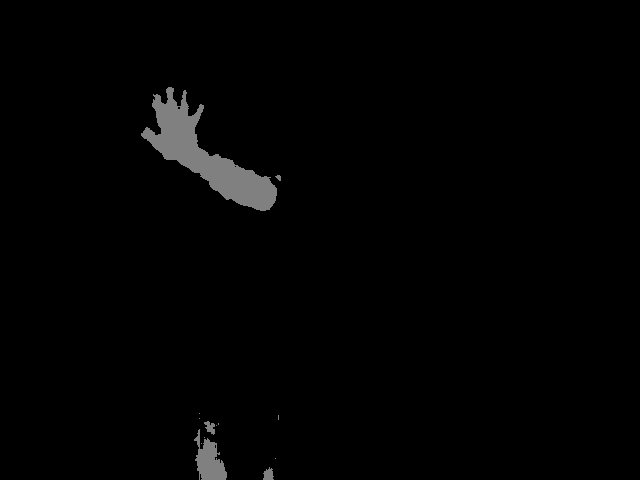

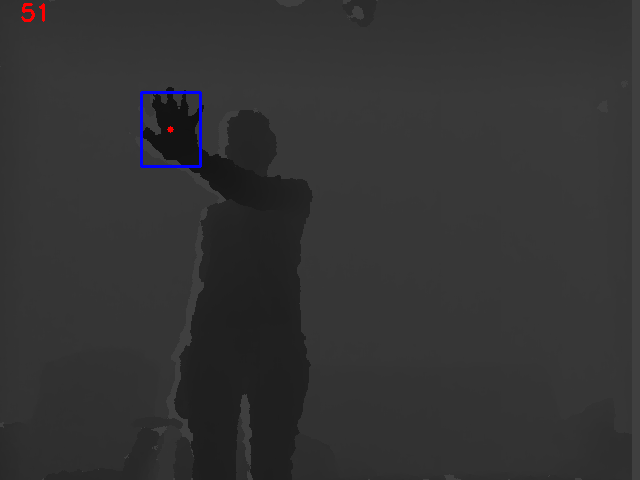

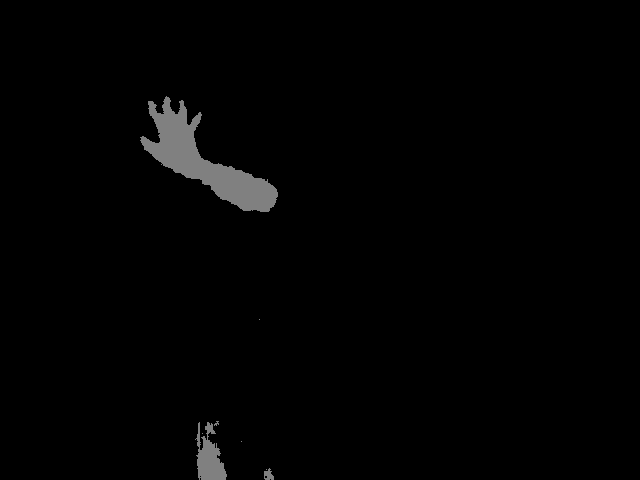

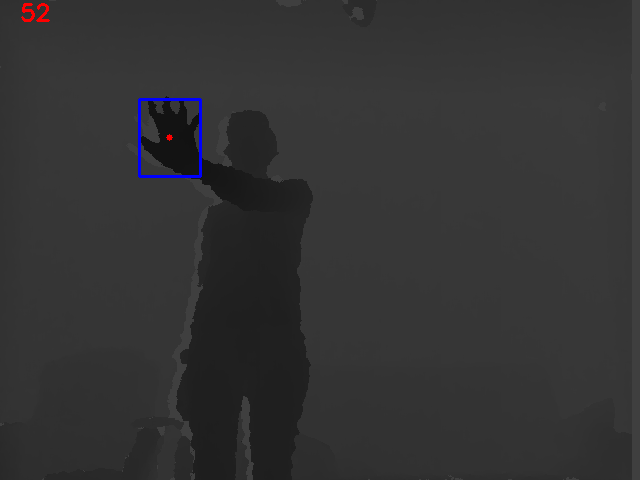

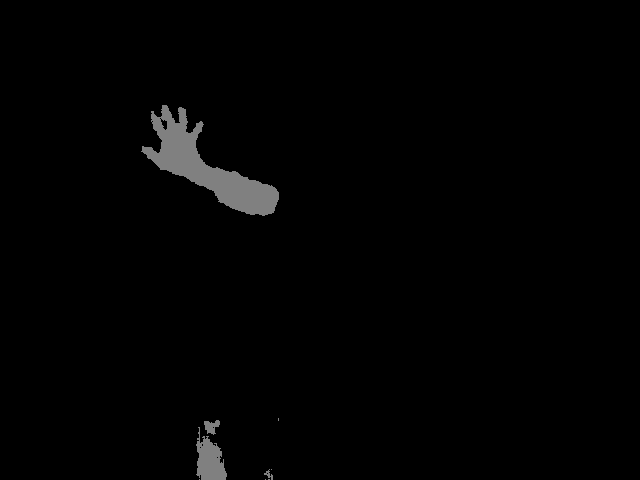

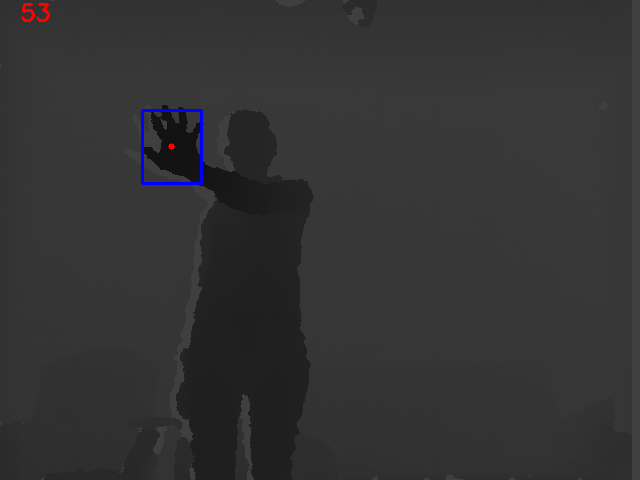

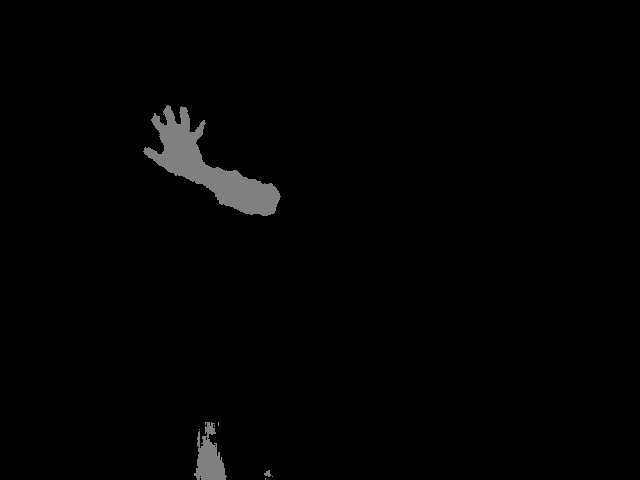

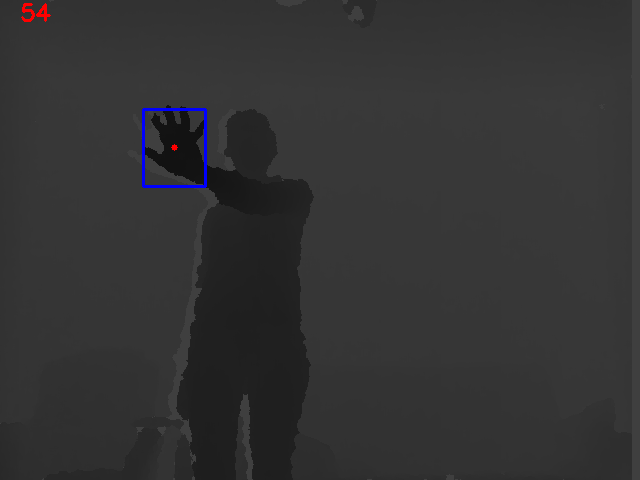

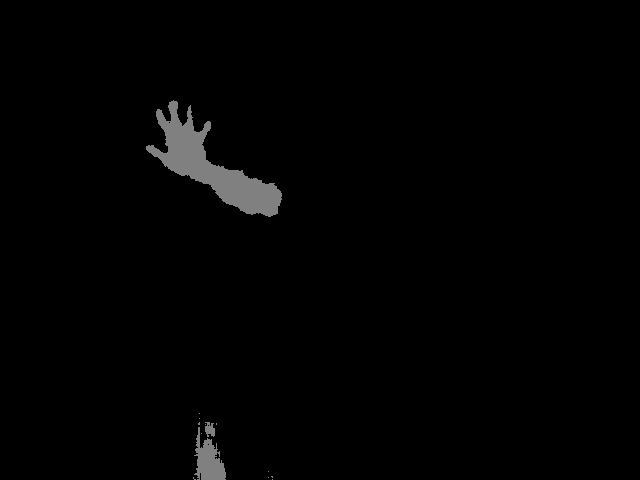

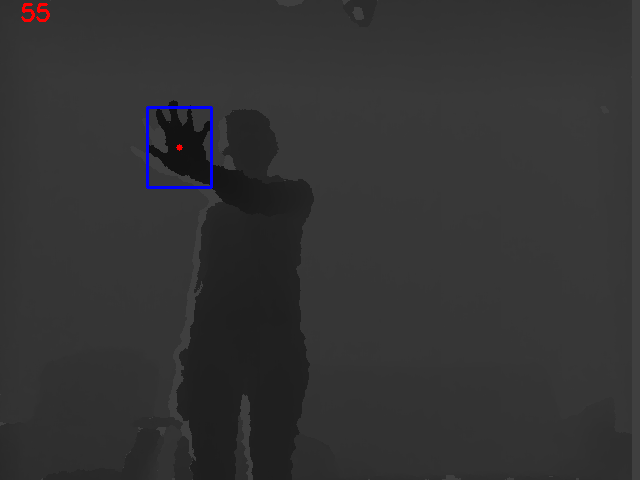

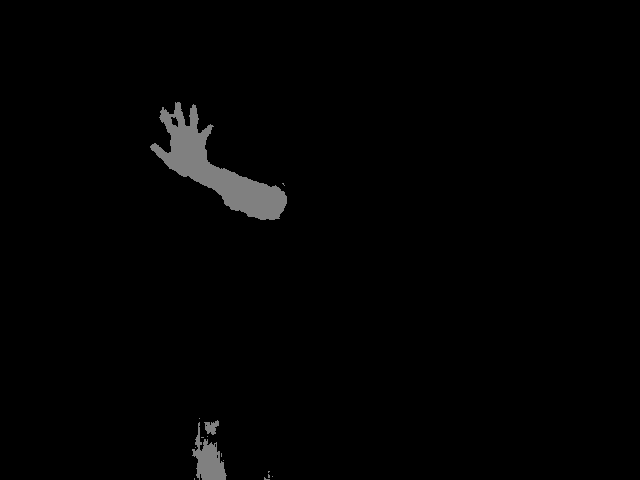

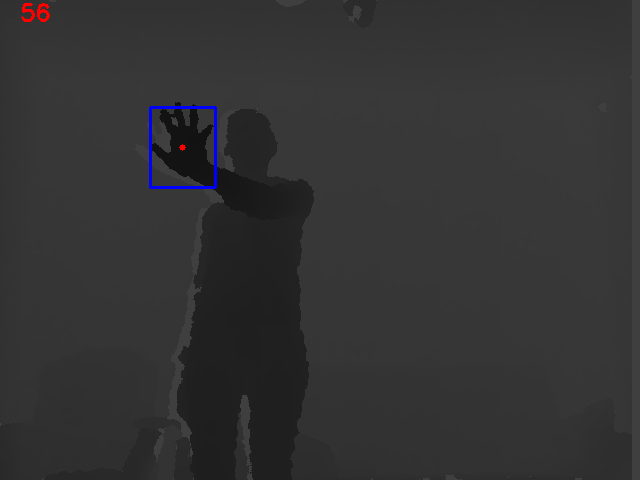

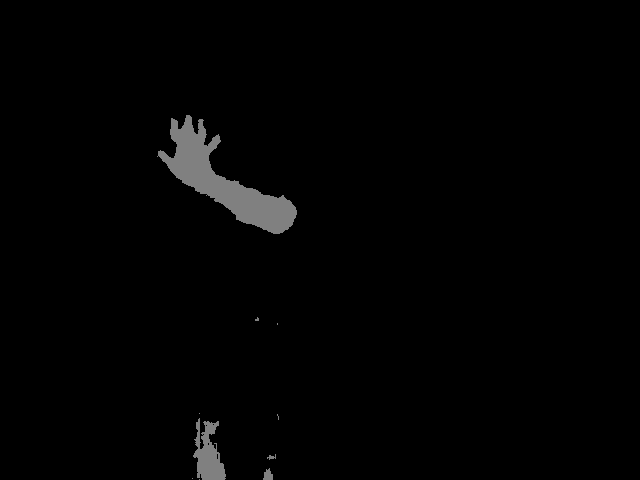

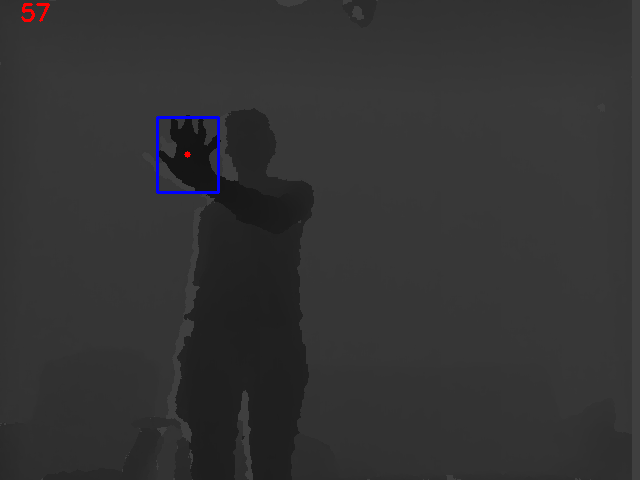

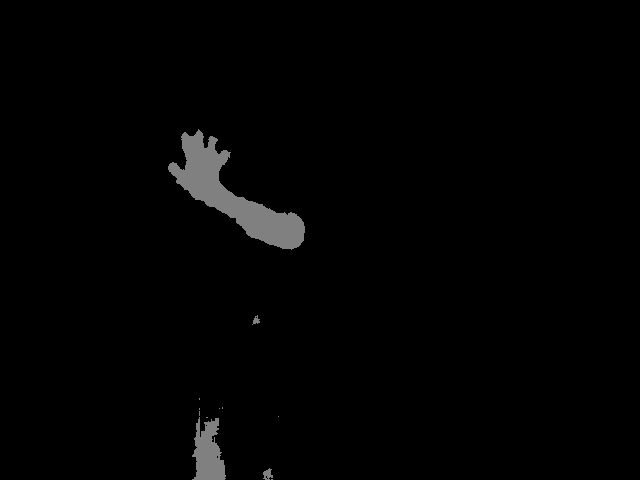

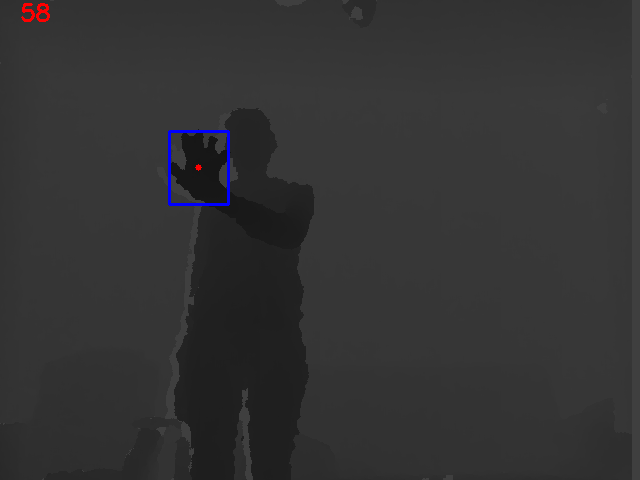

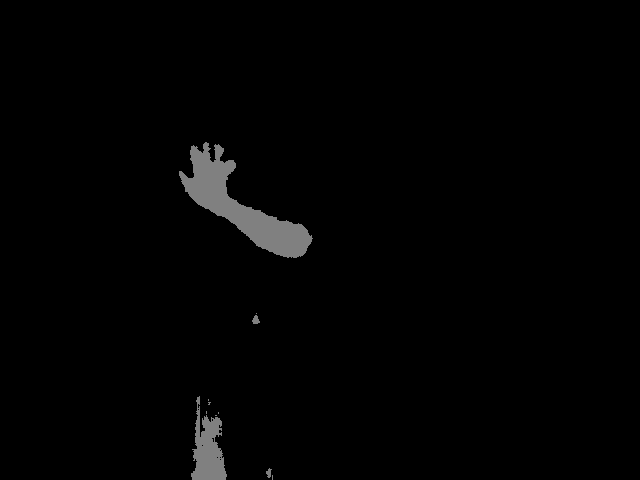

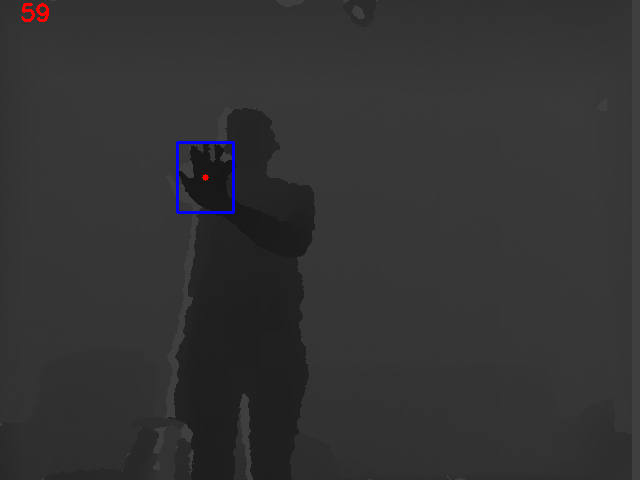

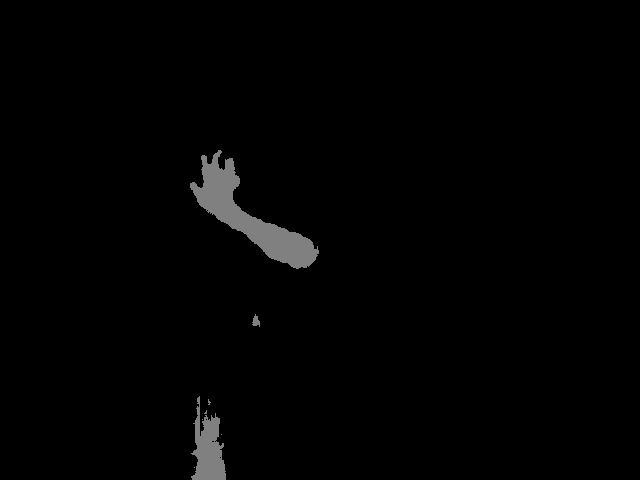

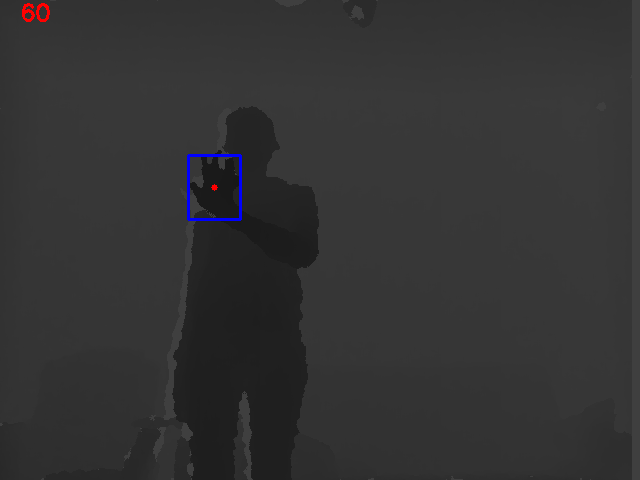

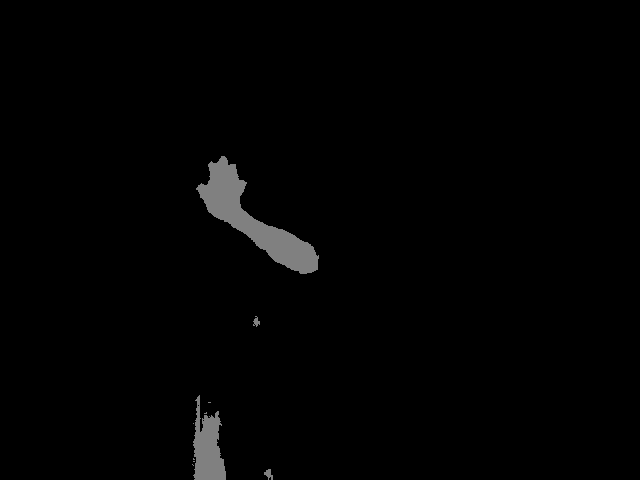

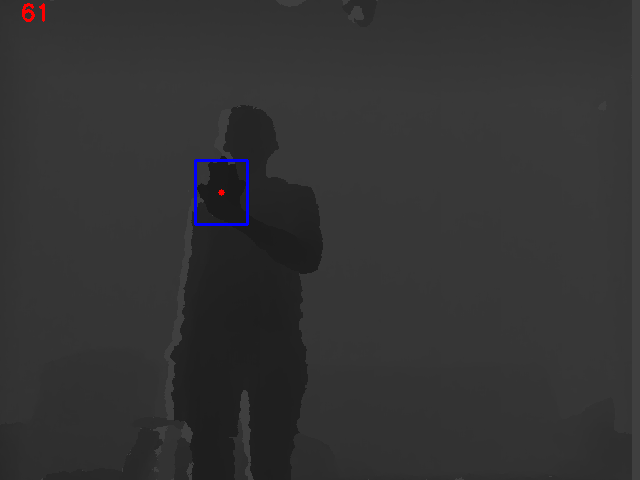

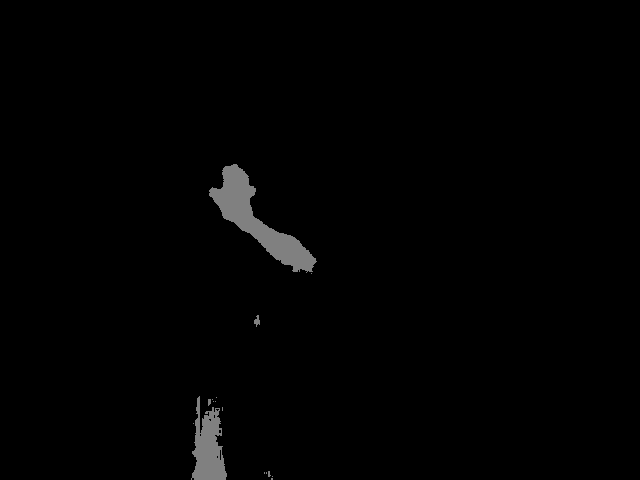

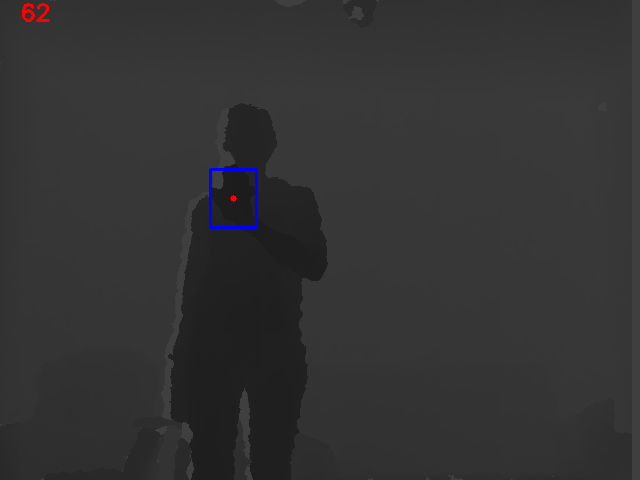

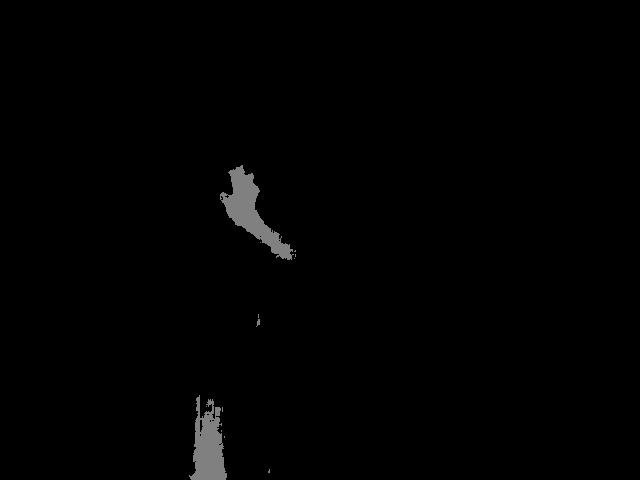

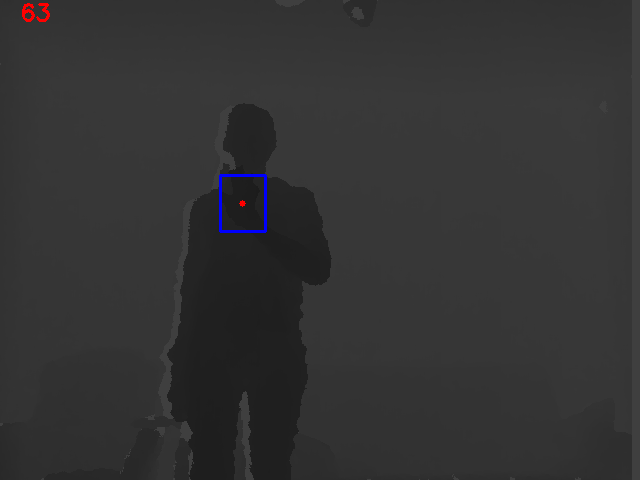

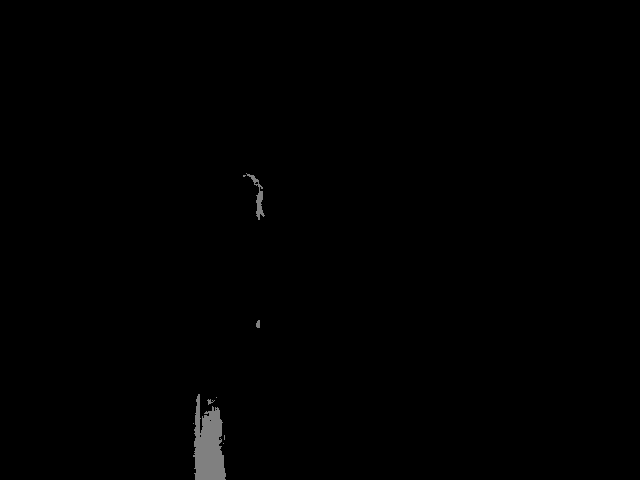

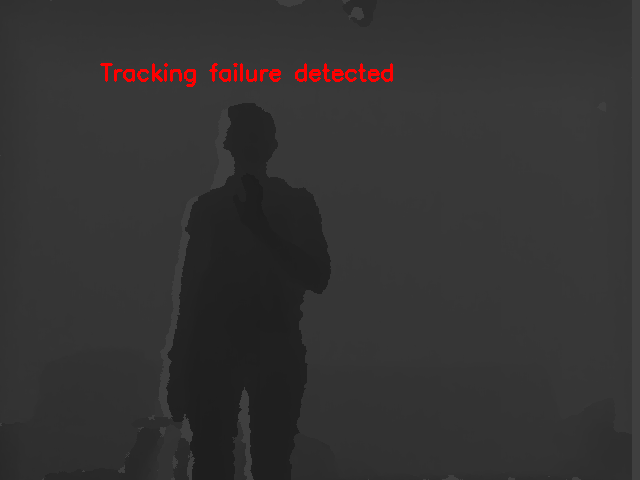

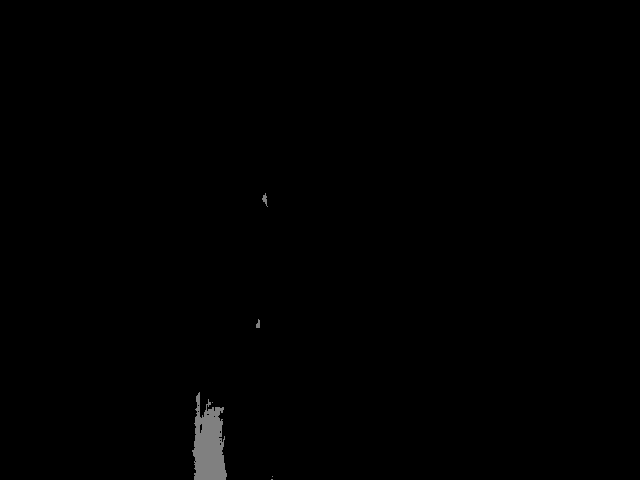

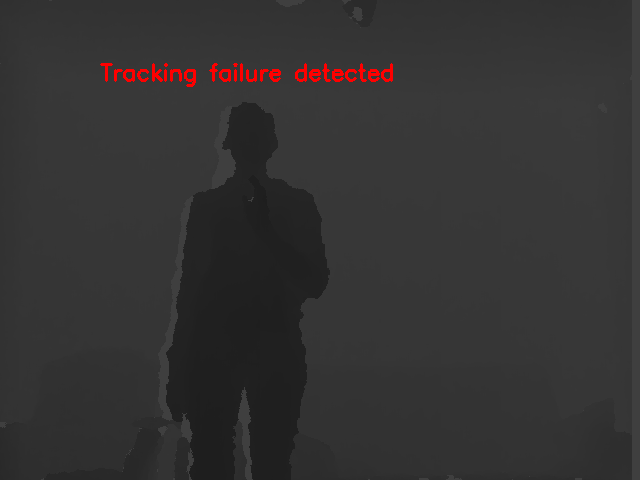

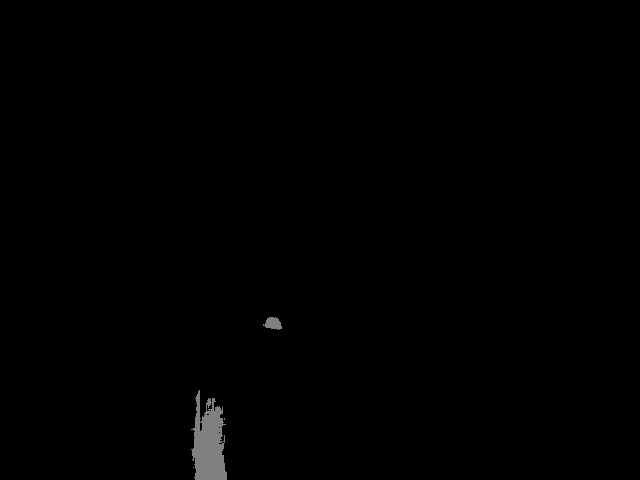

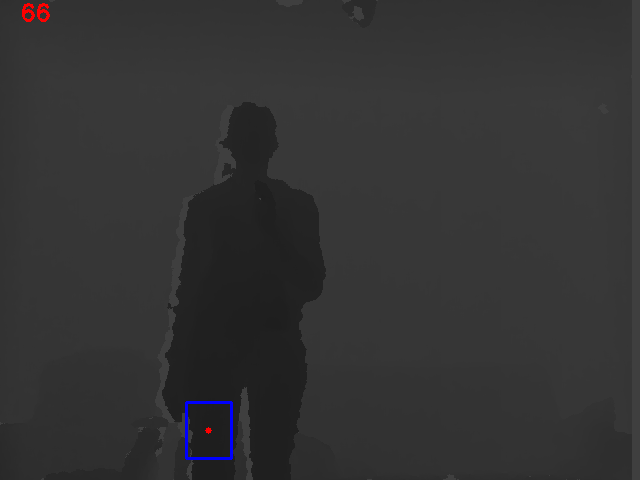

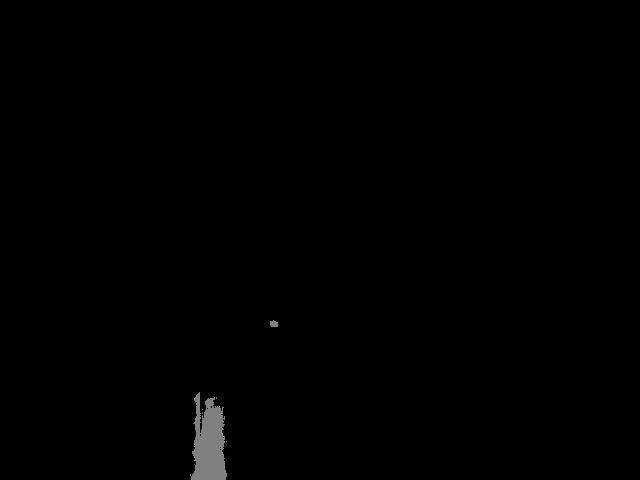

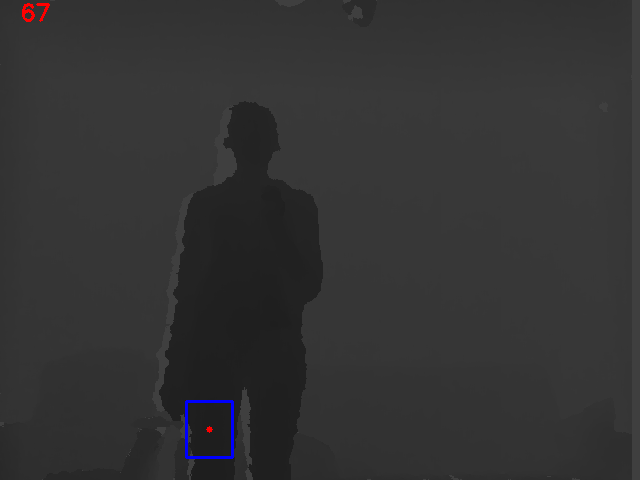

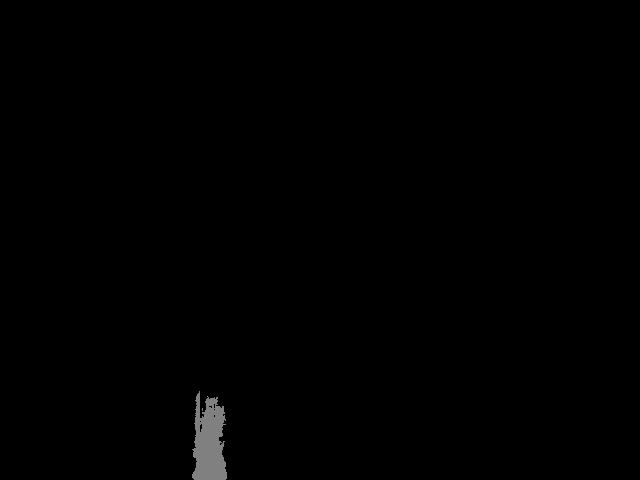

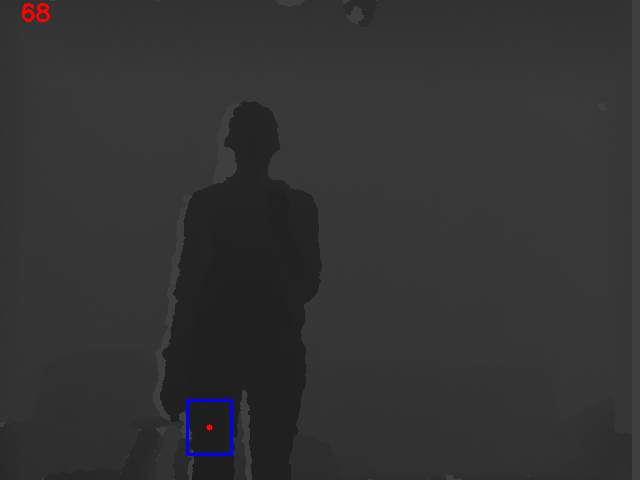

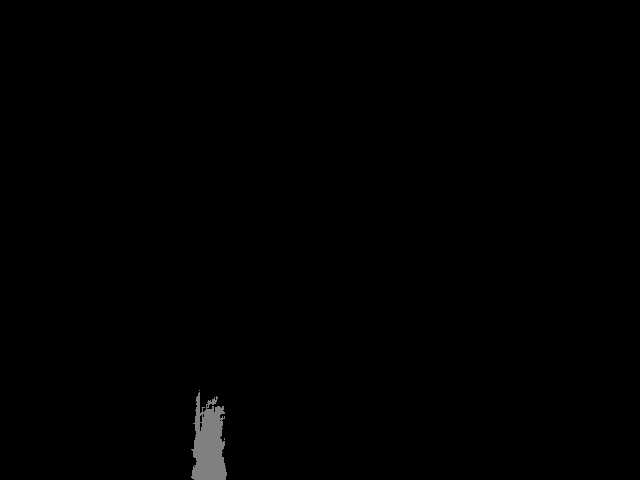

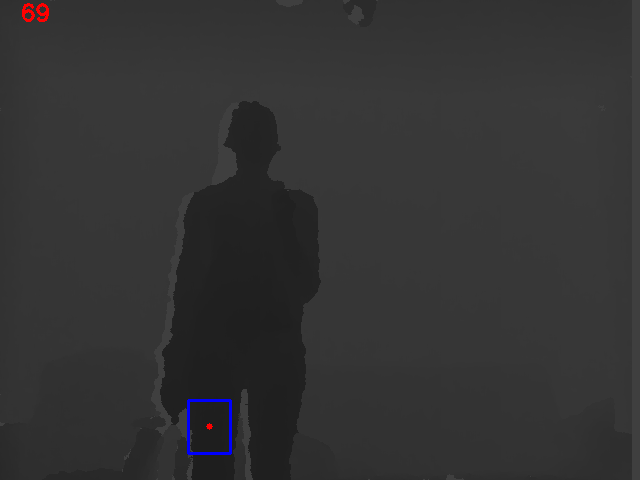

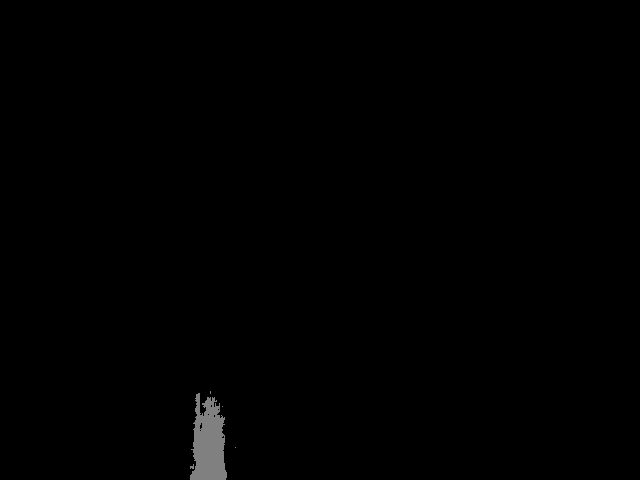

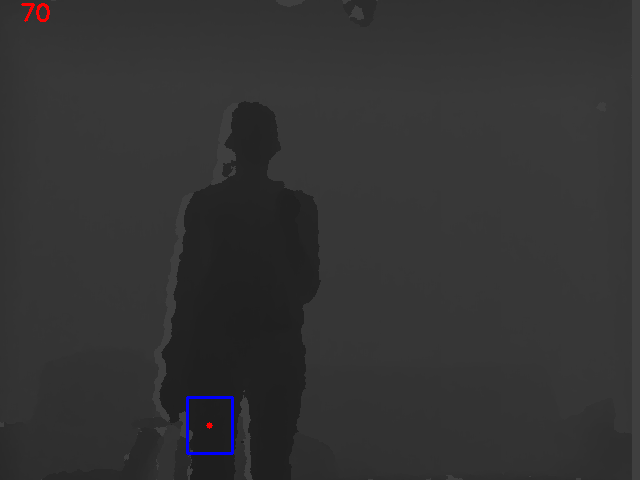

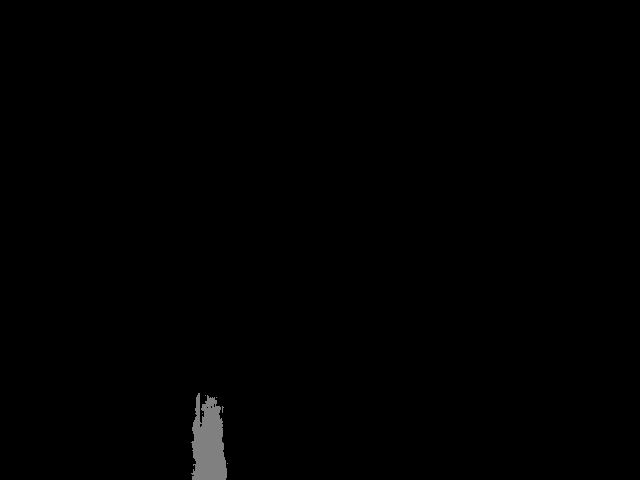

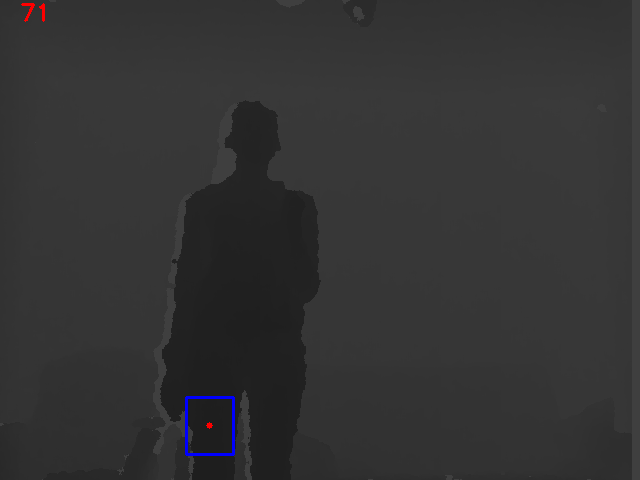

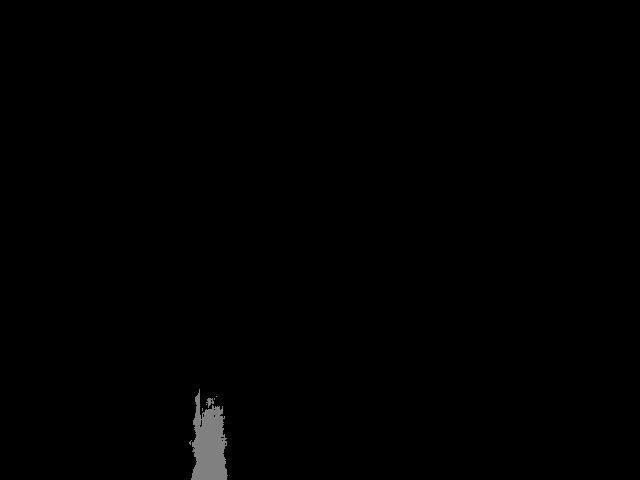

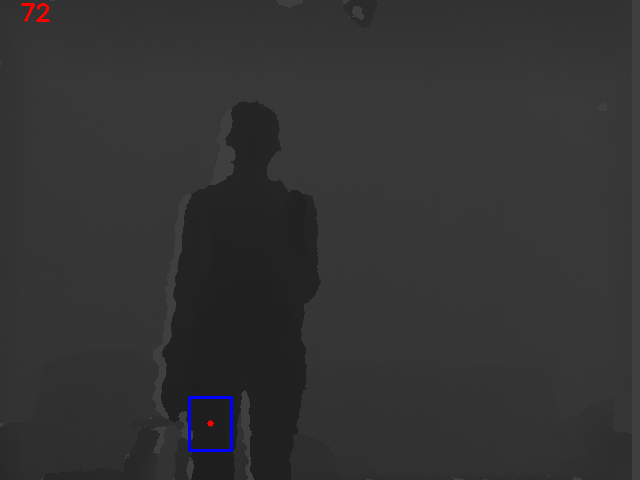

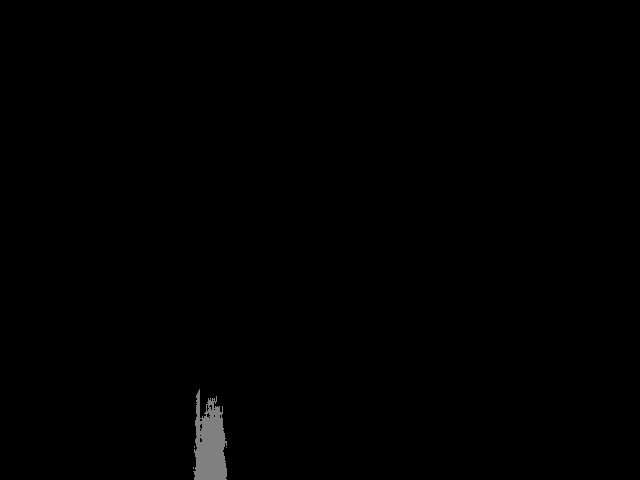

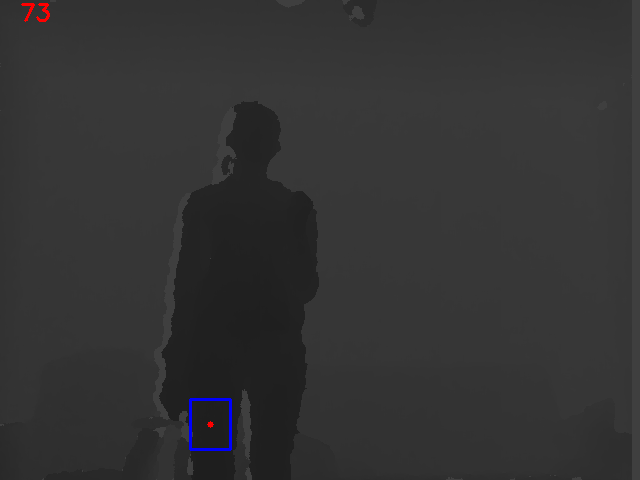

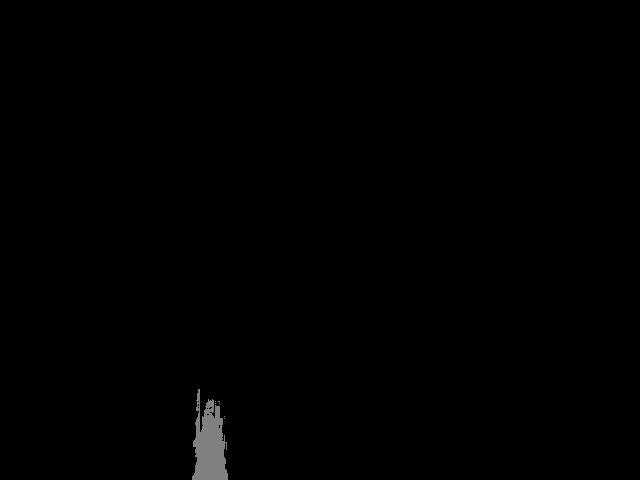

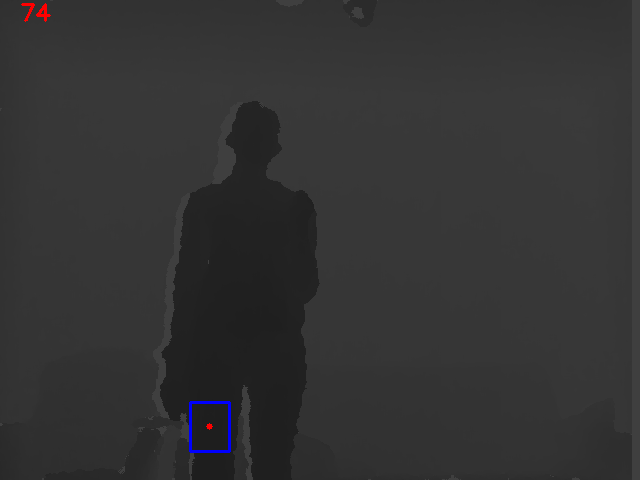

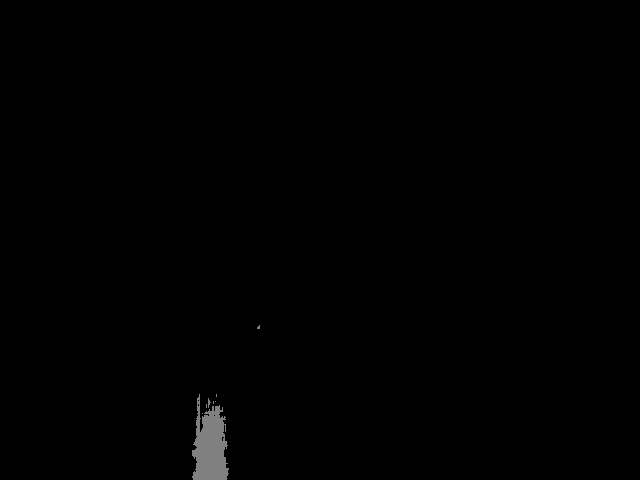

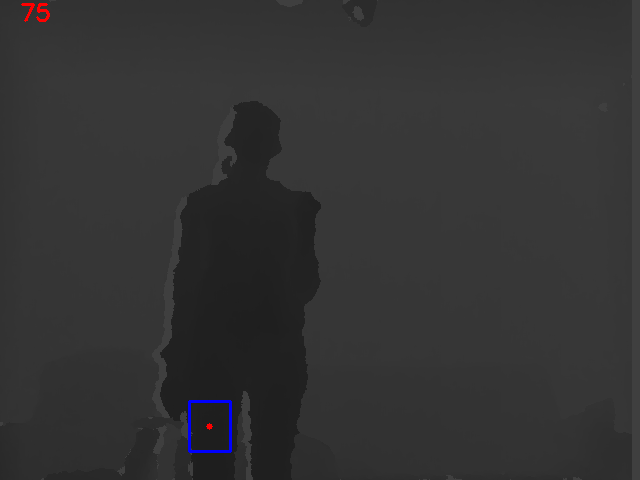

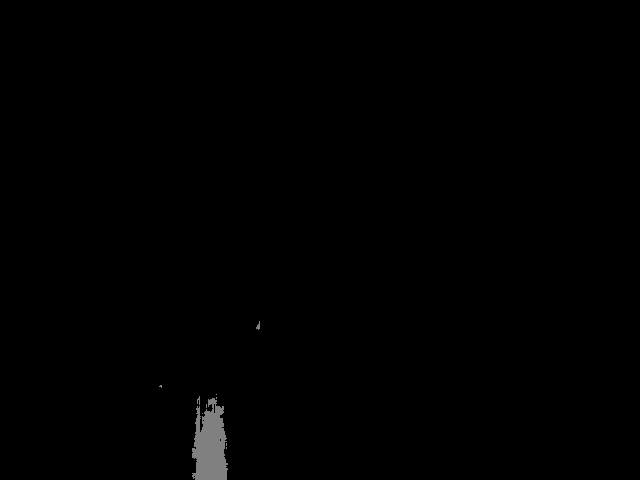

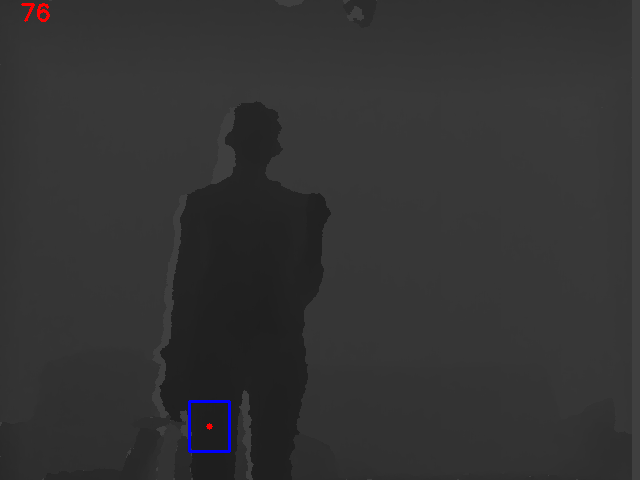

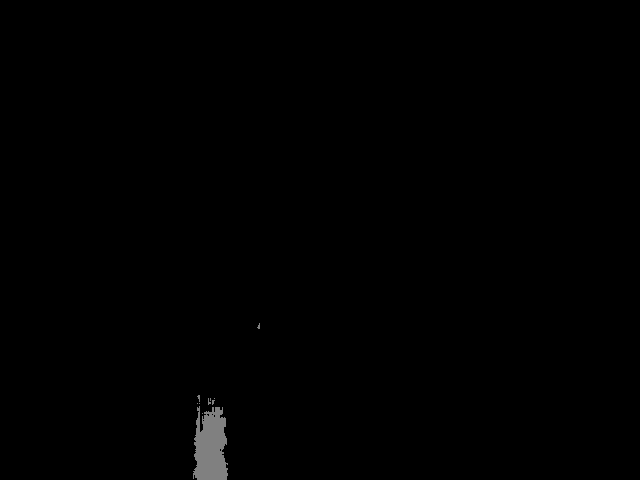

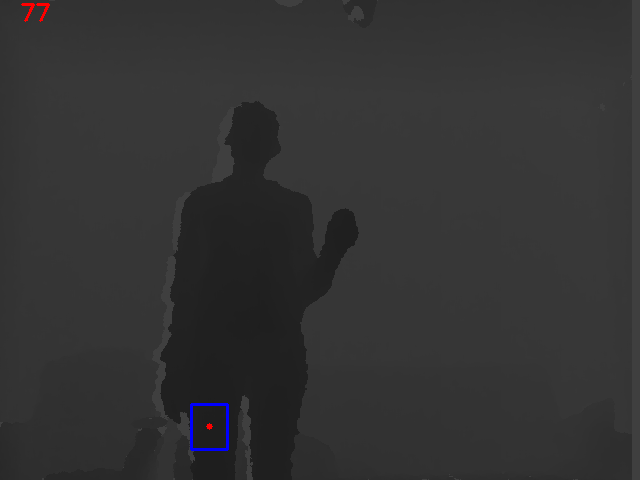

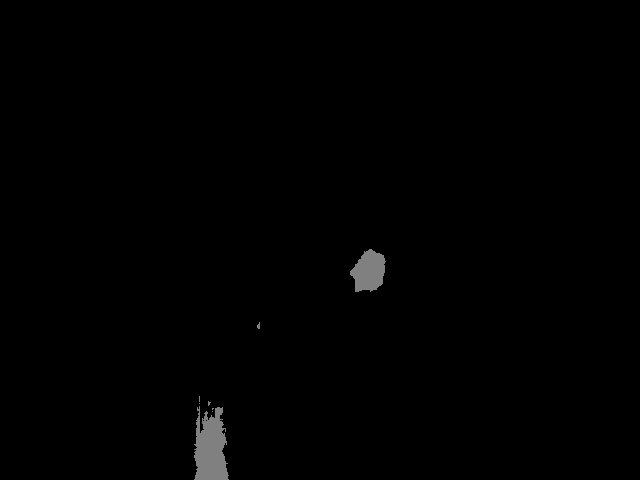

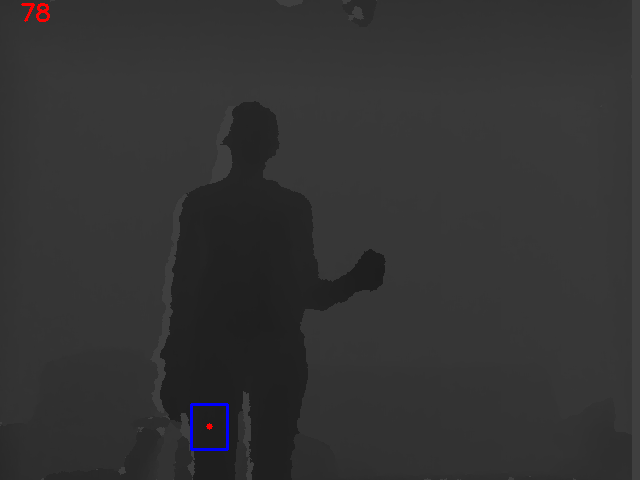

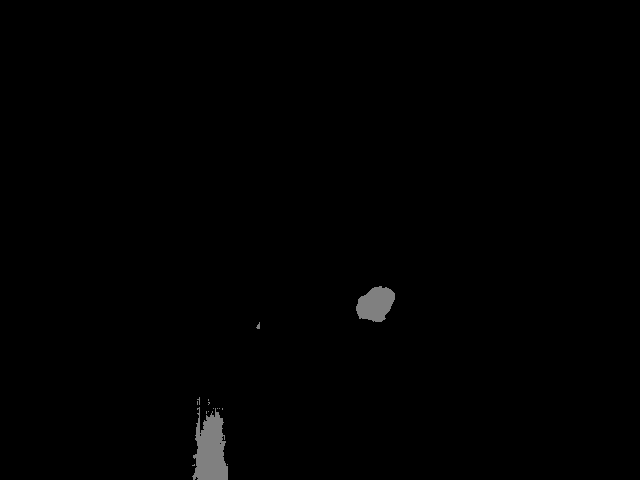

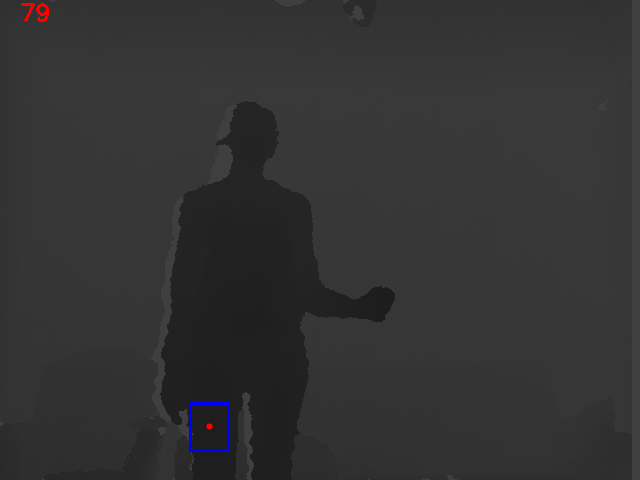

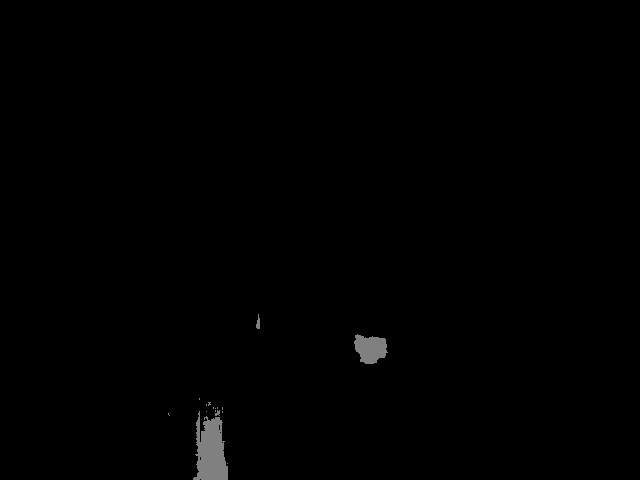

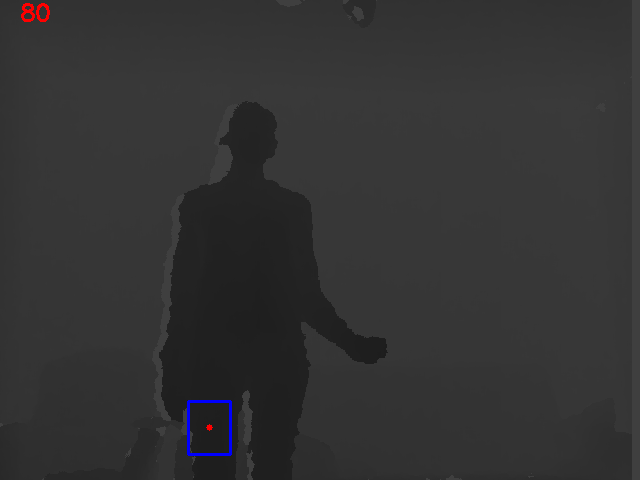

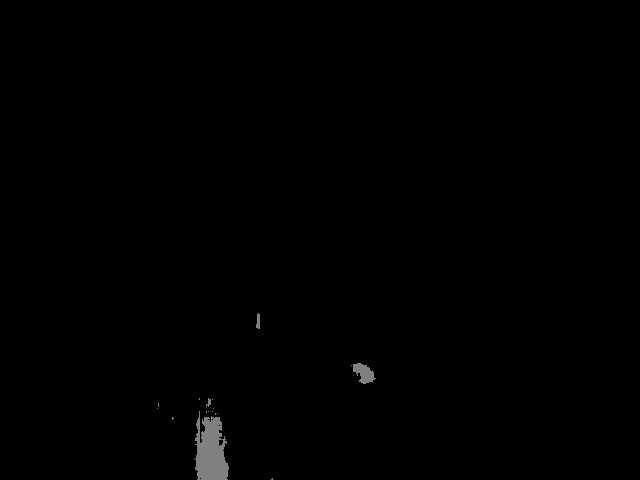

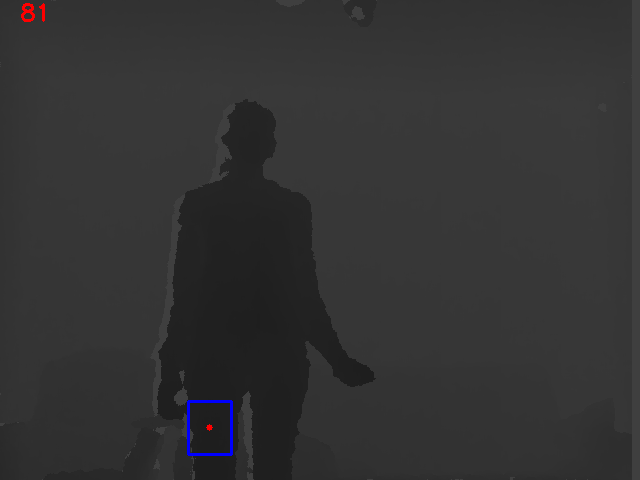

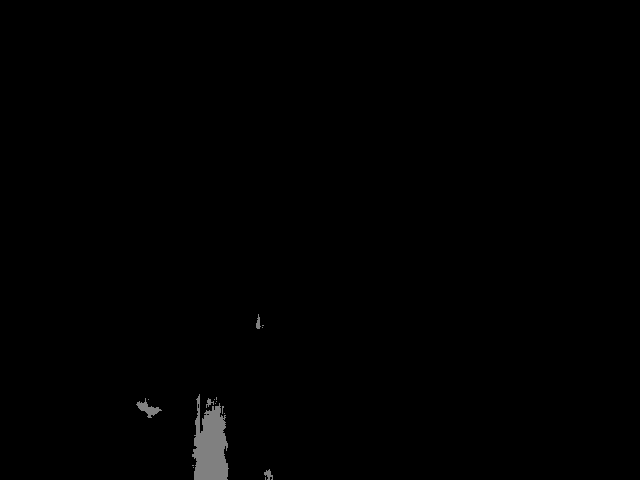

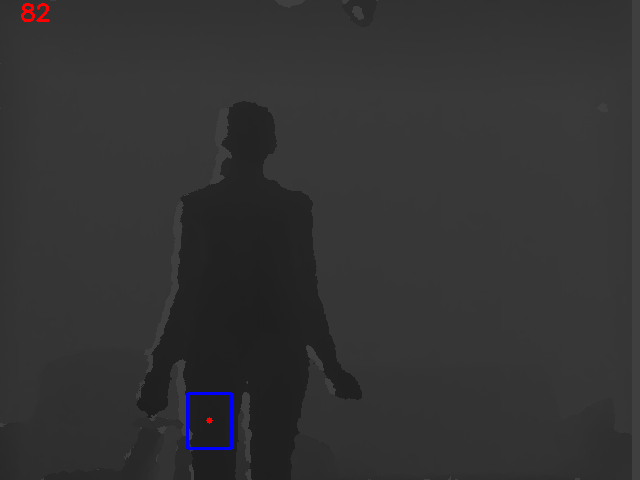

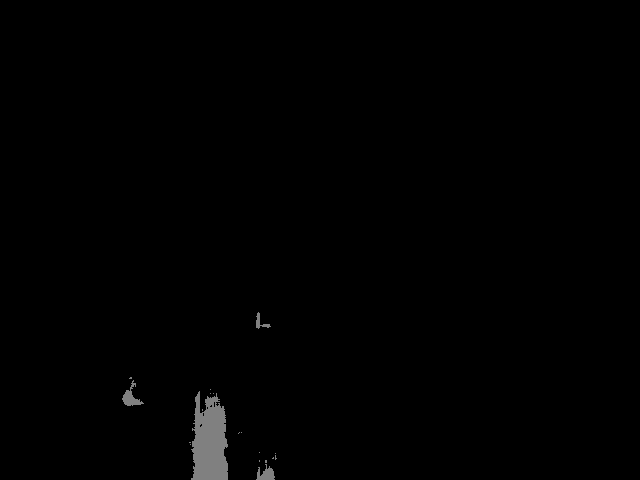

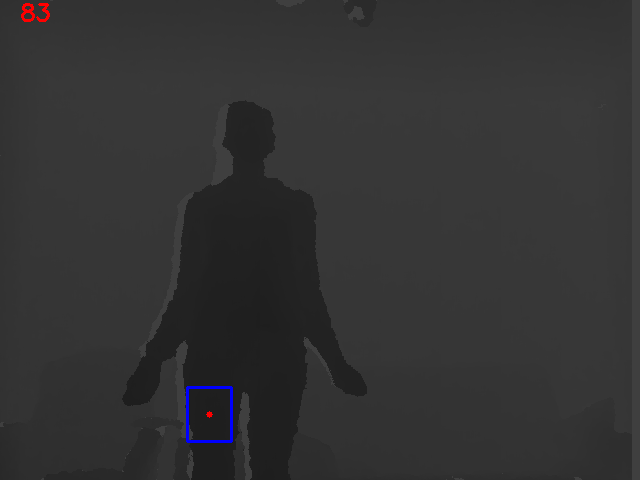

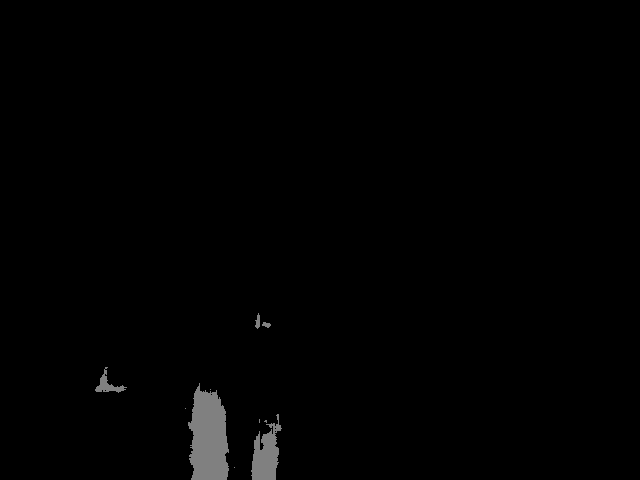

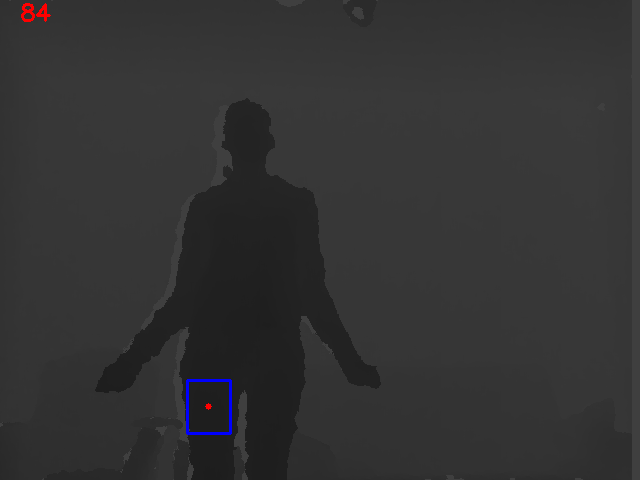

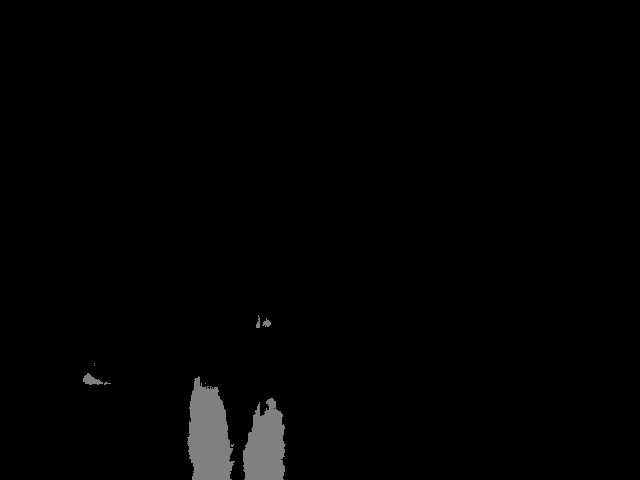

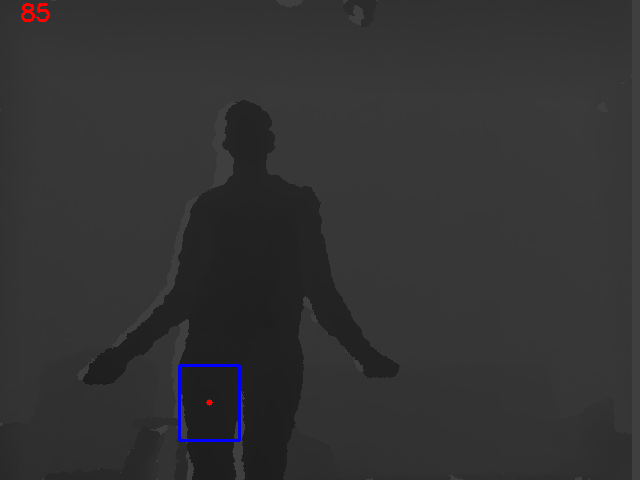

In [158]:
videoPath = ("drive/My Drive/Colab Notebooks/Kinart/videokinec_depth4.avi")
hT = HandTracker(videoPath)
hT.initTracker(1)
hT.trackHand()

In [0]:
cap = cv2.VideoCapture("drive/My Drive/Colab Notebooks/Kinart/videokinec_depth4.avi")
cap.set(cv2.CAP_PROP_POS_MSEC, 39500)
ret, frame = cap.read()

np.clip(frame, 0, 2**10-1, frame)
frame >>= 2
frame = frame.astype(np.uint8)


height, width = frame.shape[:2]

x1 = int(width*0.3)
x2 = int(width*0.46)
y1 = int(height*0.15)
y2 = int(height*0.35)

centerPoint = [int((x1+x2)/2), int((y1+y2)/2)]

center_half = 20
lowerHeight = centerPoint[1] - center_half 
upperHeight = centerPoint[1] + center_half 
lowerWidth = centerPoint[0] - center_half 
upperWidth = centerPoint[0] + center_half 
center = gray[lowerHeight:upperHeight,lowerWidth:upperWidth]


In [0]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray_copy = gray.copy()


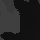

In [183]:
center_half = 20
lowerHeight = centerPoint[1] - center_half 
upperHeight = centerPoint[1] + center_half 
lowerWidth = centerPoint[0] - center_half 
upperWidth = centerPoint[0] + center_half 
center = gray[lowerHeight:upperHeight,lowerWidth:upperWidth]
cv2_imshow(center)

# import sys
# np.set_printoptions(threshold=sys.maxsize)
# print(center)

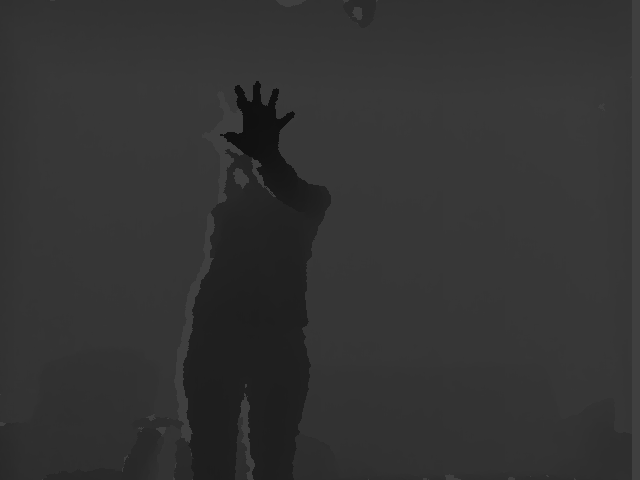

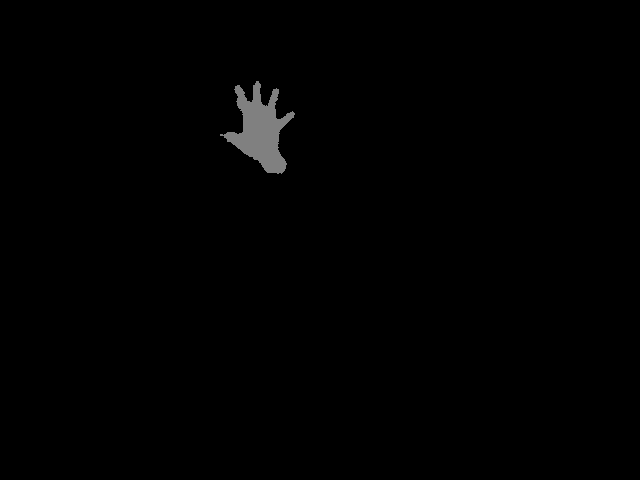

In [184]:
med_val = np.uint8(np.median(center))

med_condition = 5

cv2_imshow(gray_copy)

gray_copy = gray_copy.astype('int')
gray_copy = np.where((abs(gray_copy - int(med_val)) <= med_condition), 128, 0)
gray_copy = gray_copy.astype('uint8')

cv2_imshow(gray_copy)

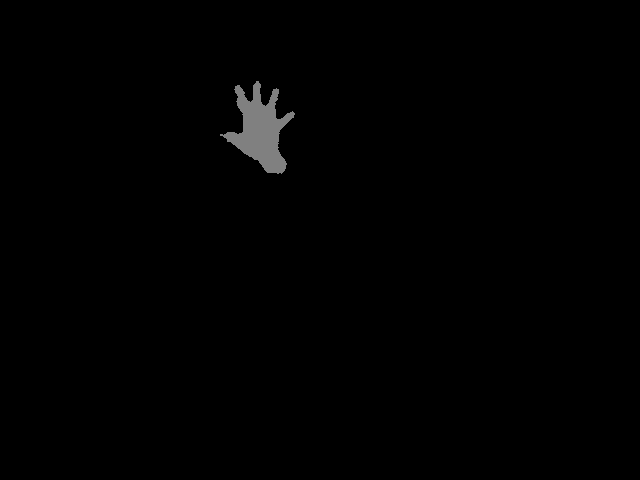

In [185]:
kernel = np.ones((5, 5), np.uint8)


kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
close = cv2.morphologyEx(gray_copy, cv2.MORPH_CLOSE, kernel, iterations=1)



cv2_imshow(close)

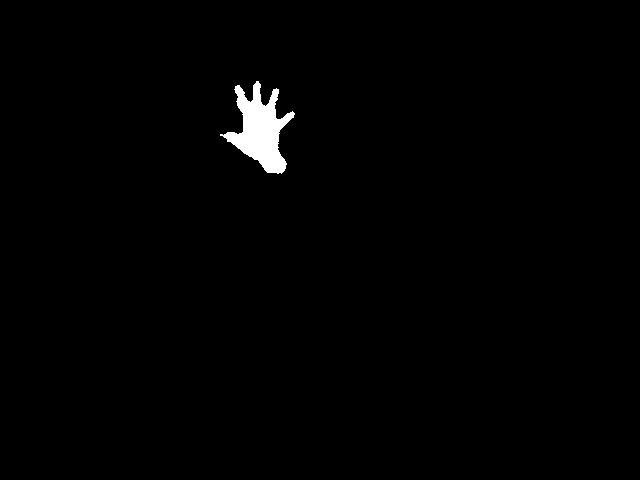

In [186]:
mask = np.zeros((height+2, width+2), np.uint8)

flood = close.copy()
cv2.floodFill(flood, mask, (centerPoint[0],centerPoint[1]), 255)

cv2_imshow(flood)

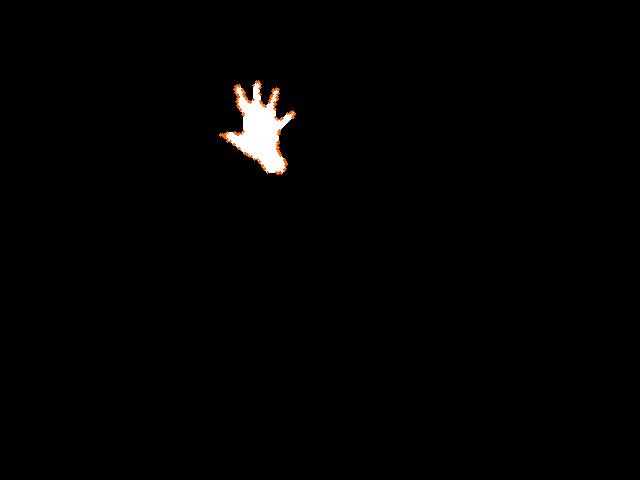

In [187]:
_, contours, hierarchy = cv2.findContours(flood, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)

img = cv2.cvtColor(flood, cv2.COLOR_GRAY2RGB)

cv2.drawContours(img, max_contour, -1, (0,102,255), 2)
cv2_imshow(img)


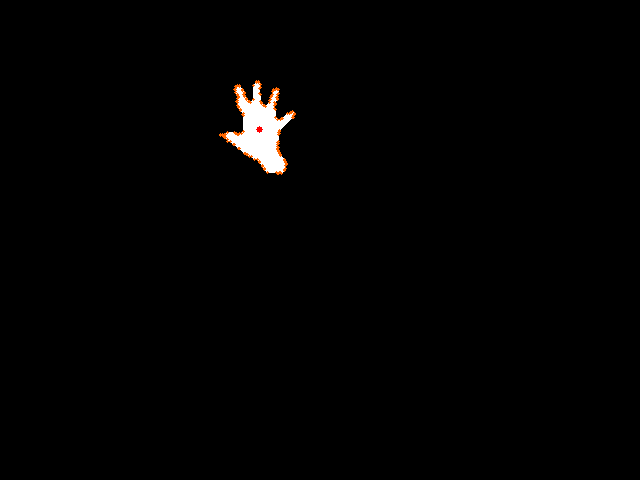

In [188]:
moment = cv2.moments(max_contour)
if moment['m00'] != 0:
  cx = int(moment['m10'] / moment['m00'])
  cy = int(moment['m01'] / moment['m00'])
  cv2.circle(img, (cx, cy), 3, (0, 0, 255), -1)

cv2_imshow(img)

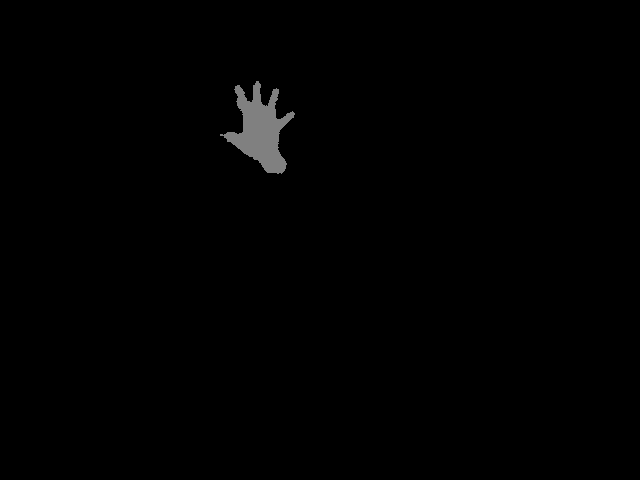

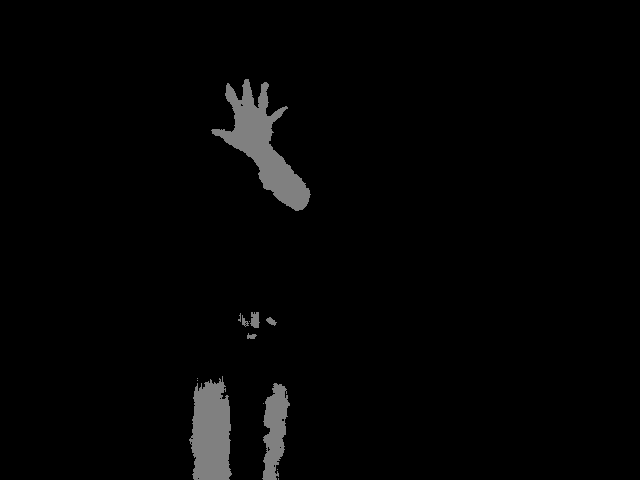

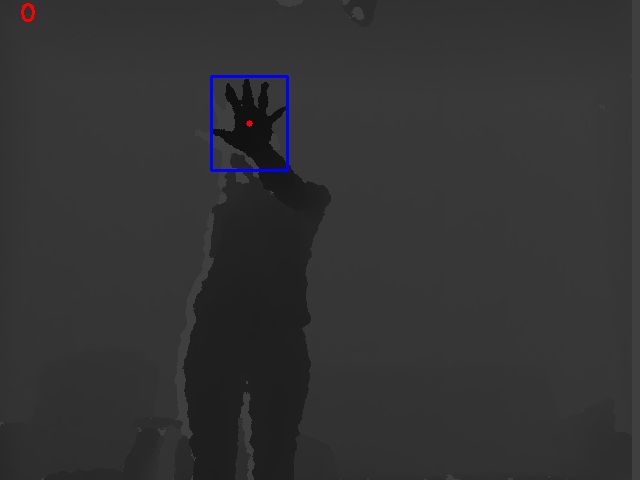

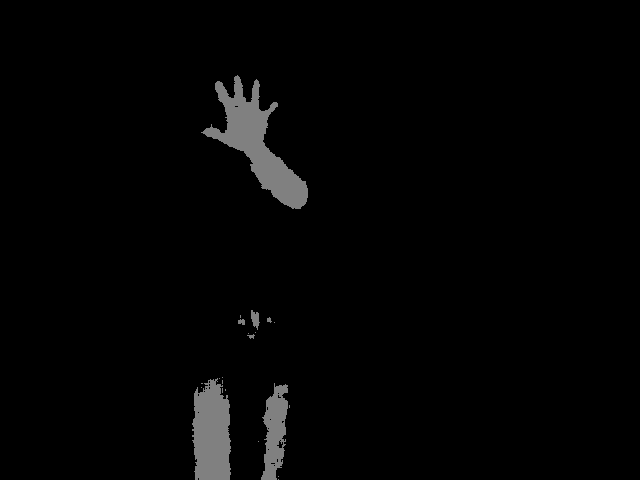

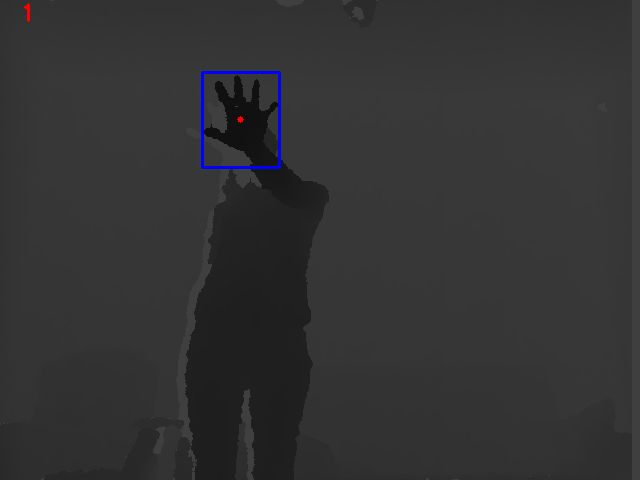

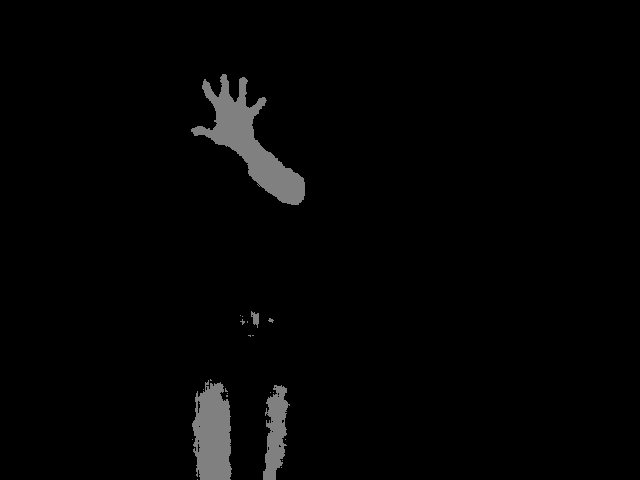

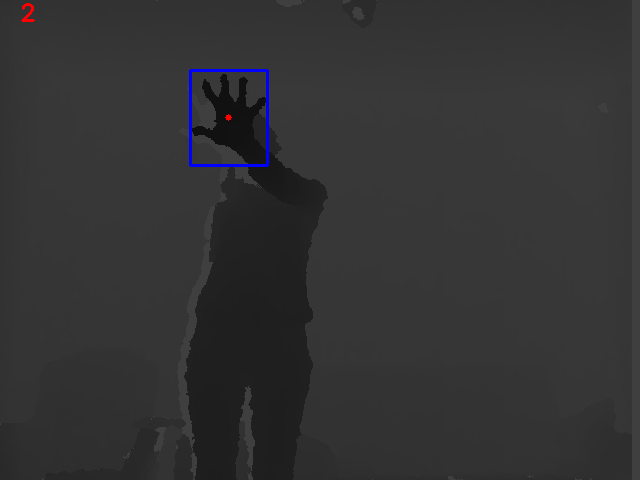

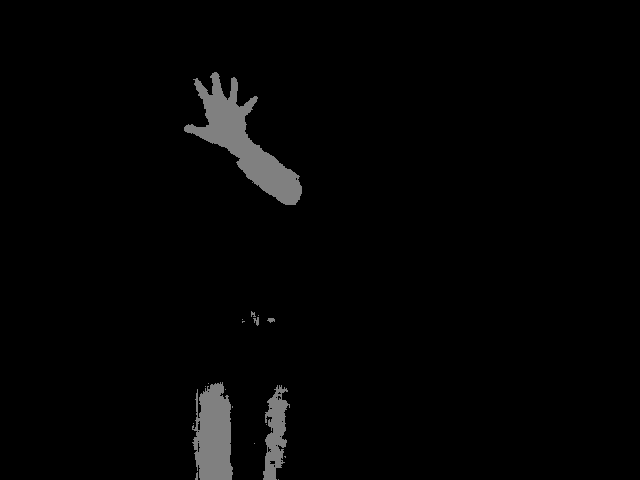

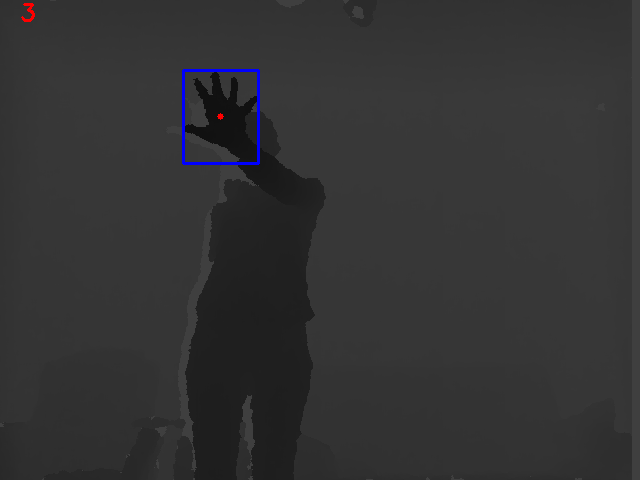

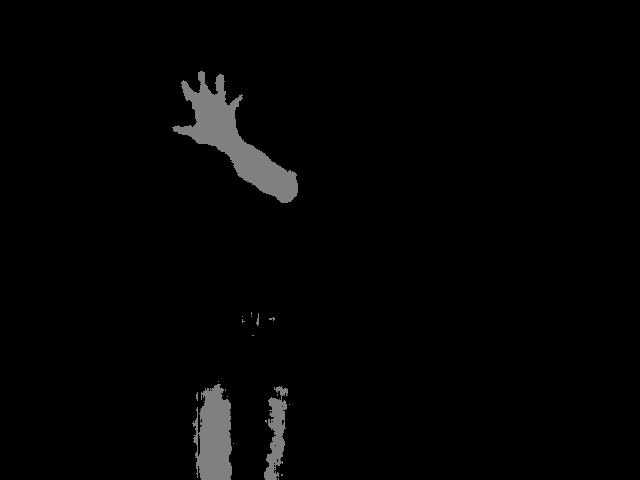

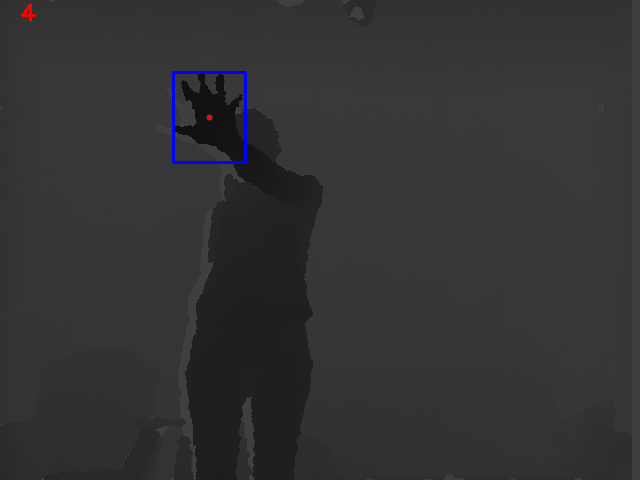

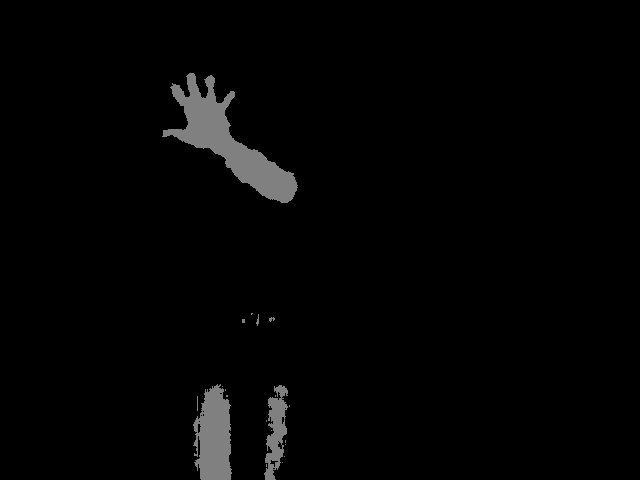

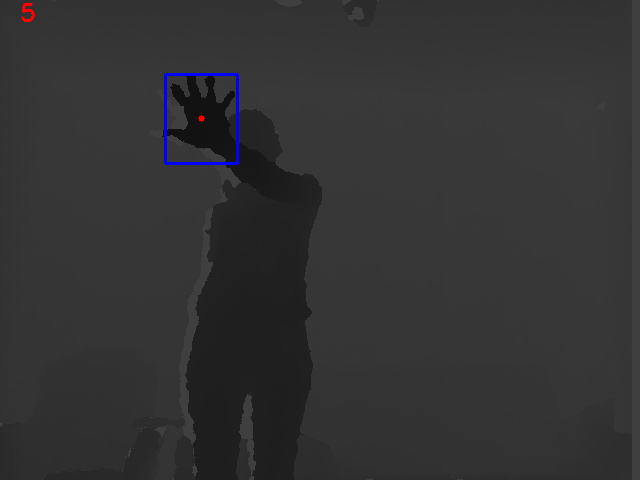

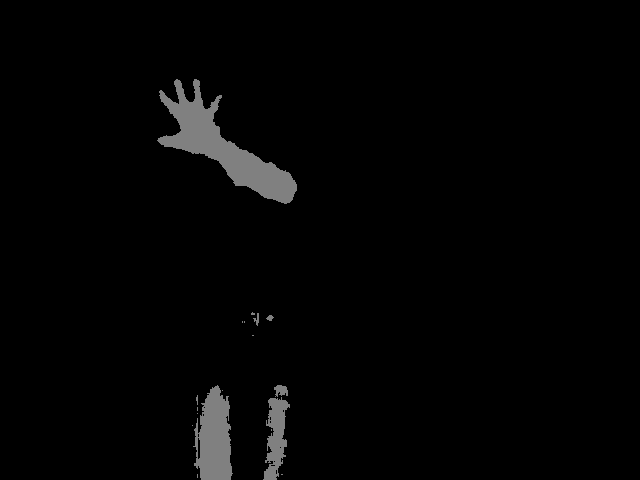

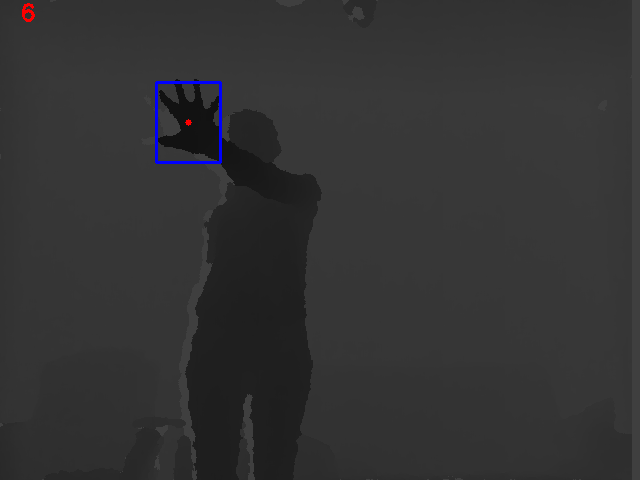

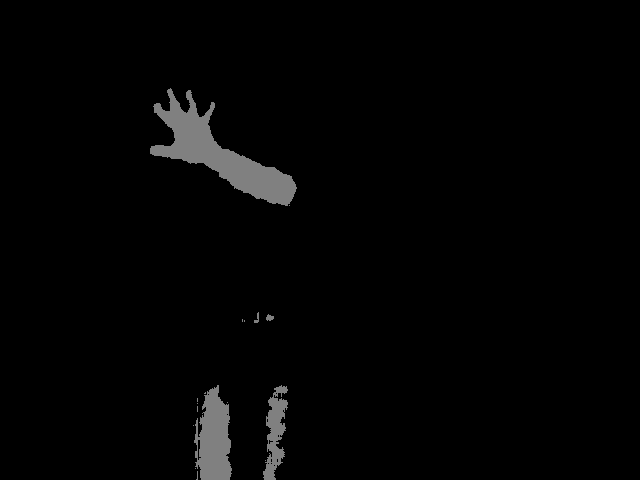

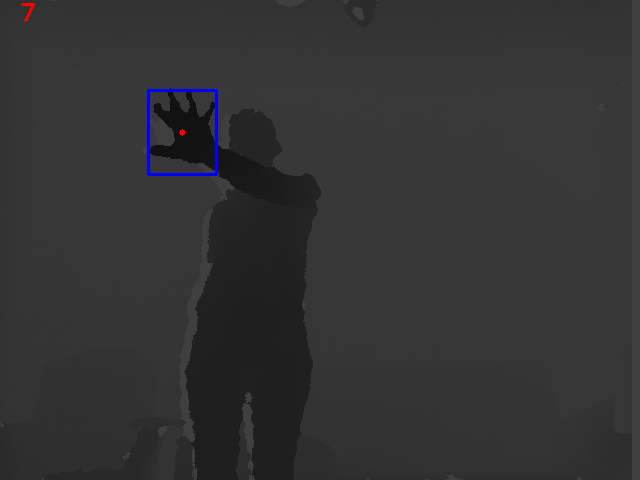

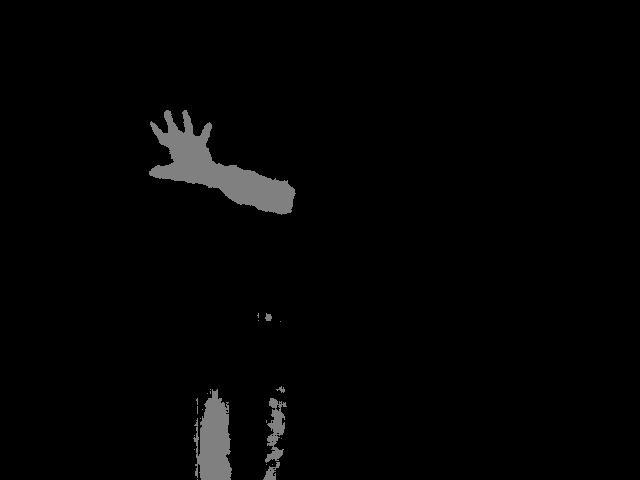

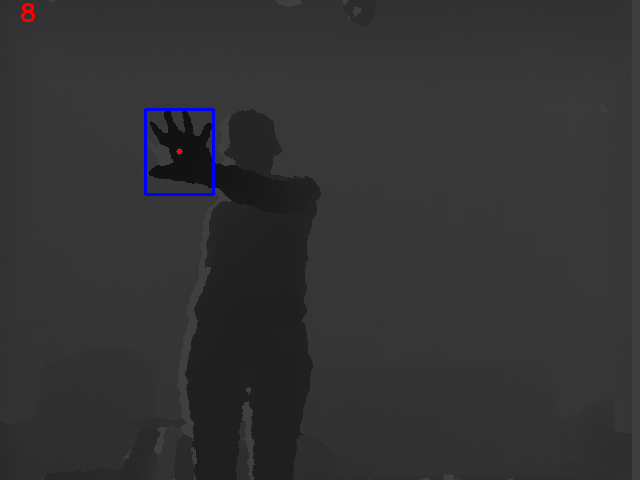

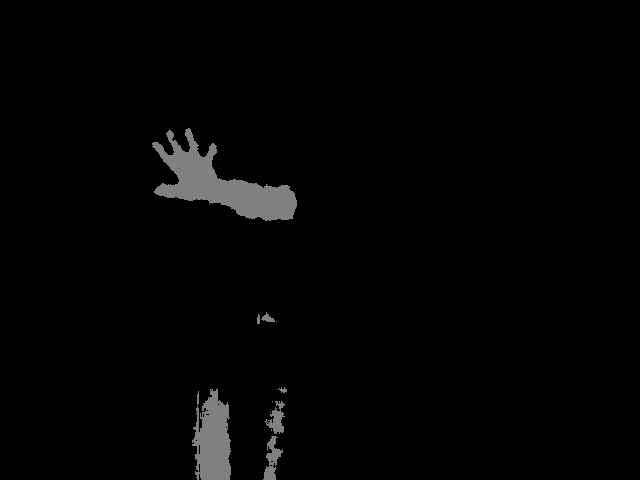

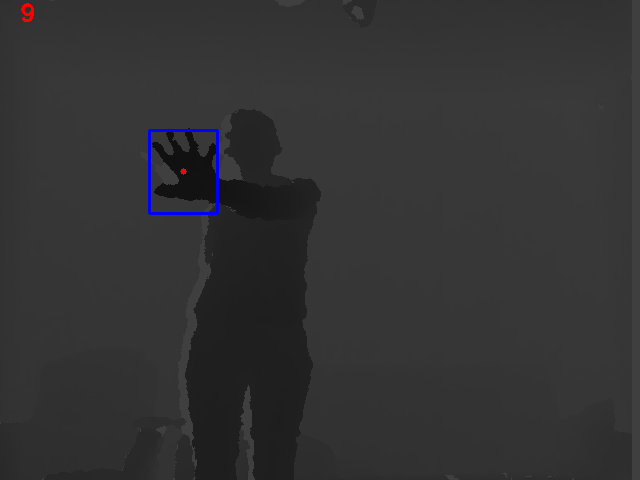

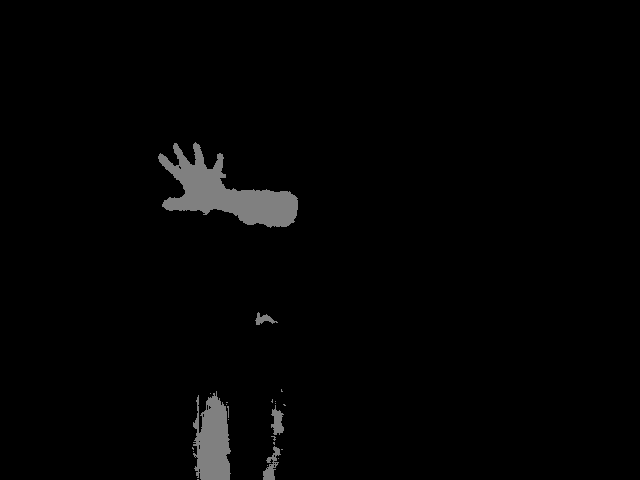

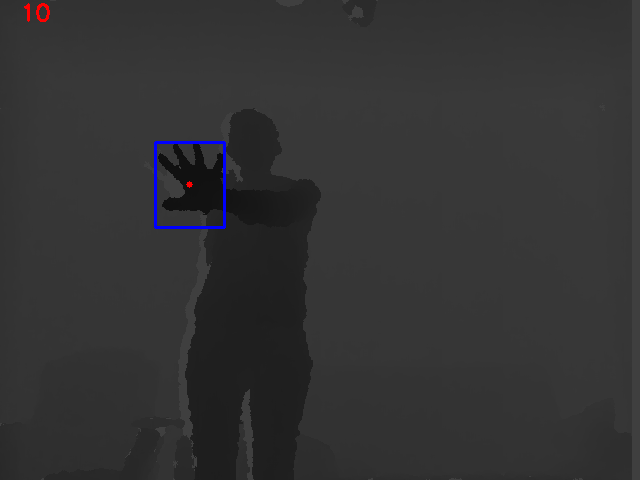

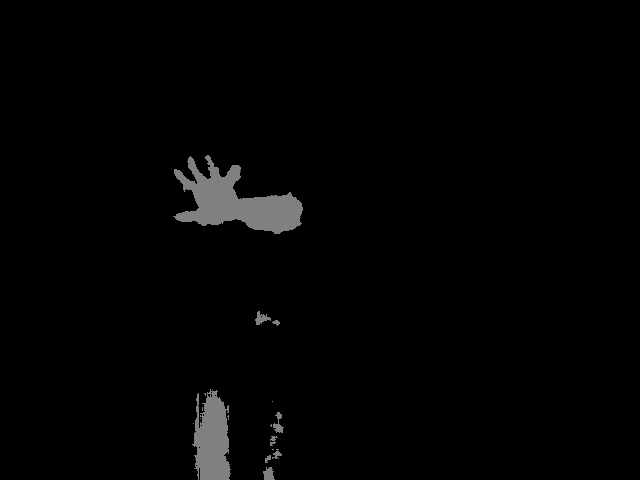

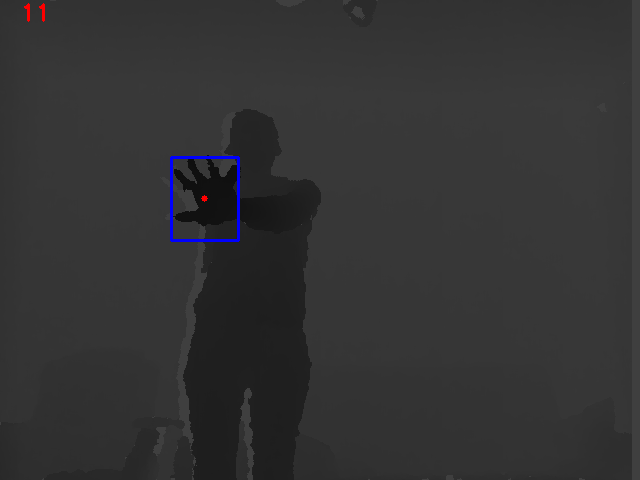

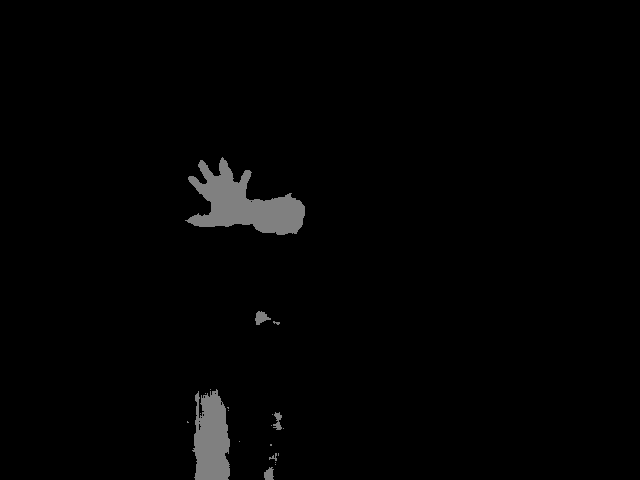

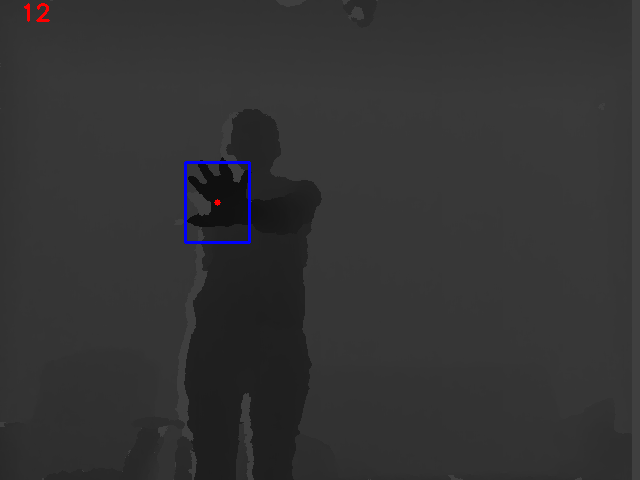

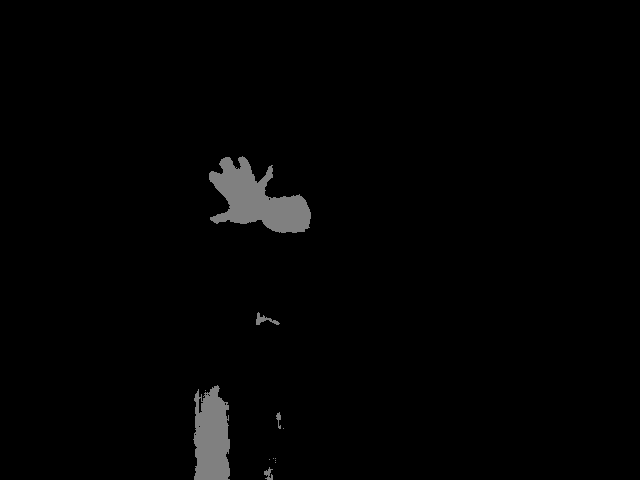

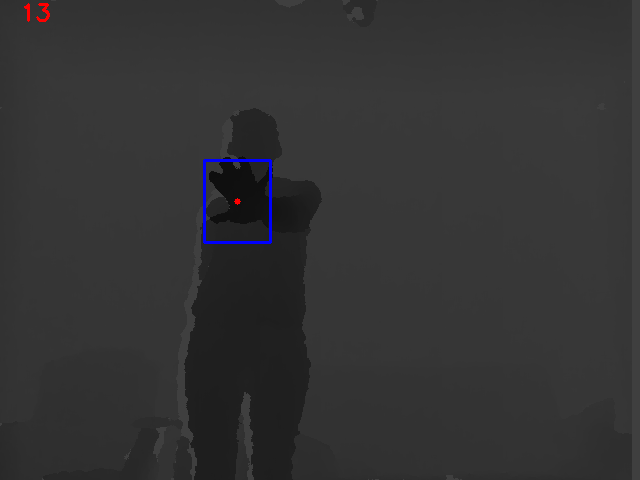

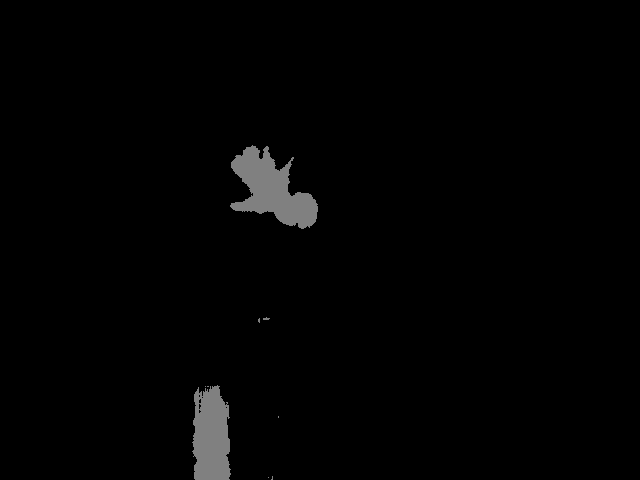

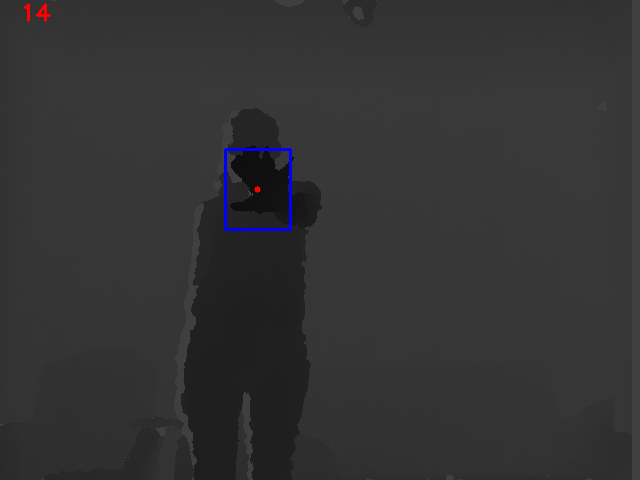

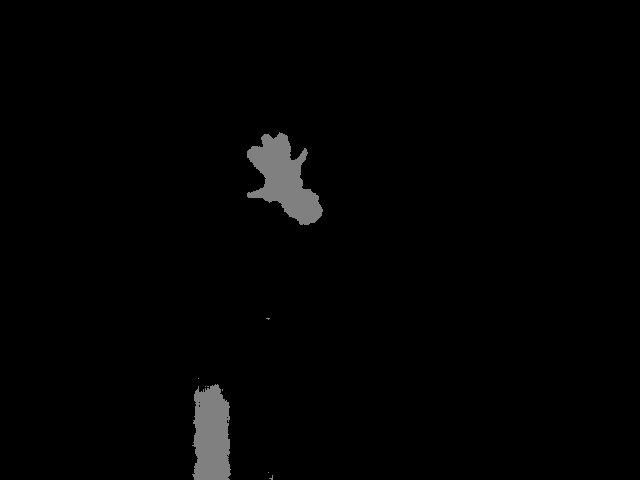

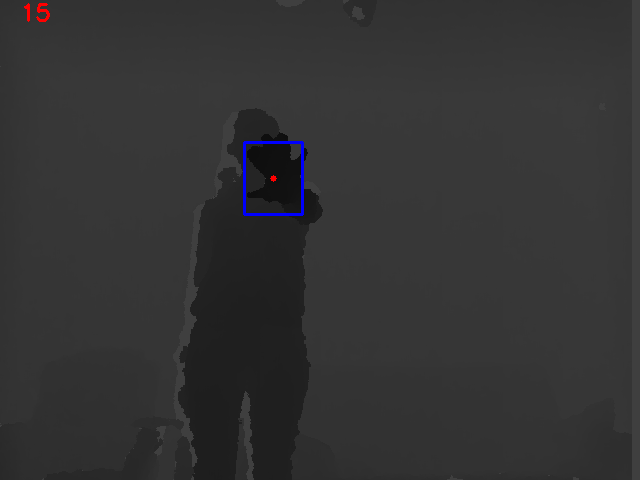

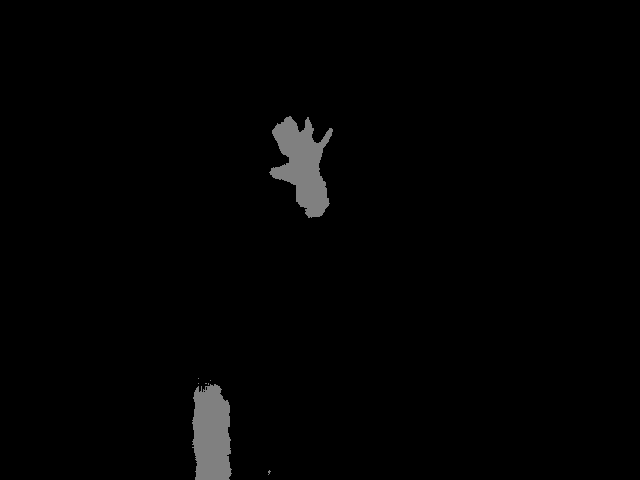

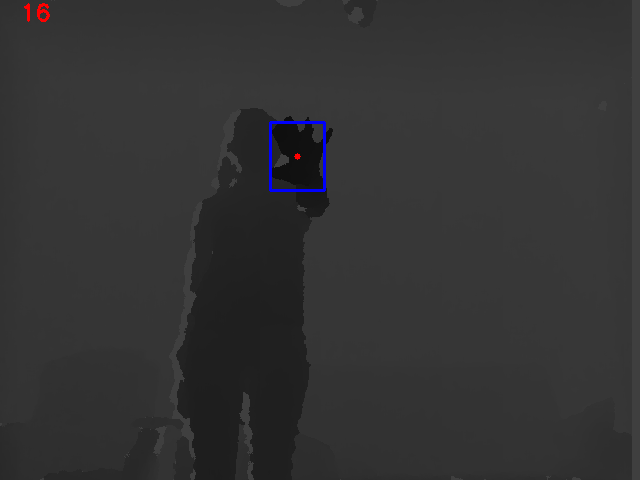

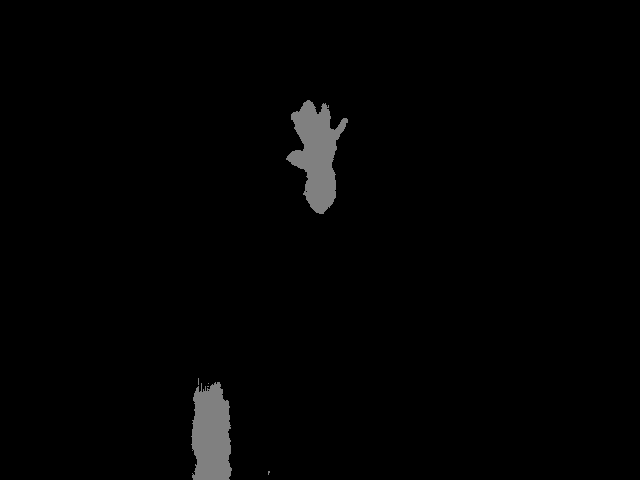

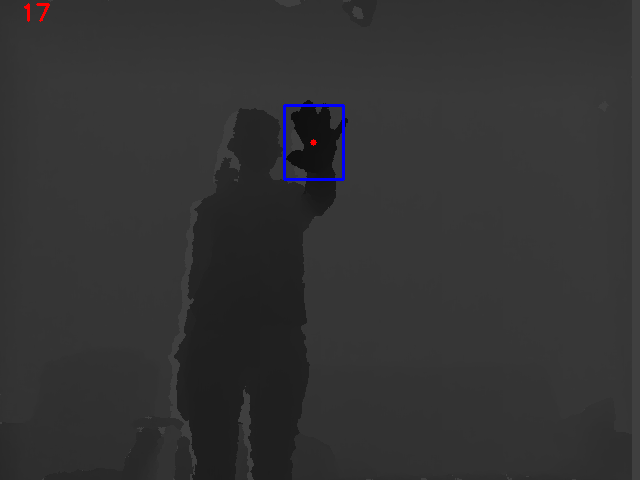

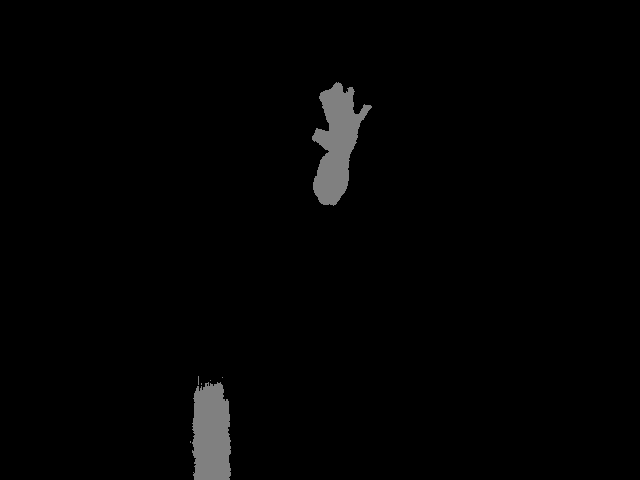

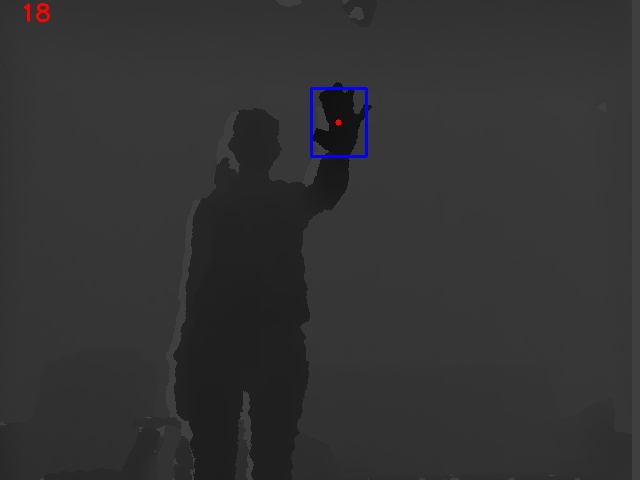

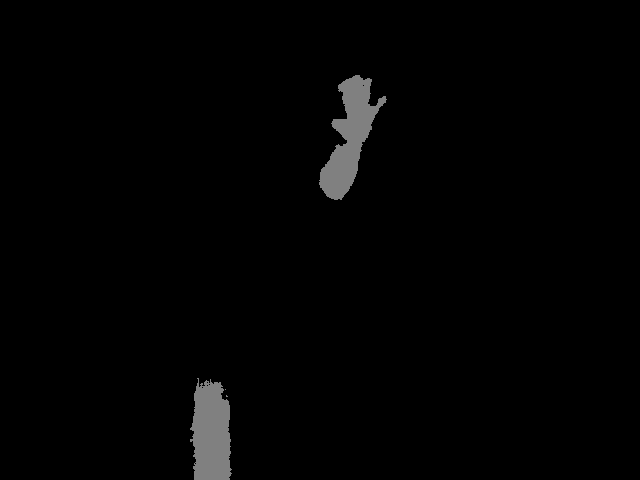

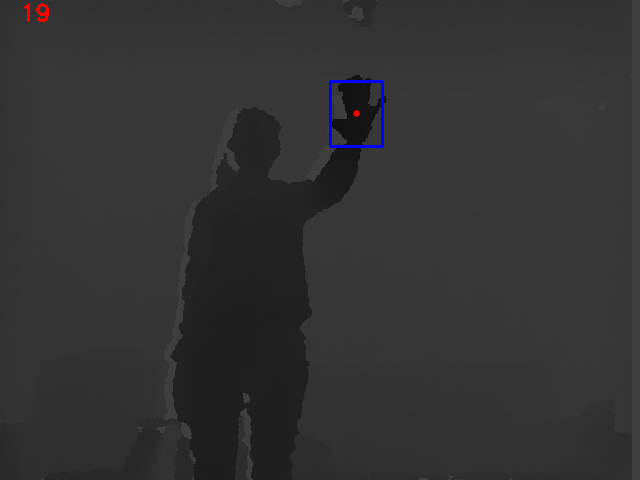

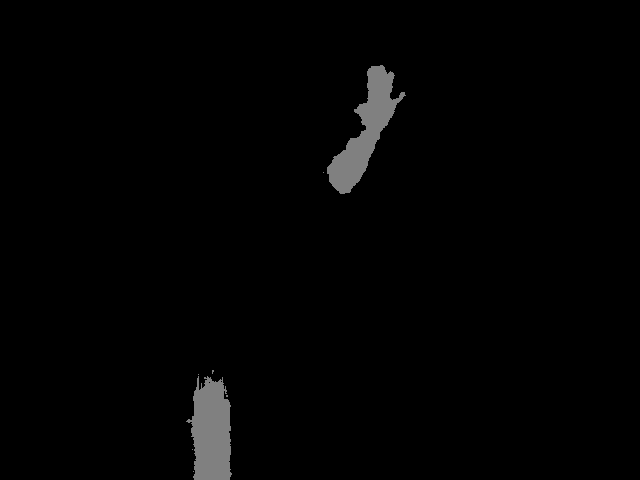

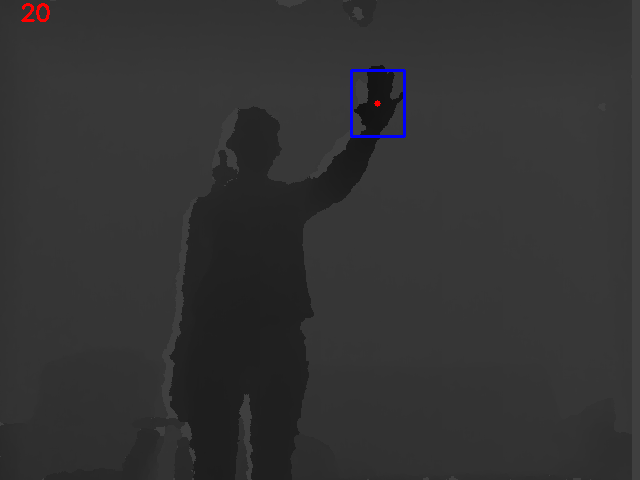

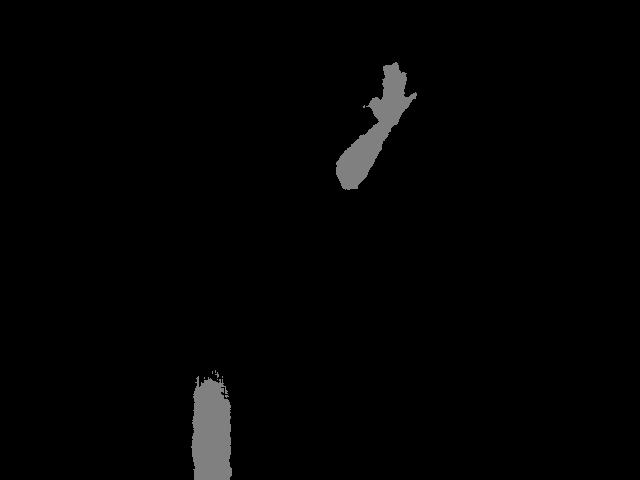

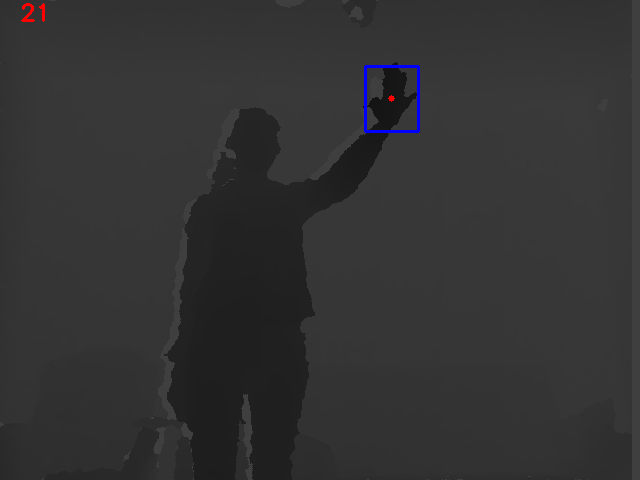

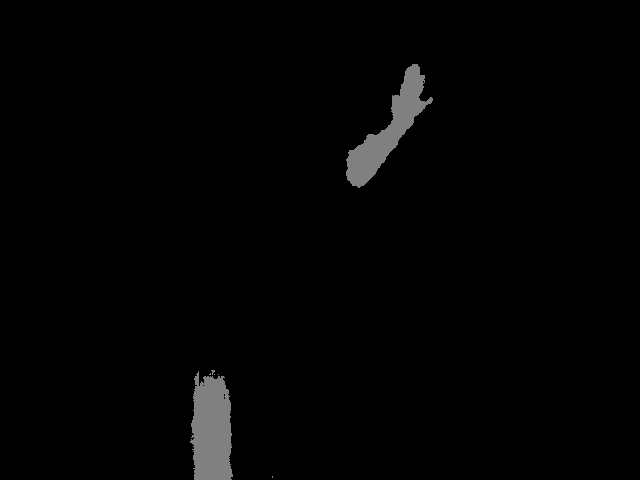

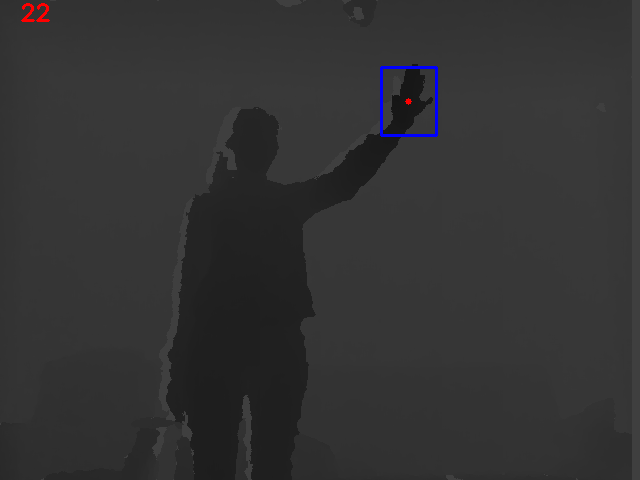

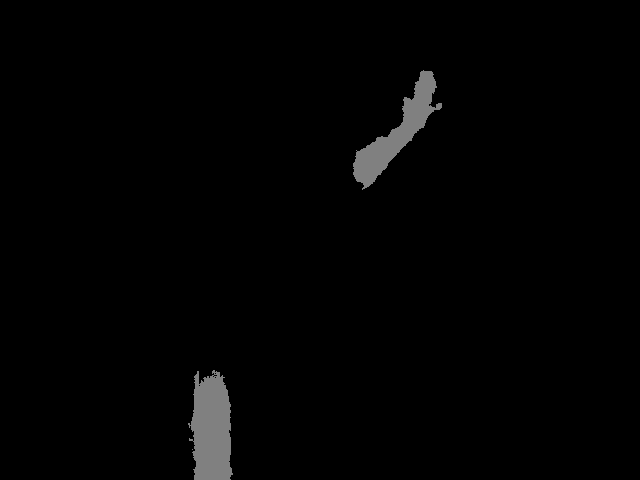

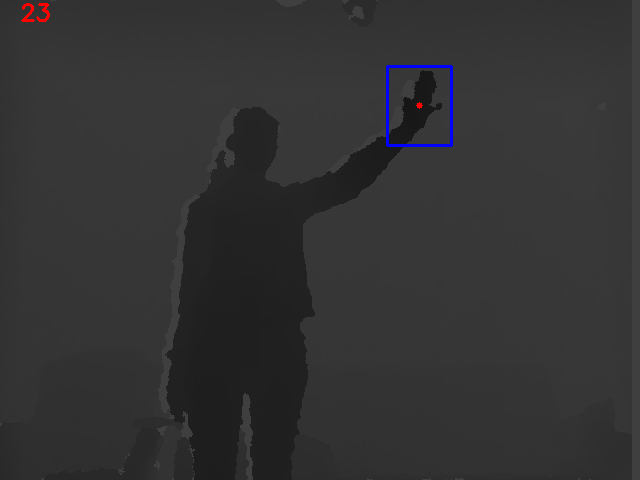

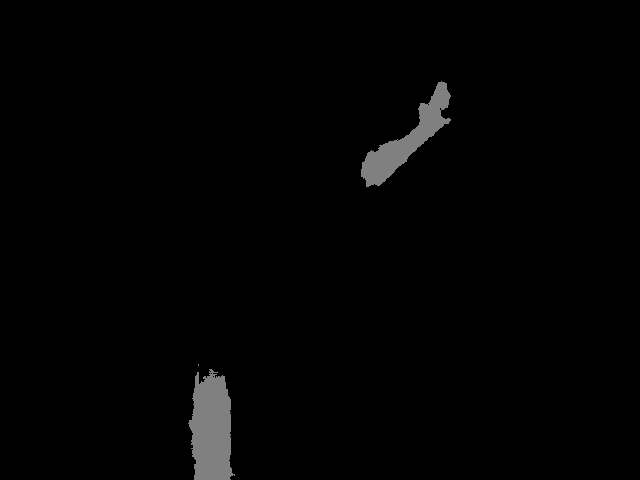

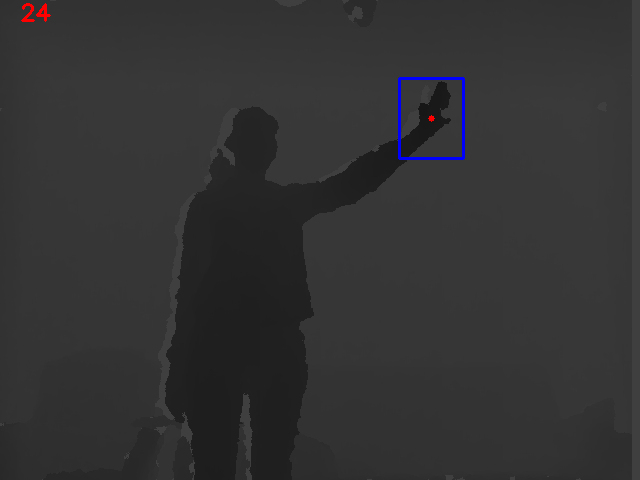

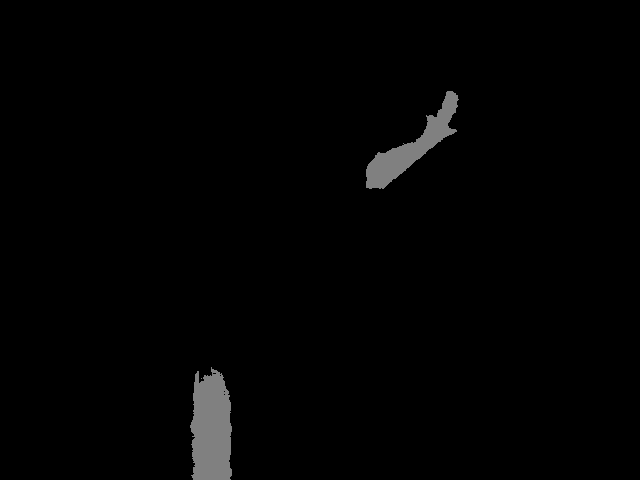

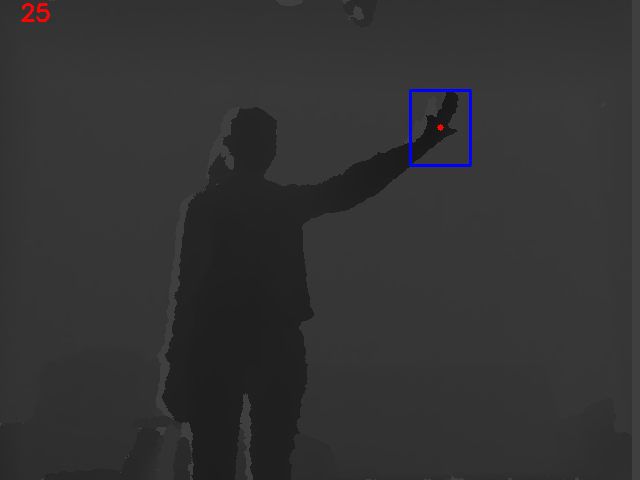

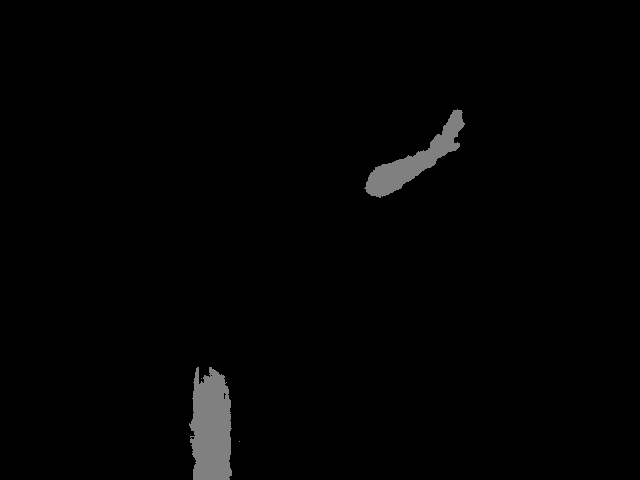

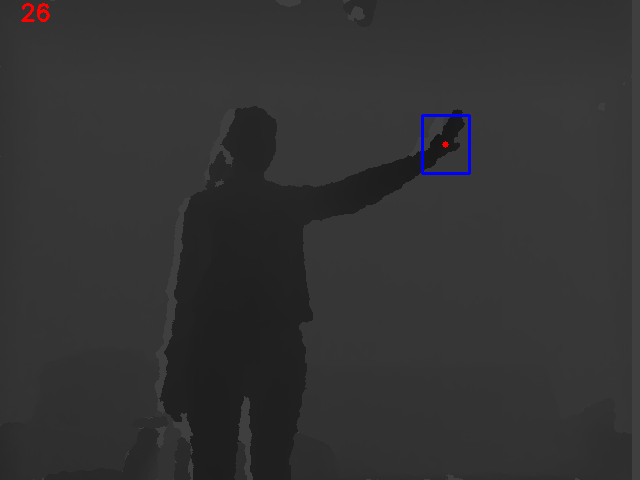

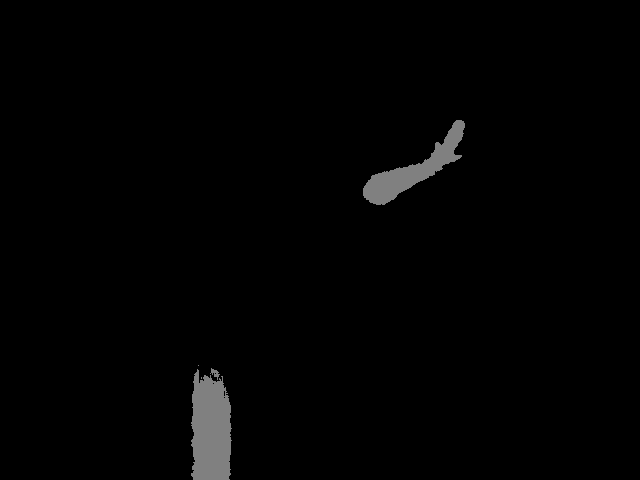

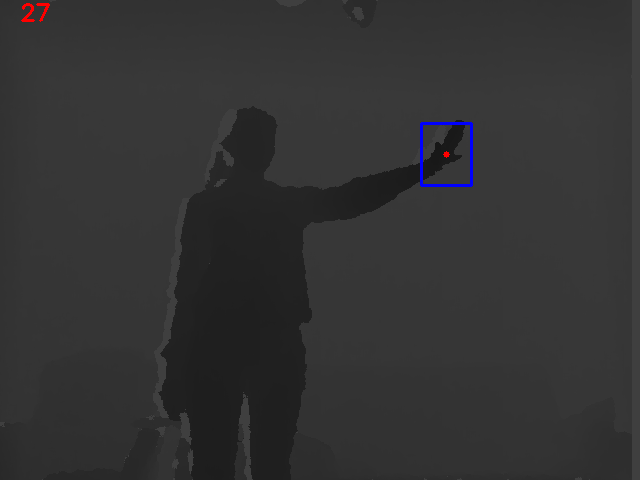

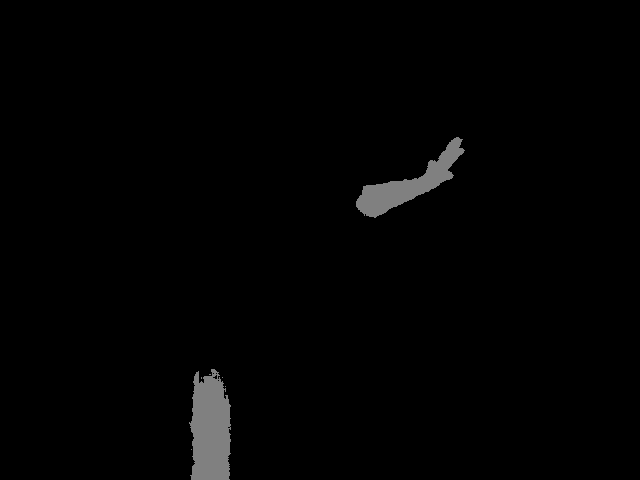

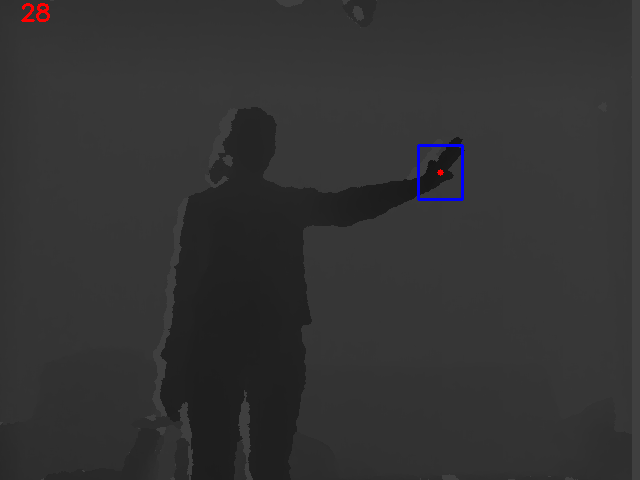

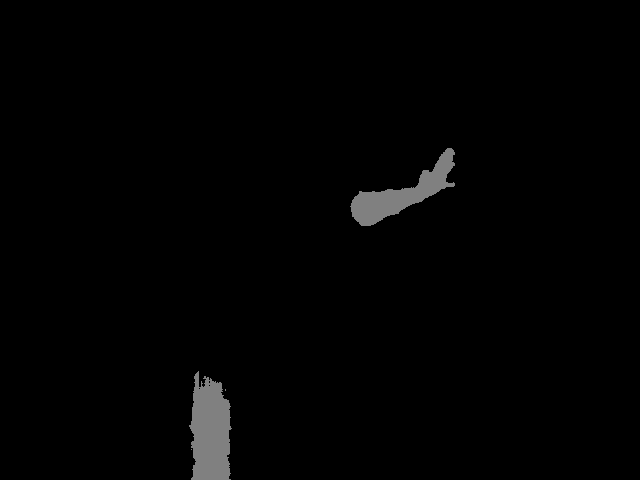

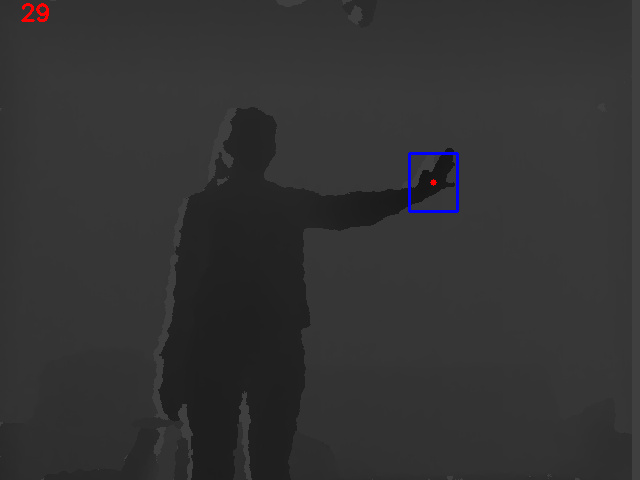

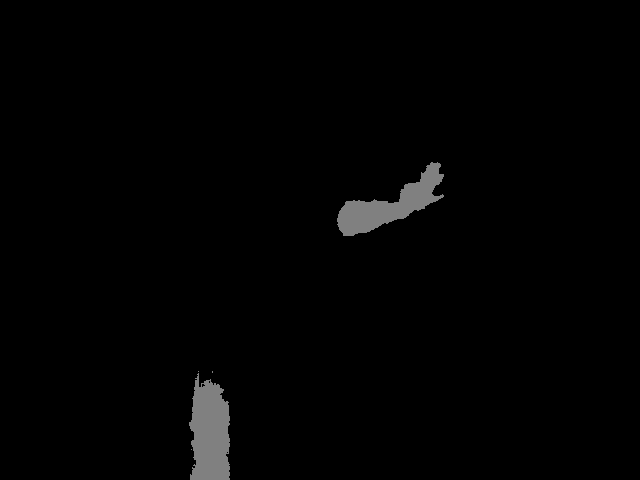

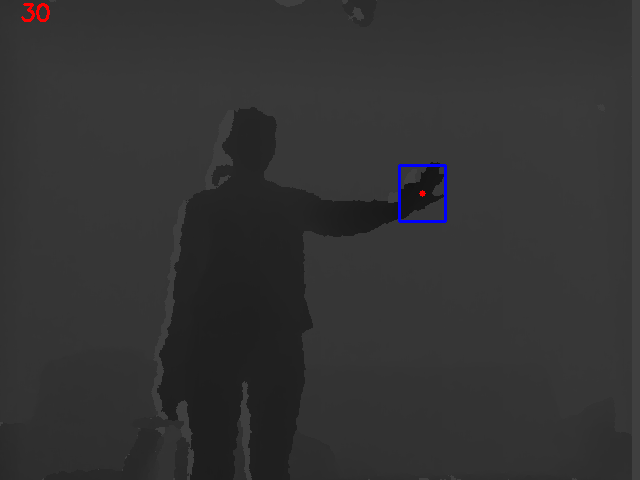

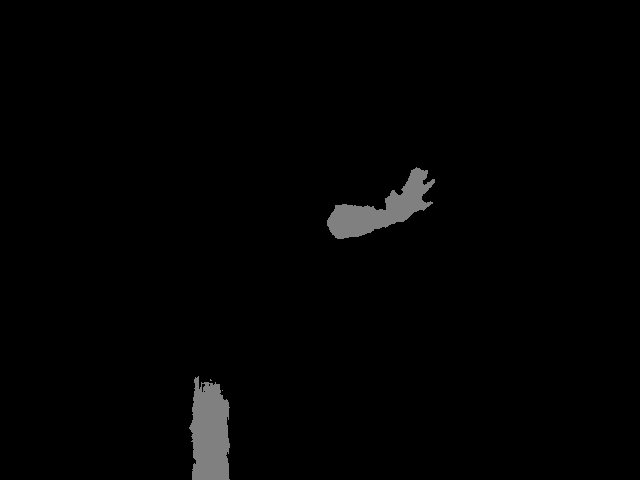

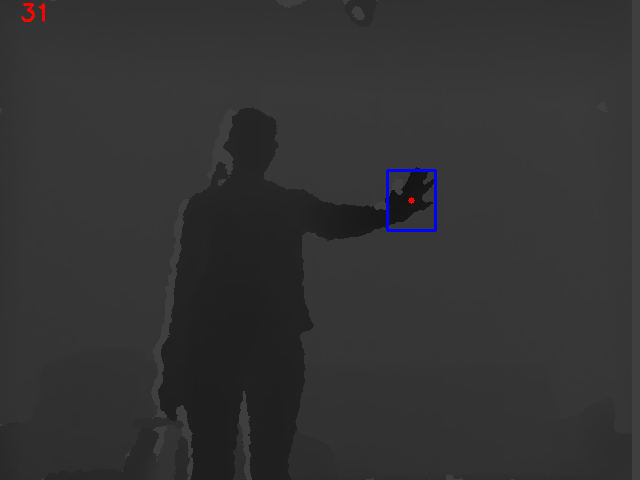

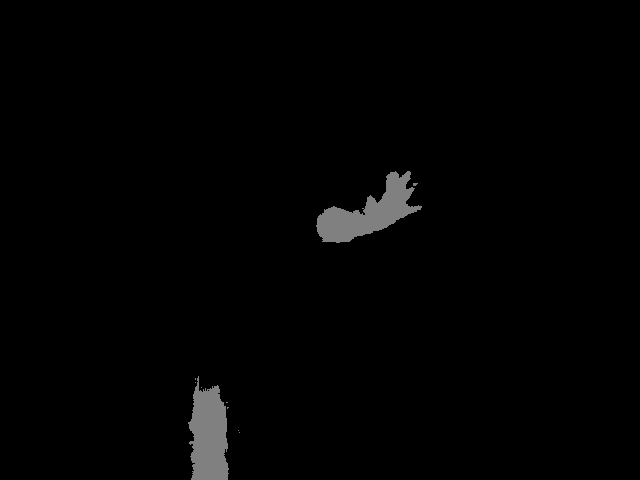

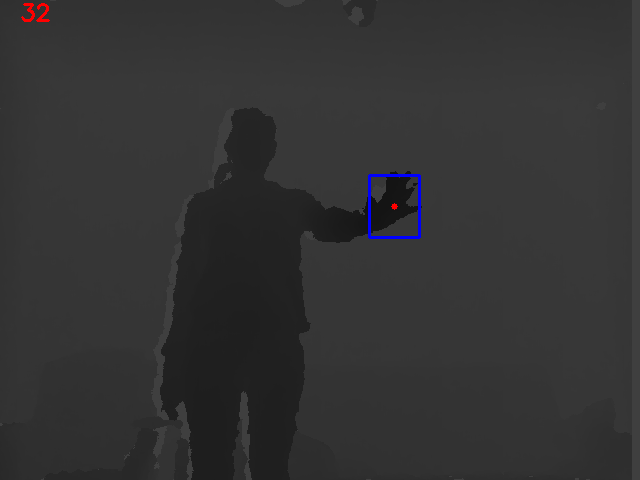

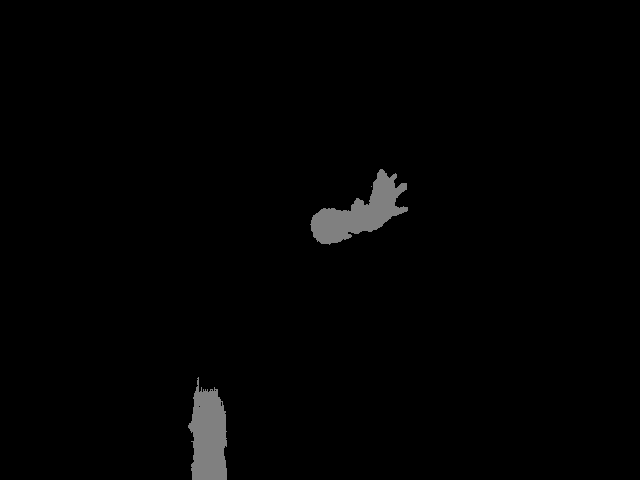

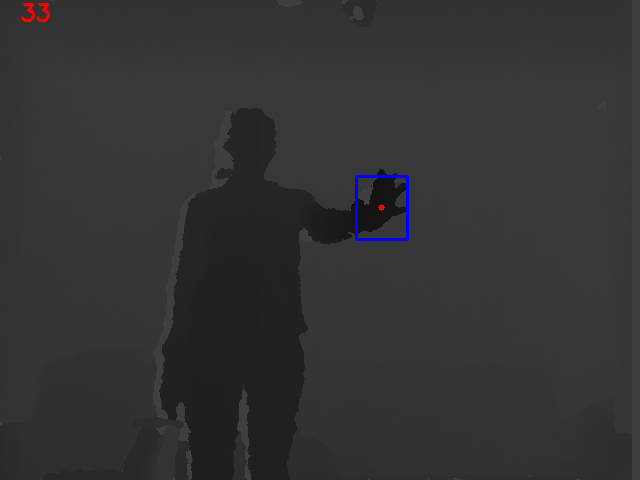

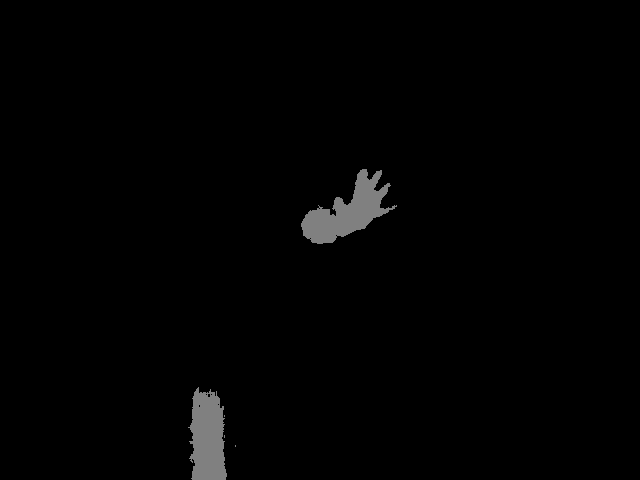

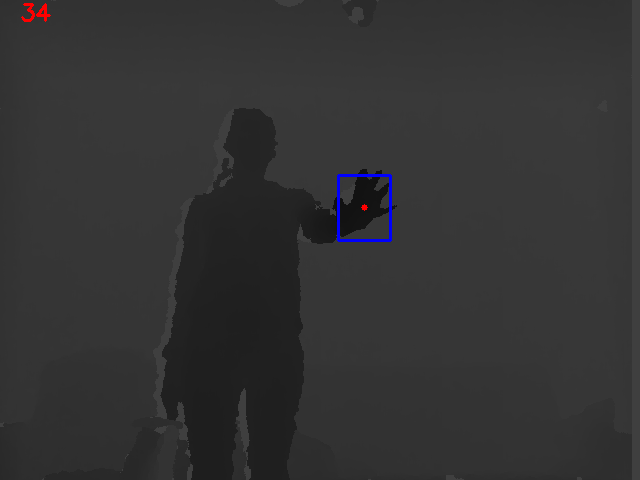

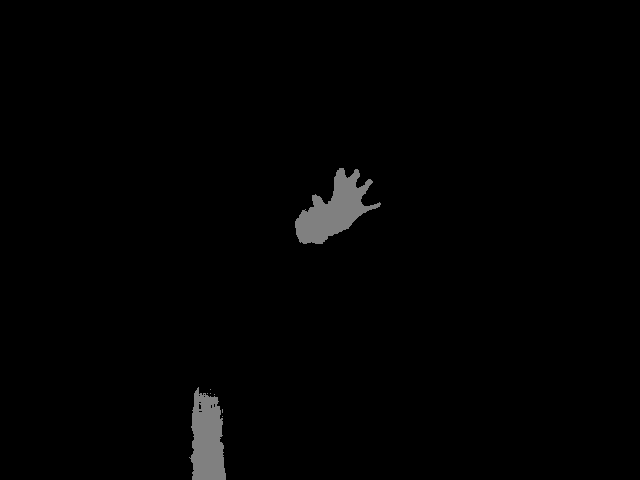

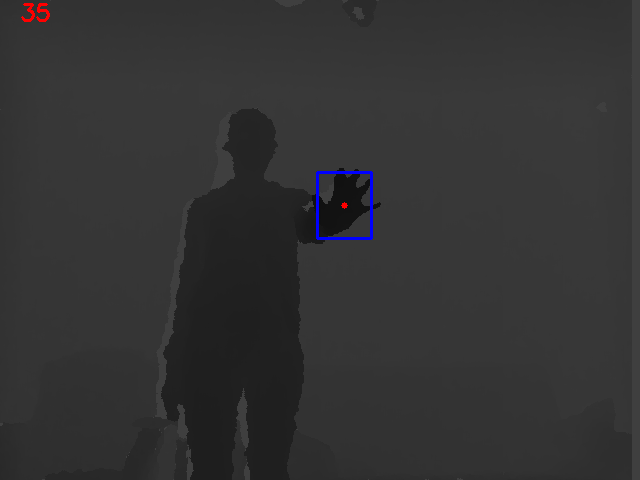

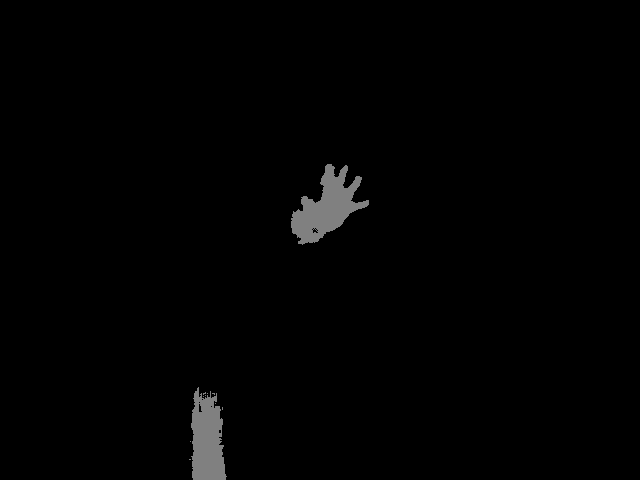

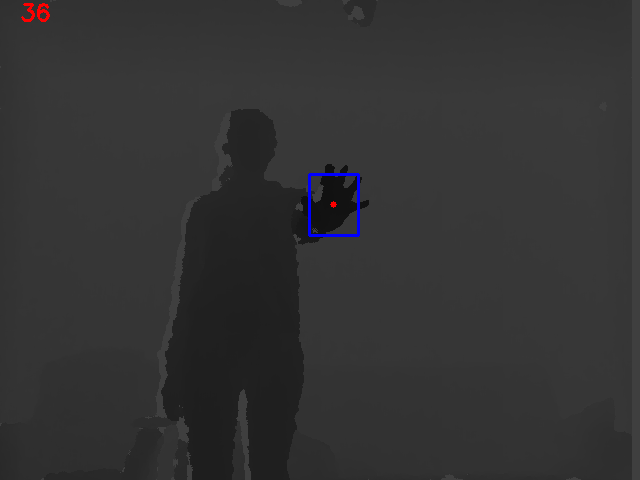

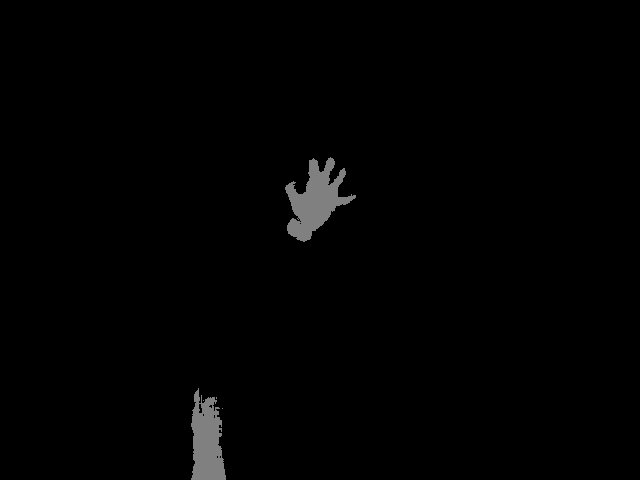

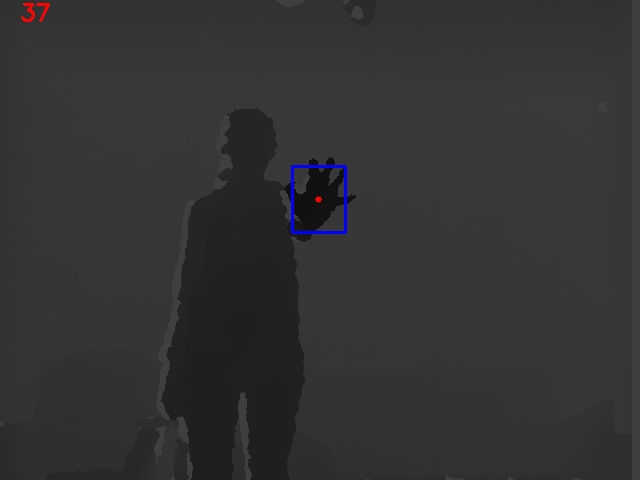

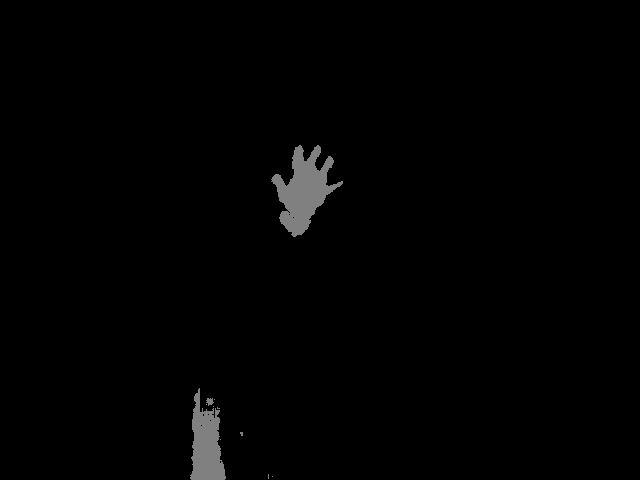

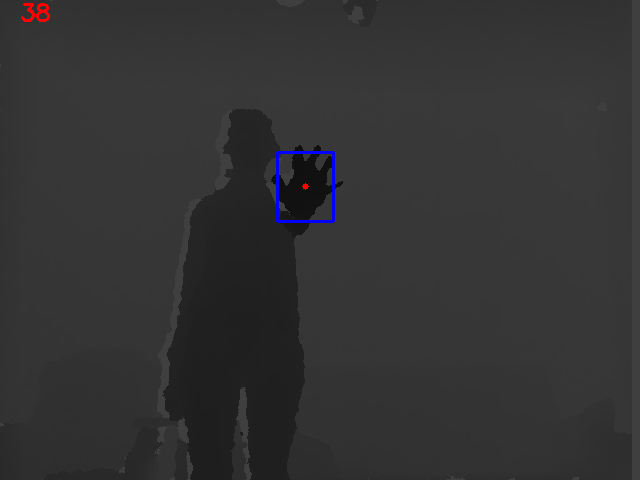

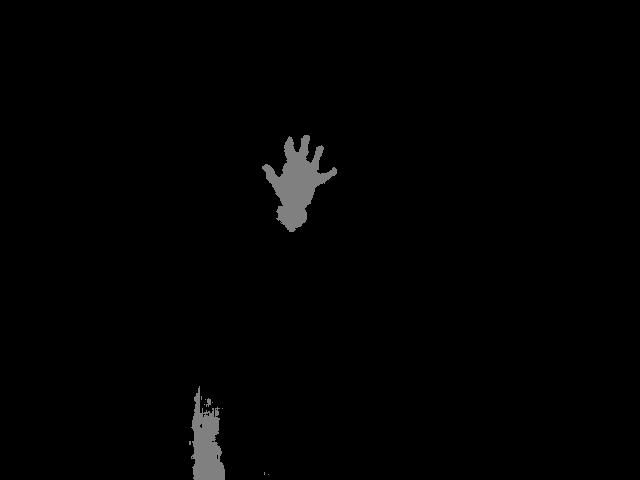

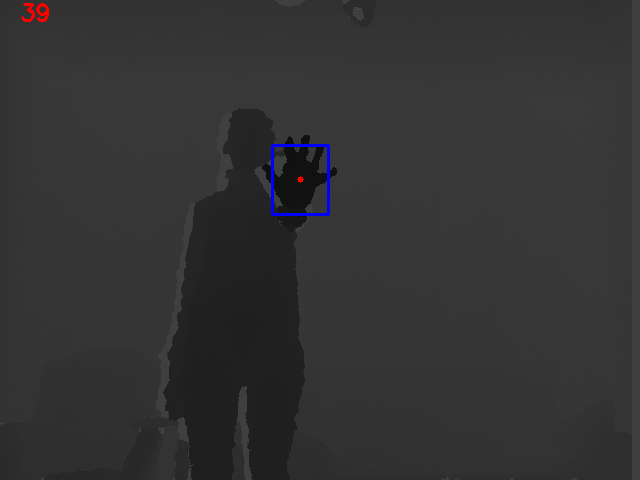

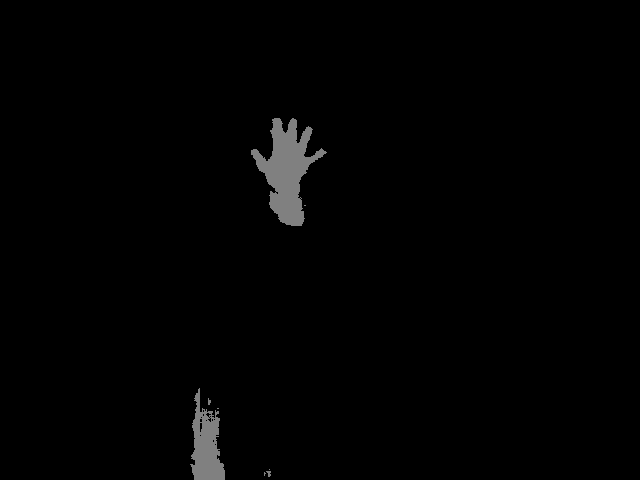

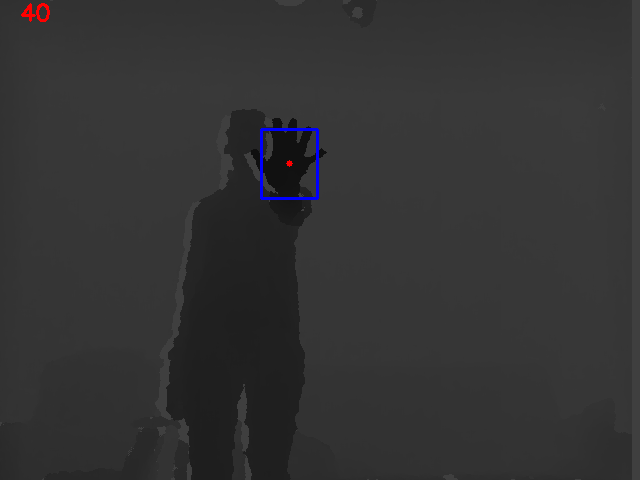

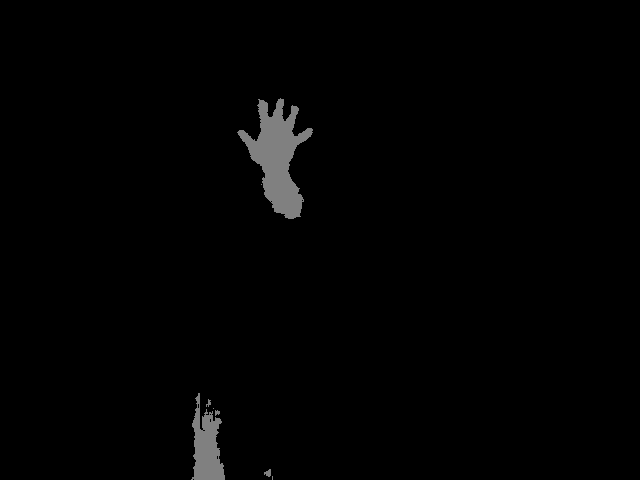

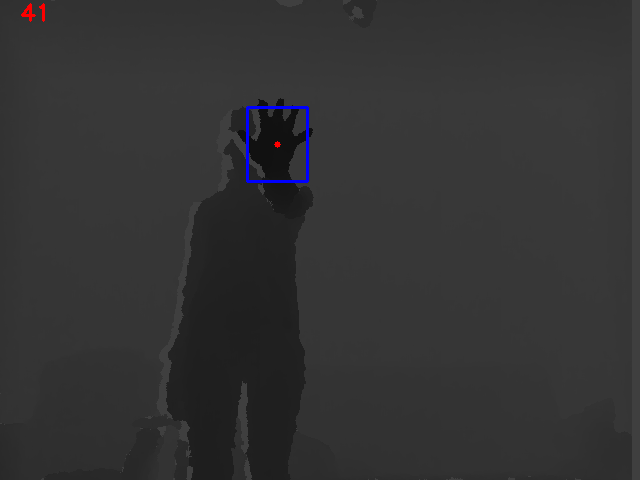

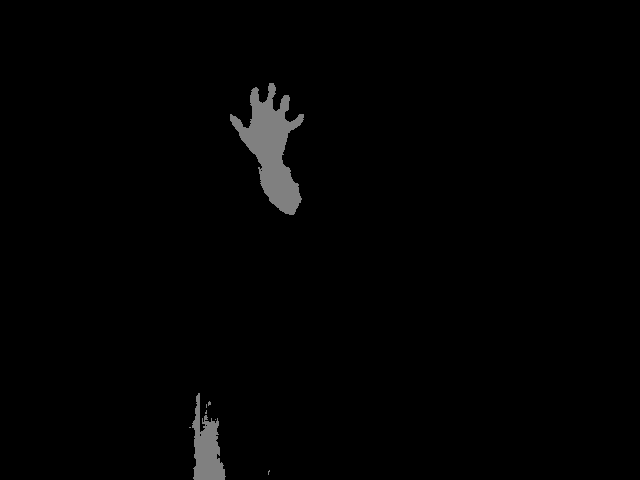

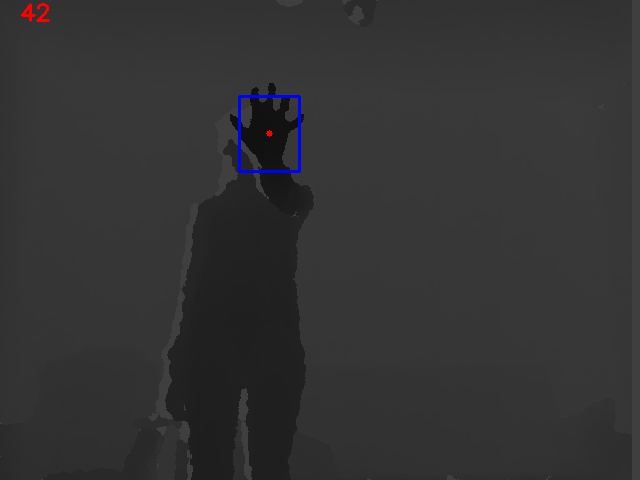

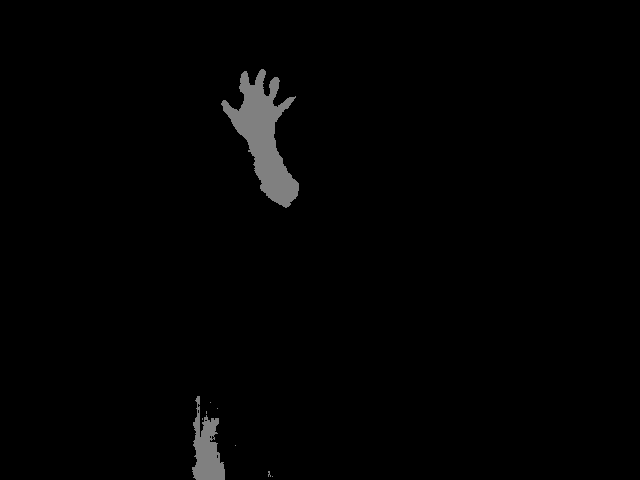

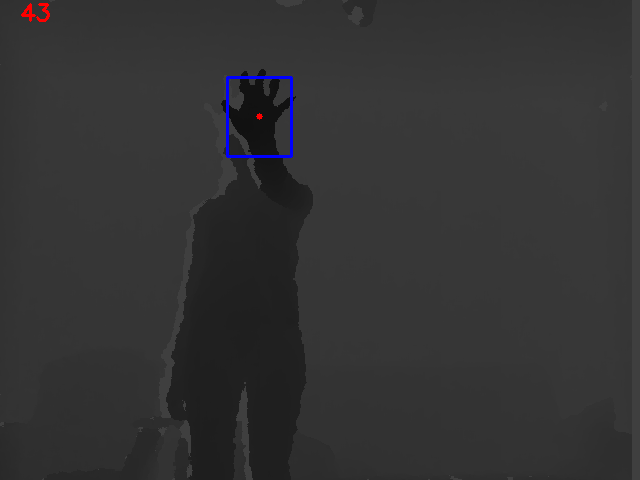

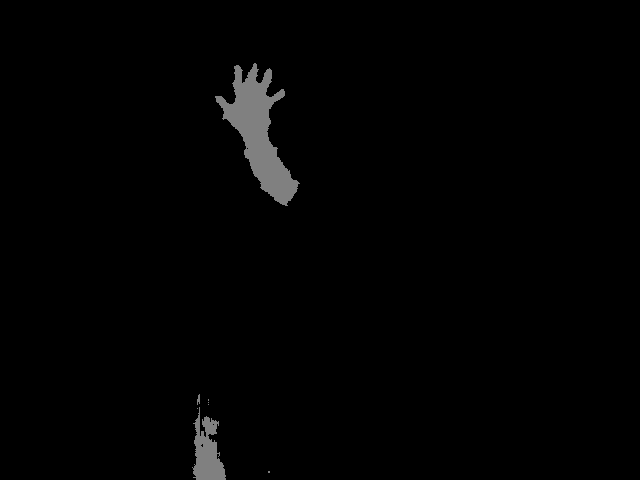

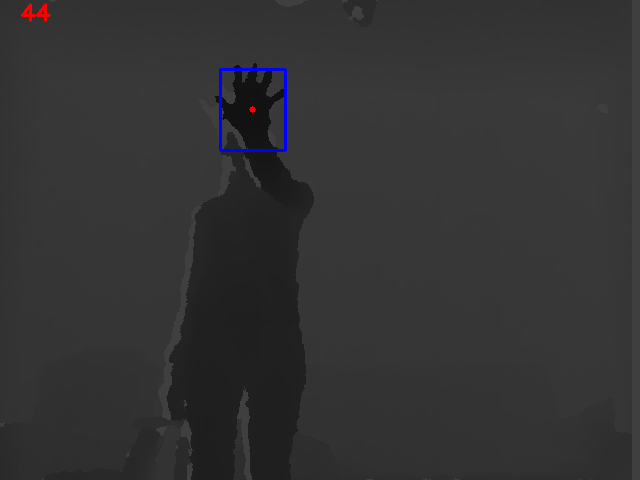

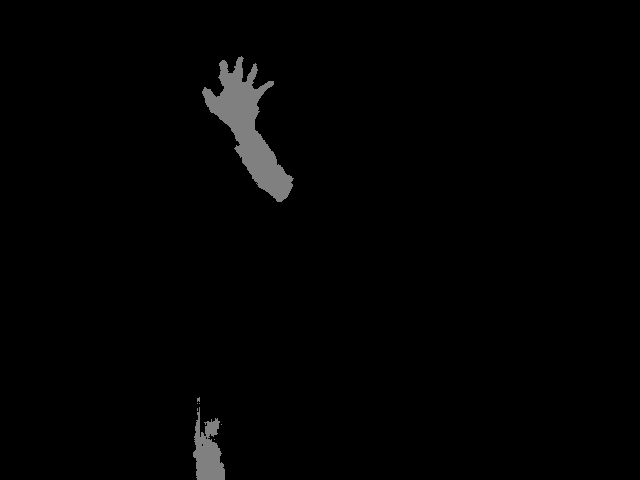

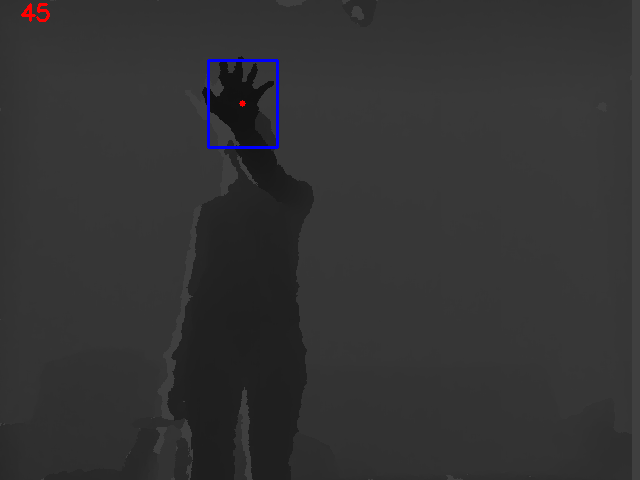

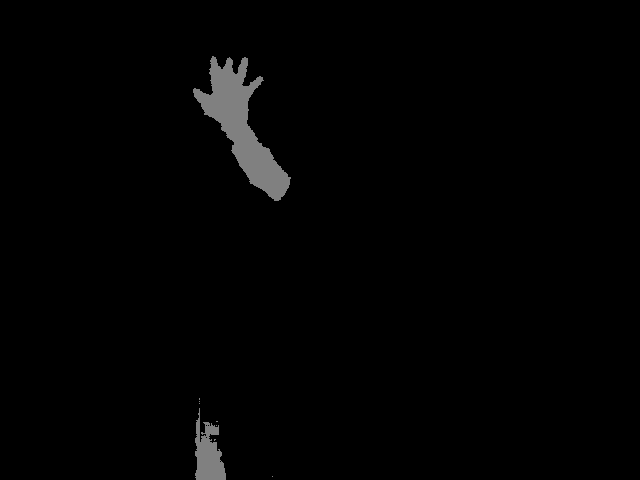

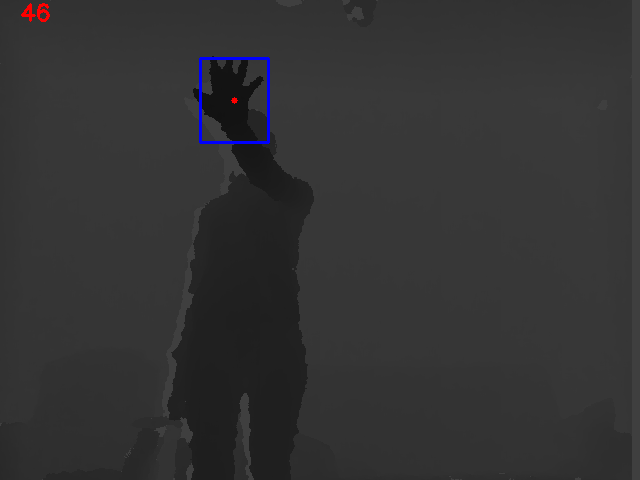

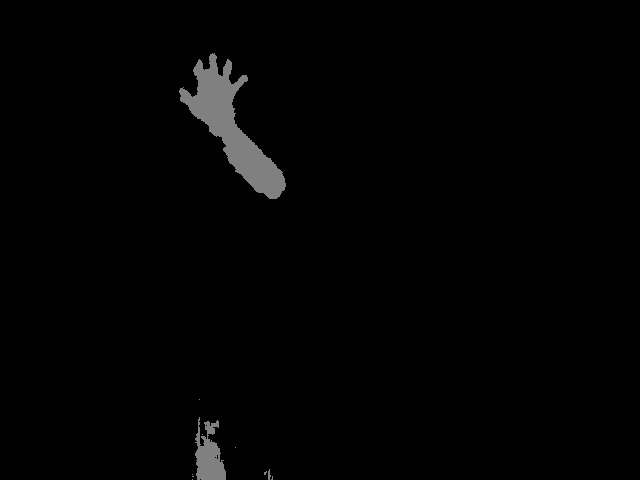

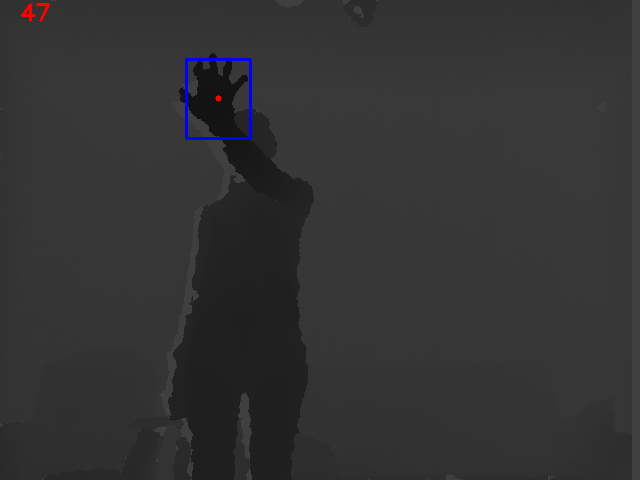

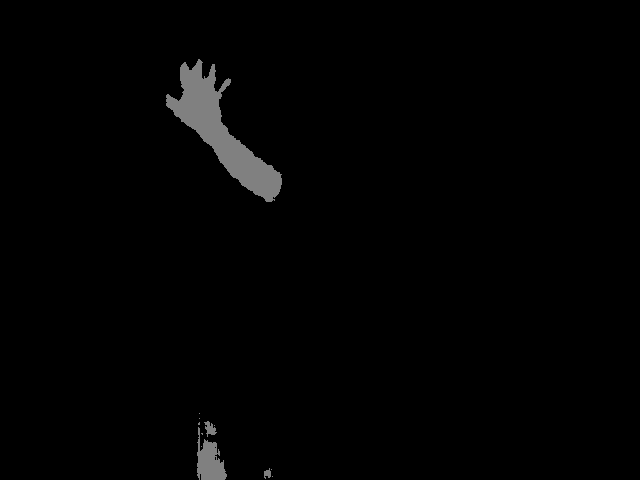

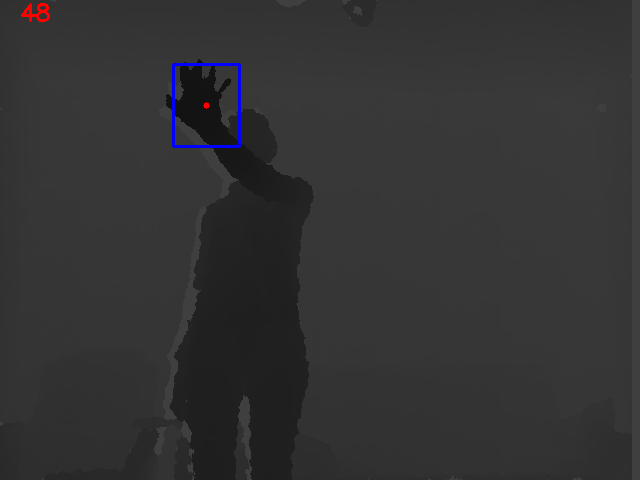

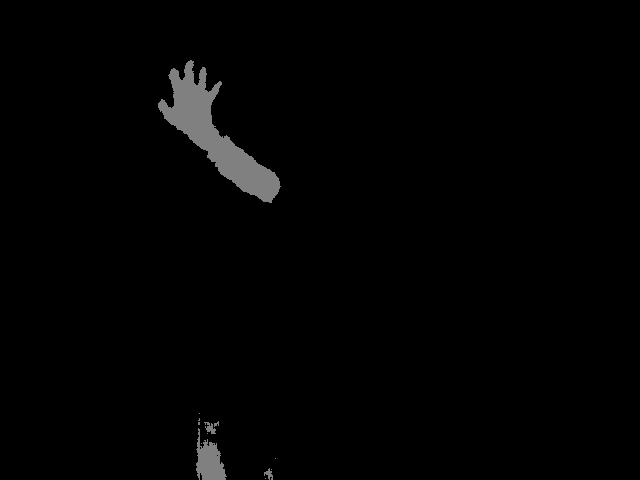

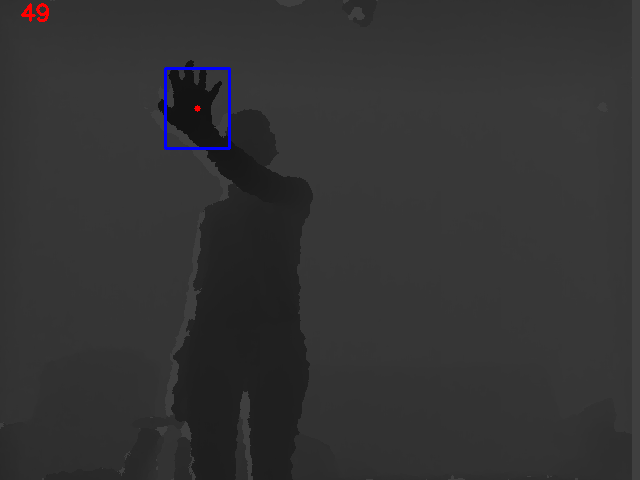

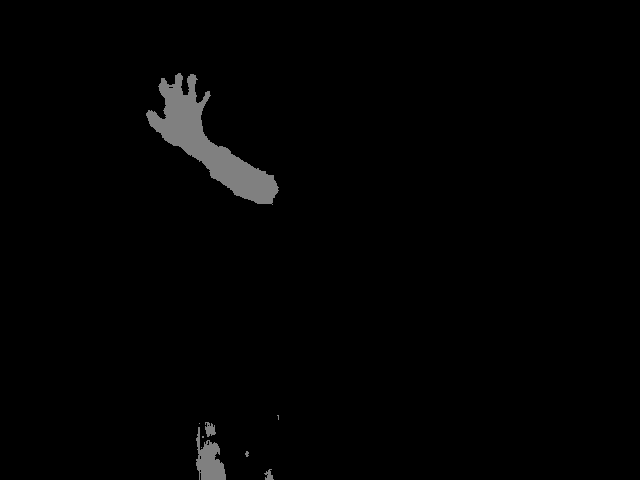

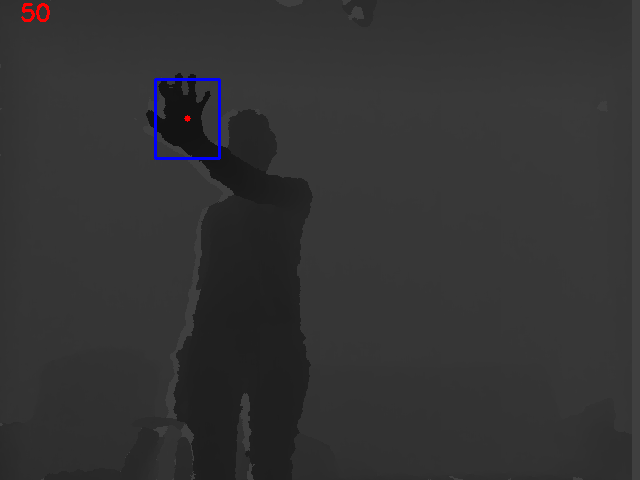

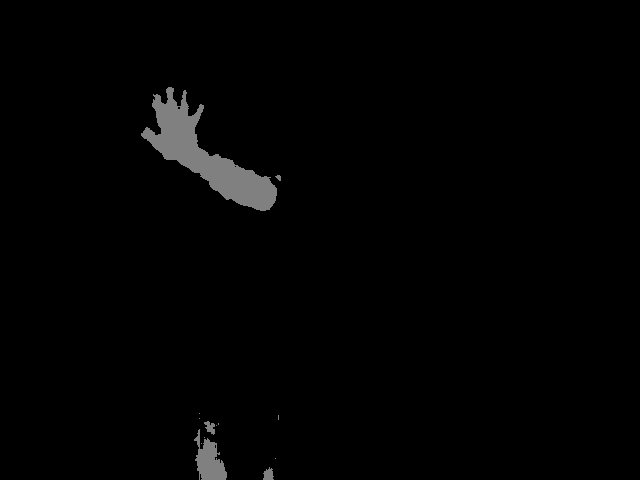

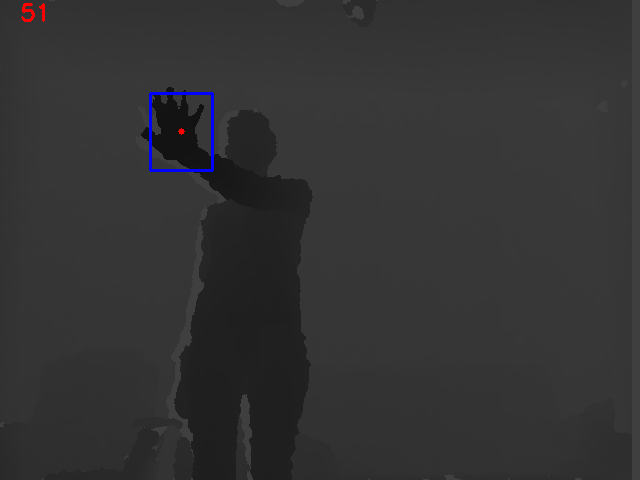

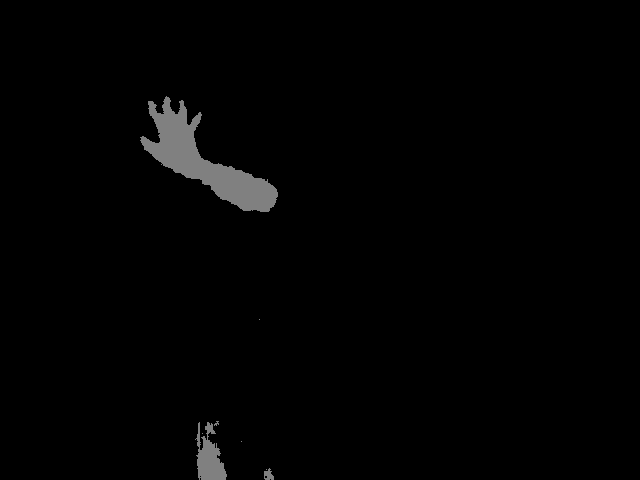

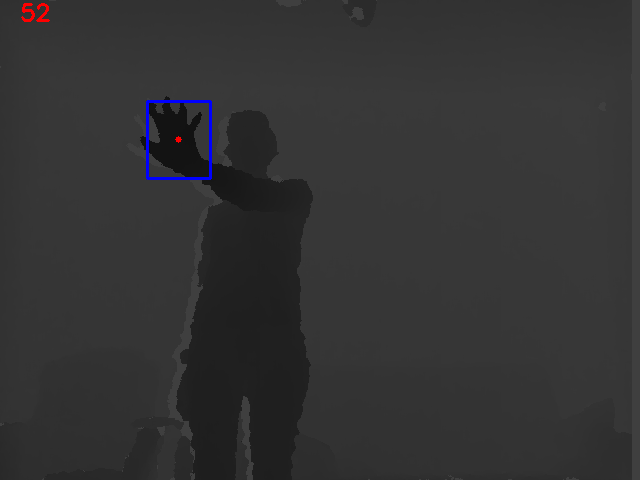

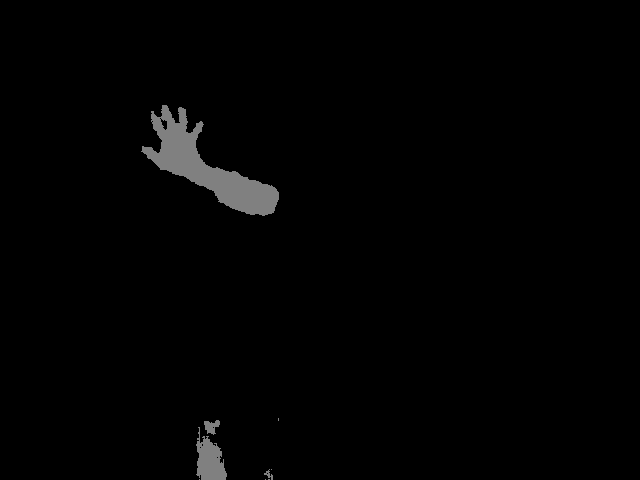

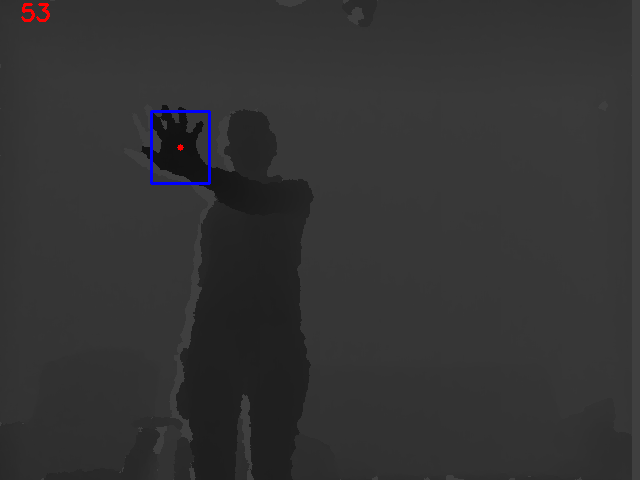

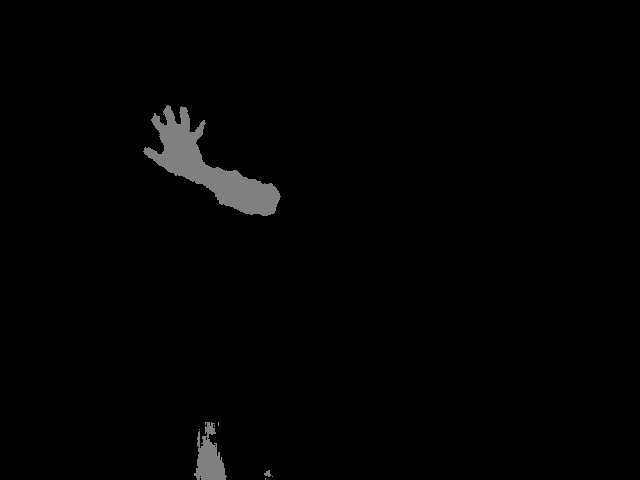

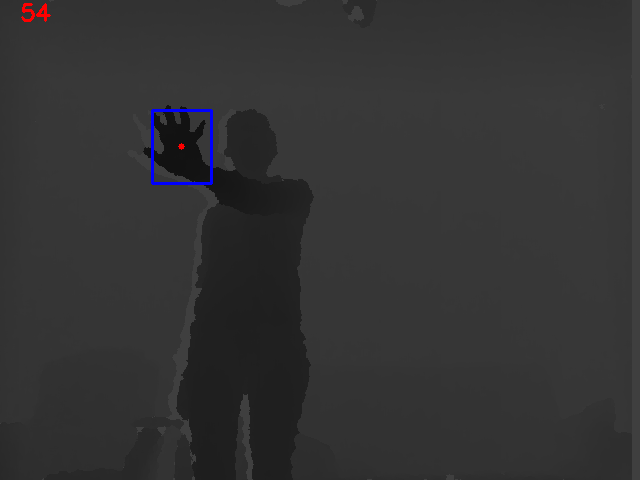

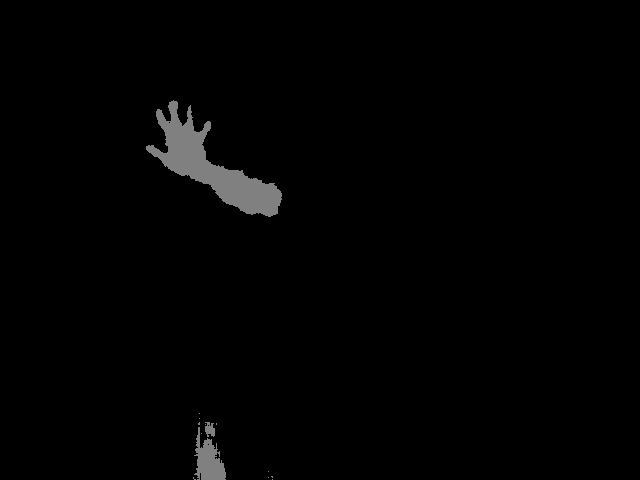

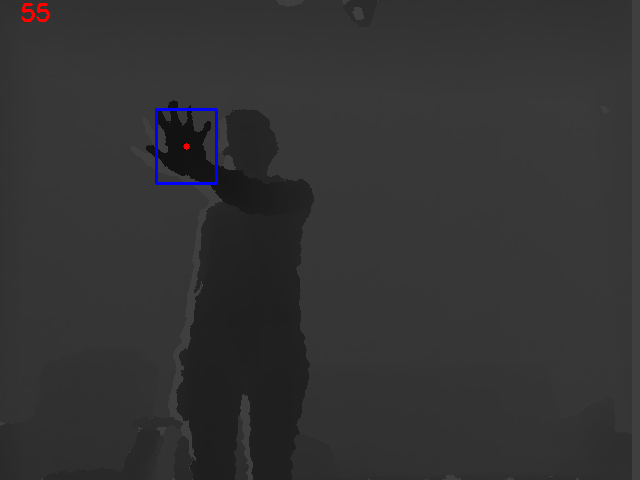

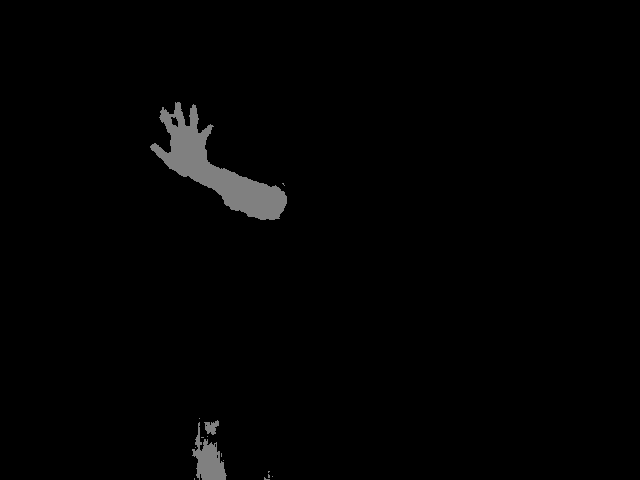

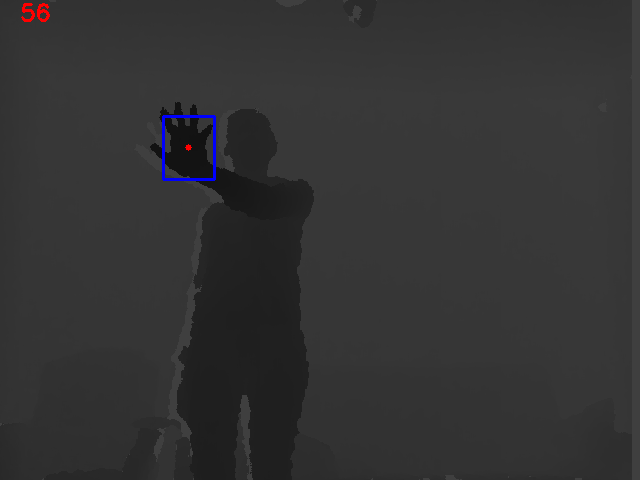

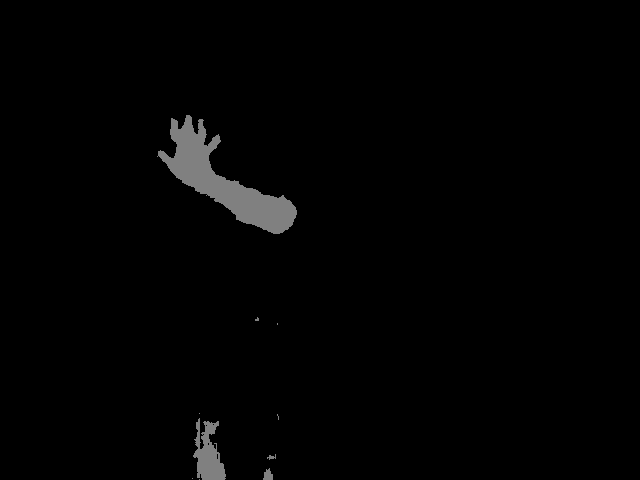

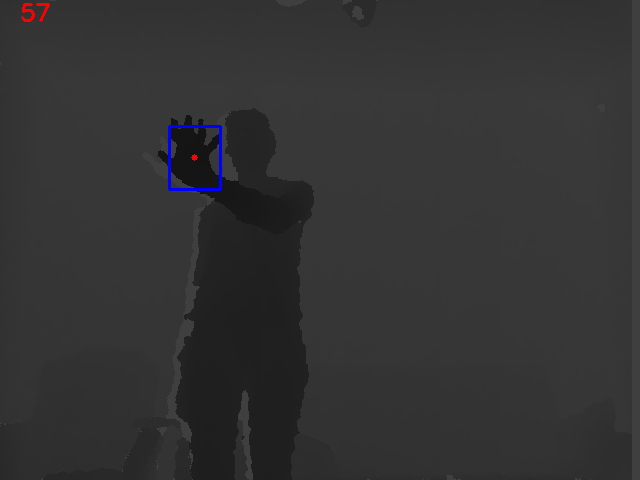

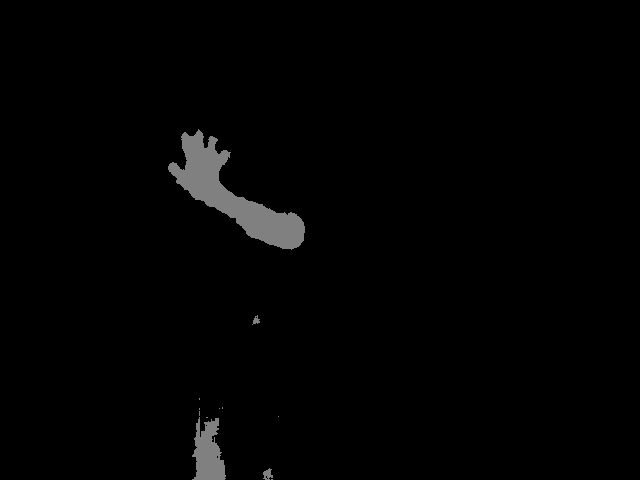

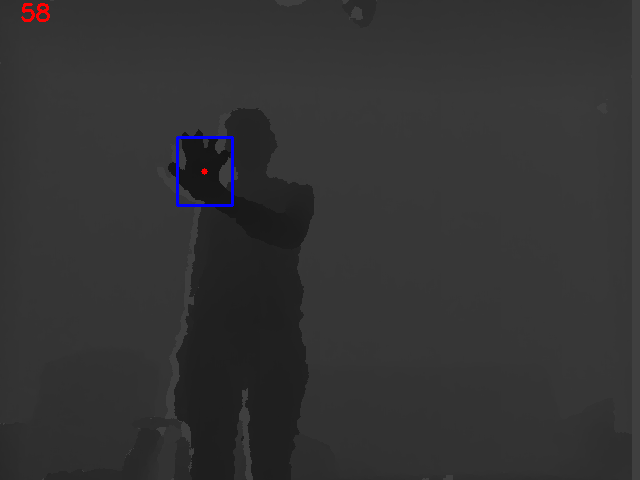

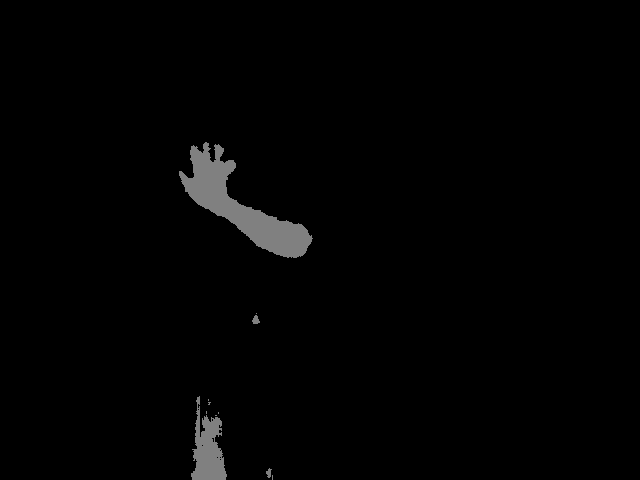

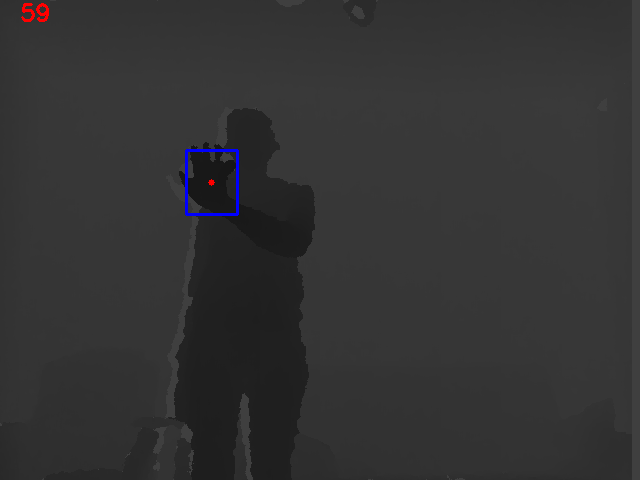

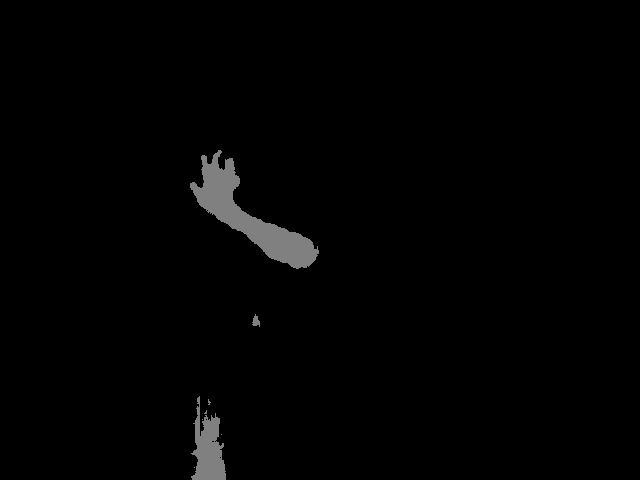

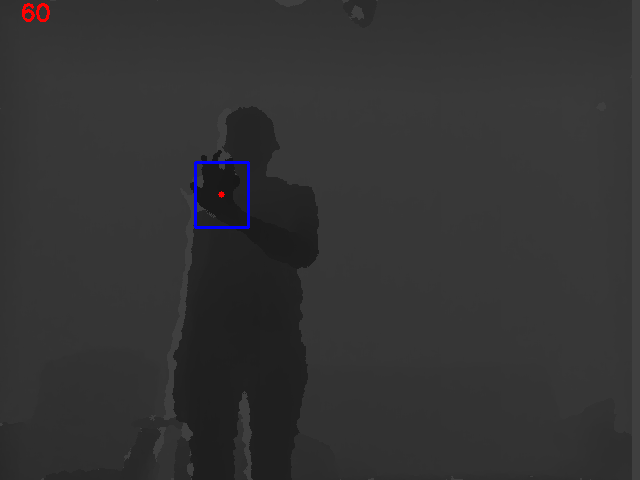

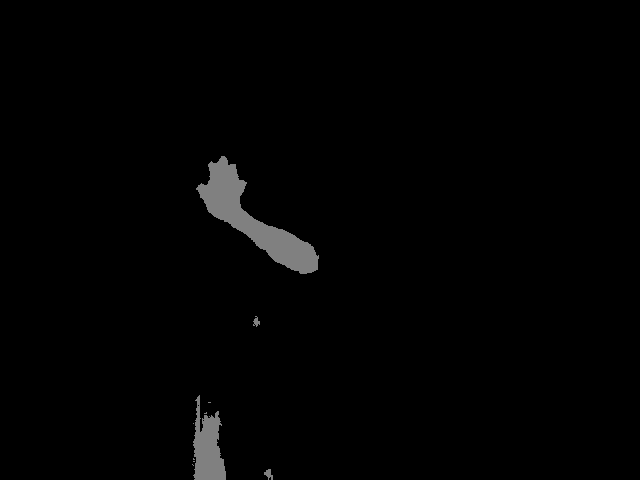

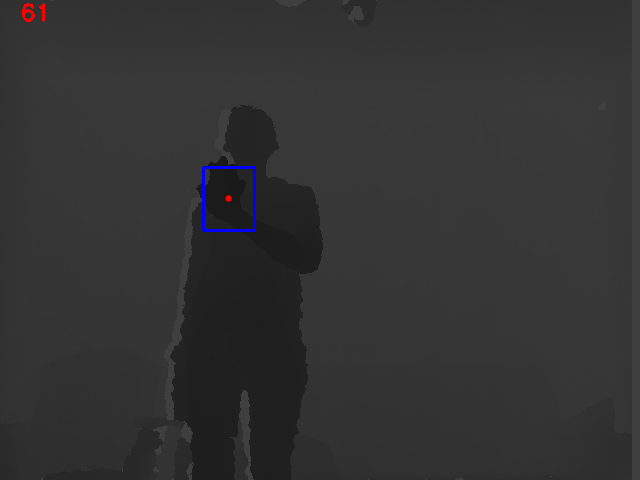

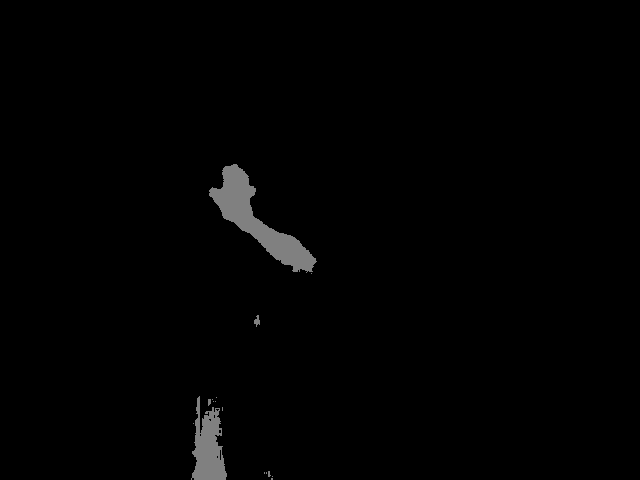

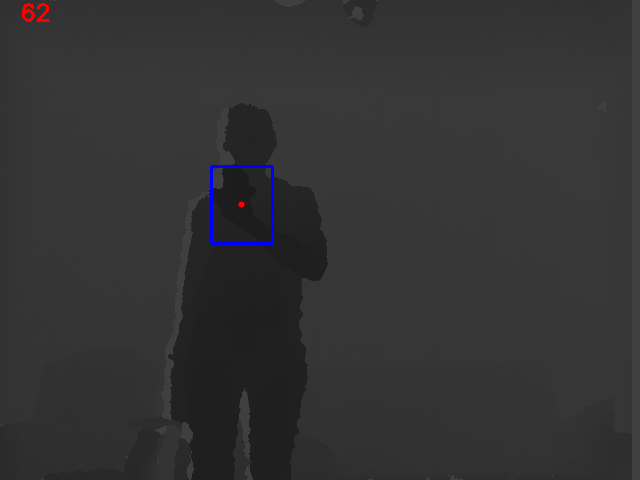

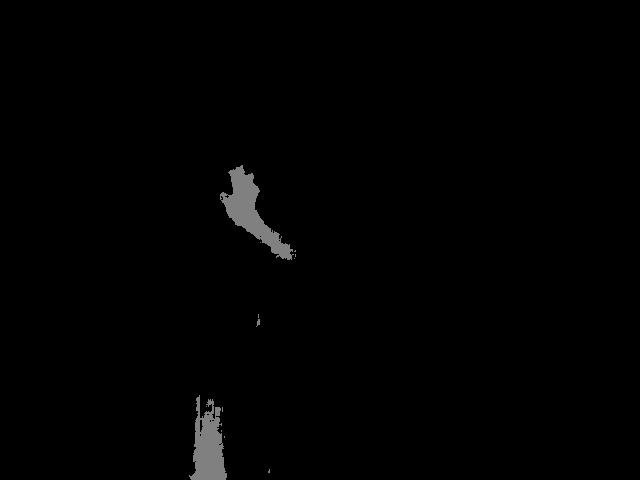

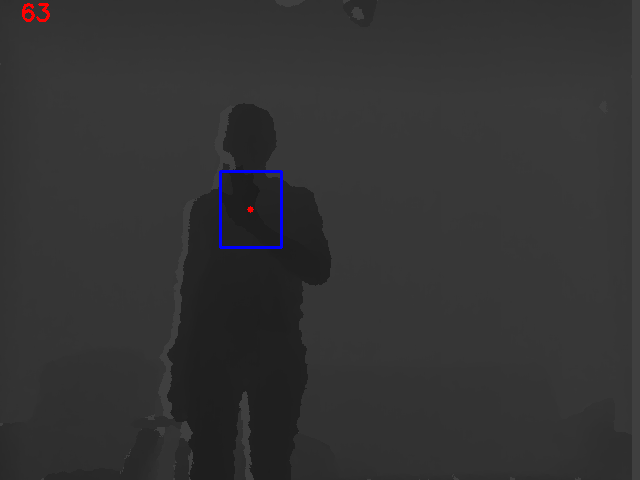

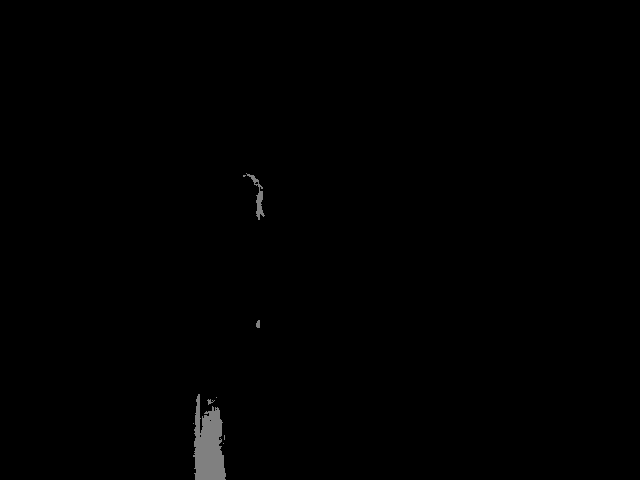

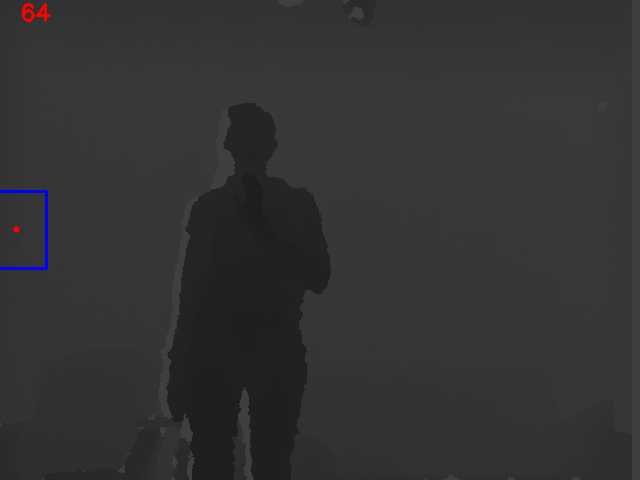

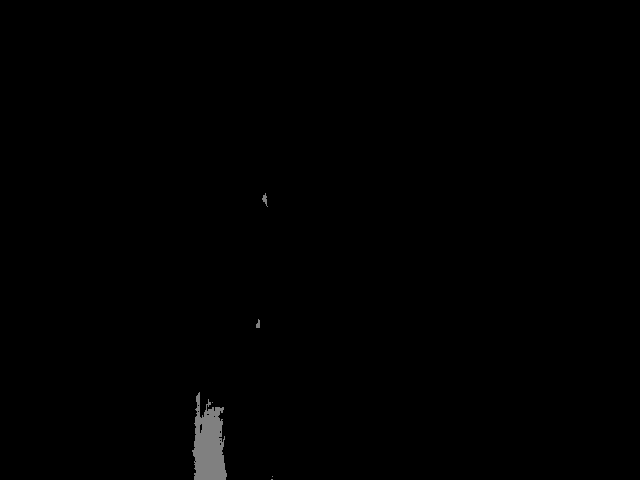

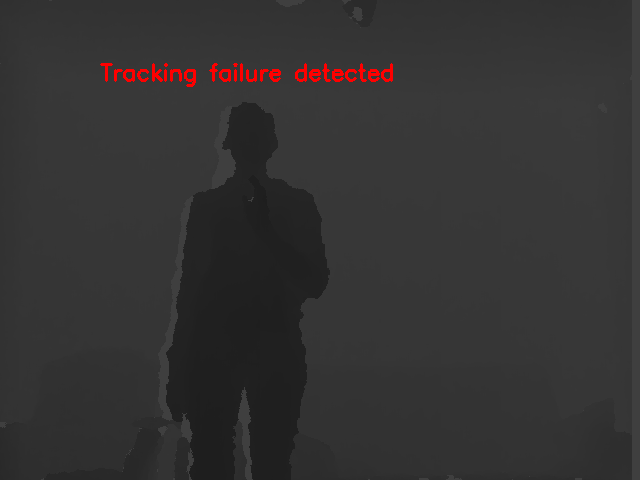

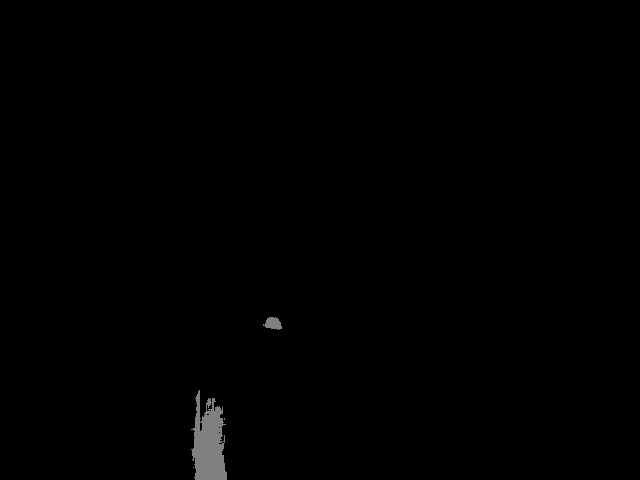

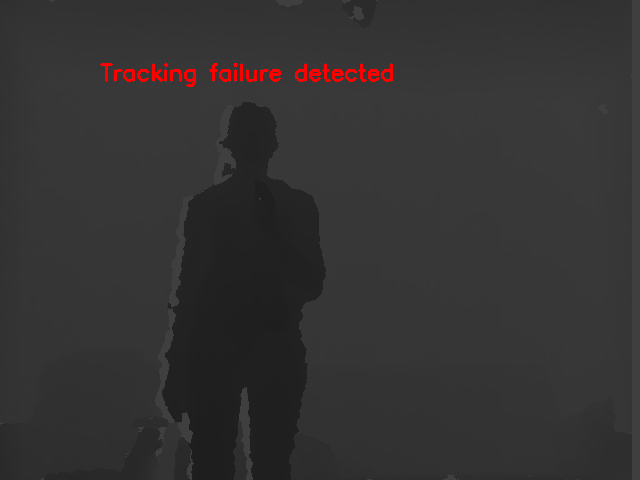

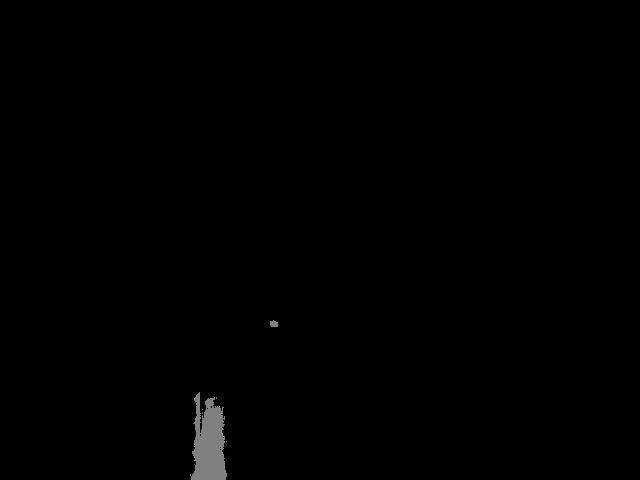

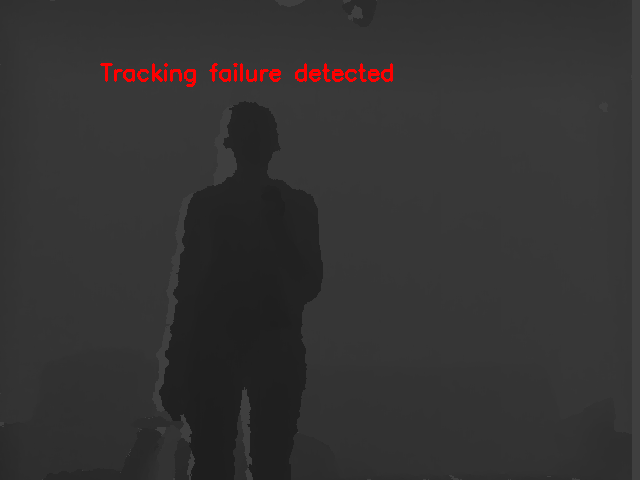

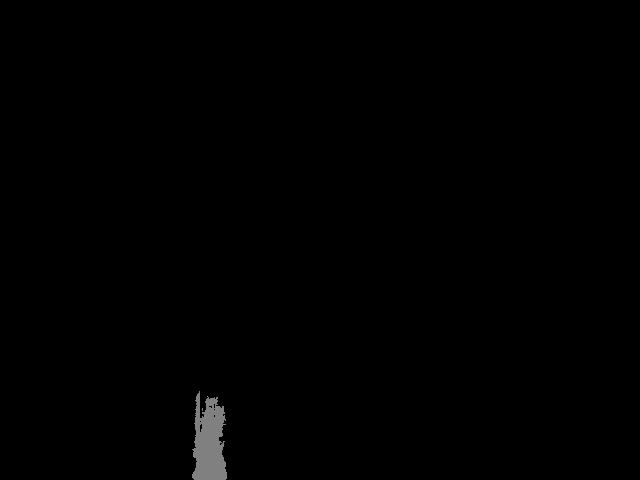

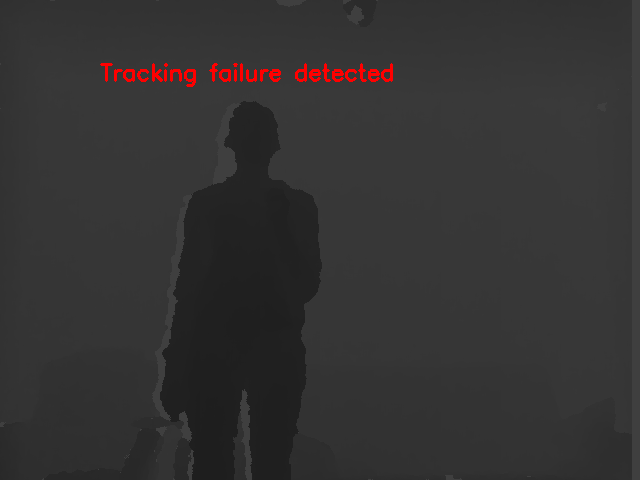

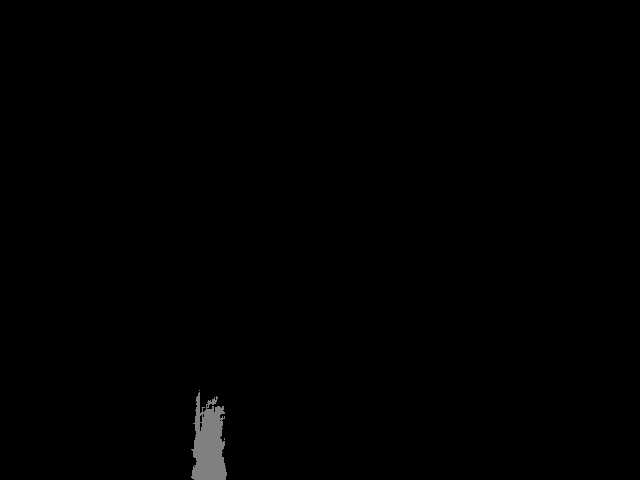

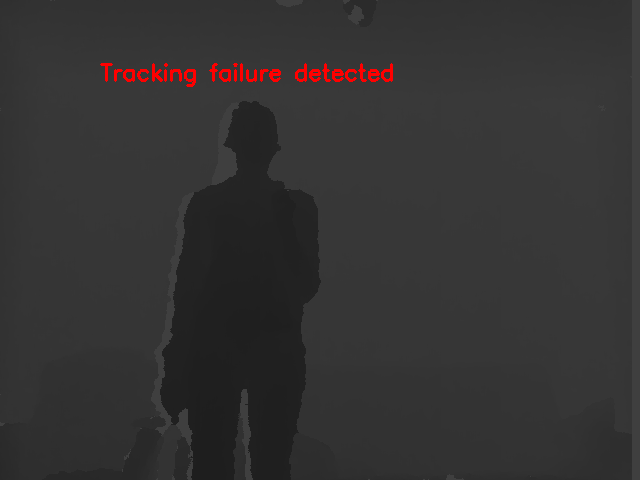

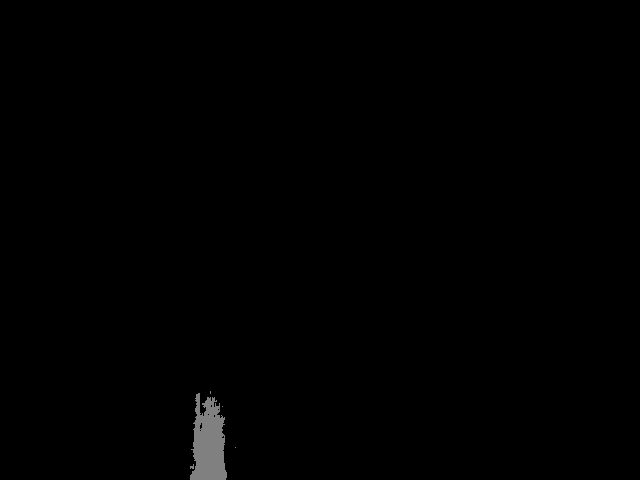

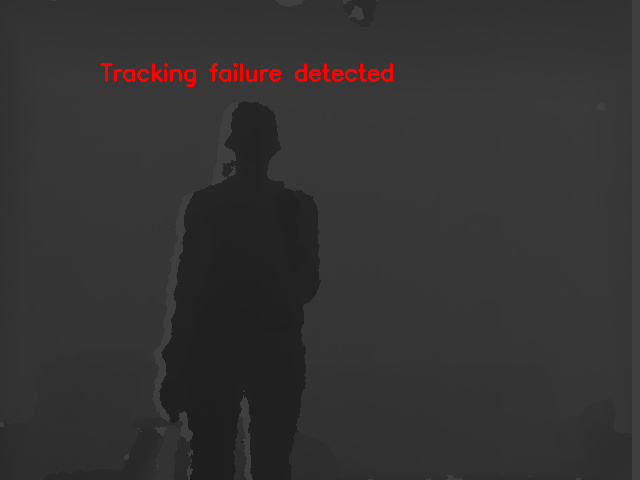

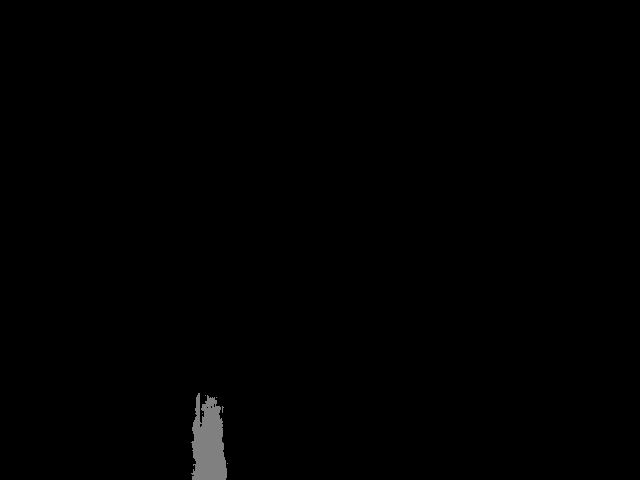

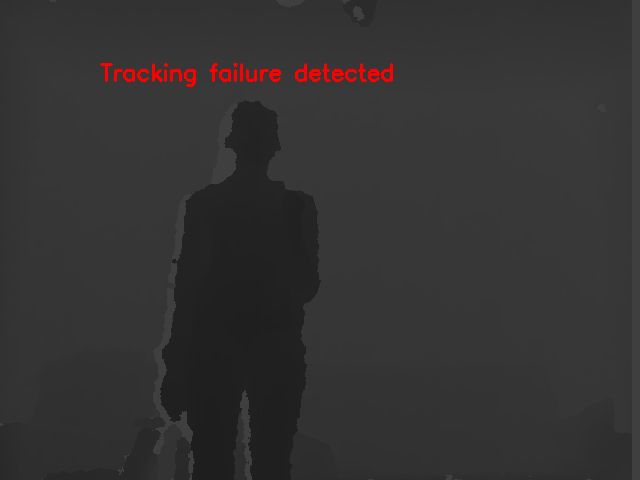

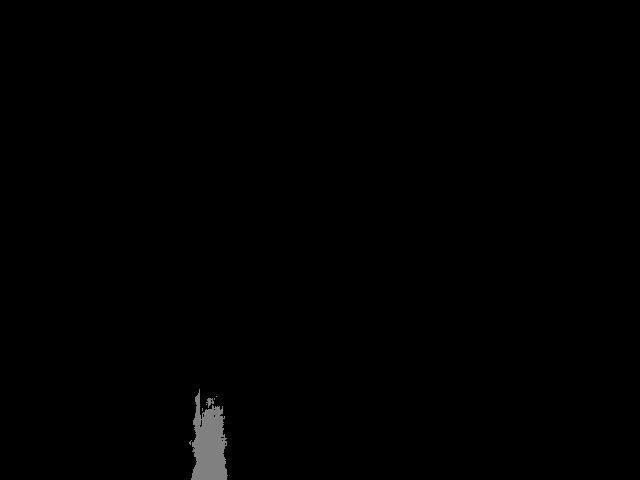

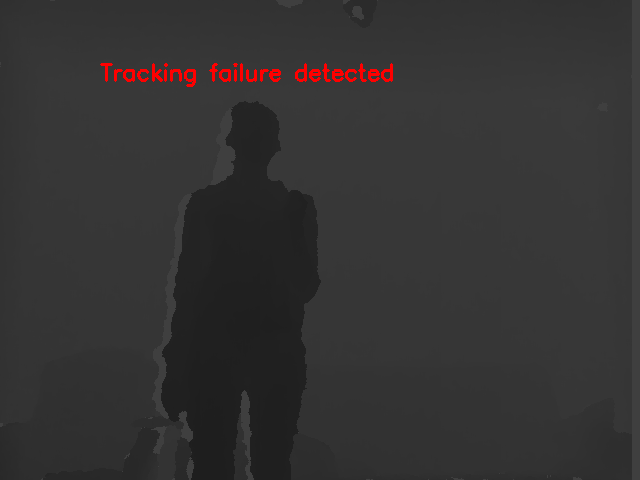

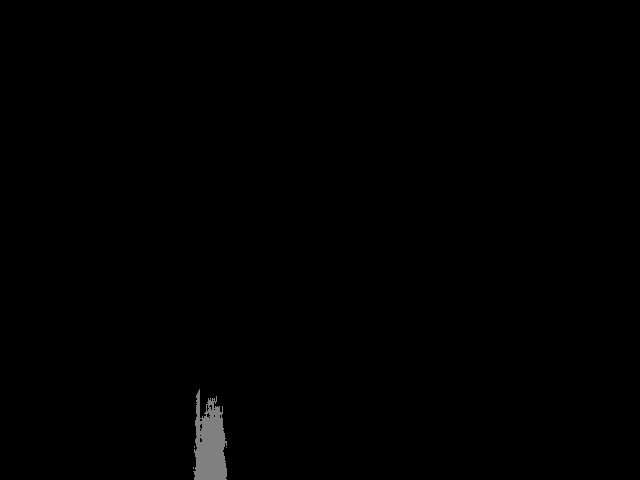

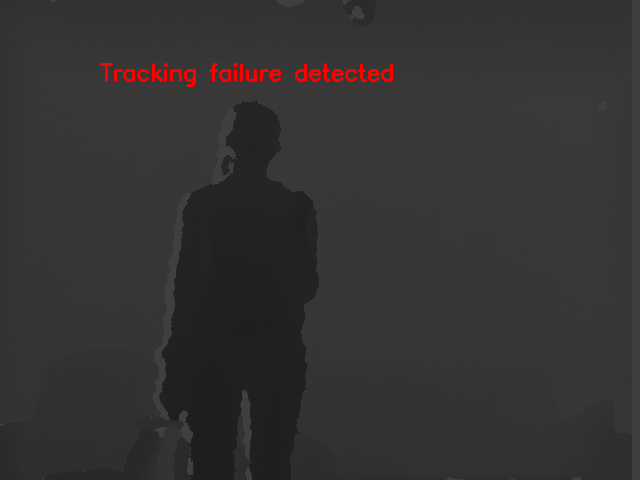

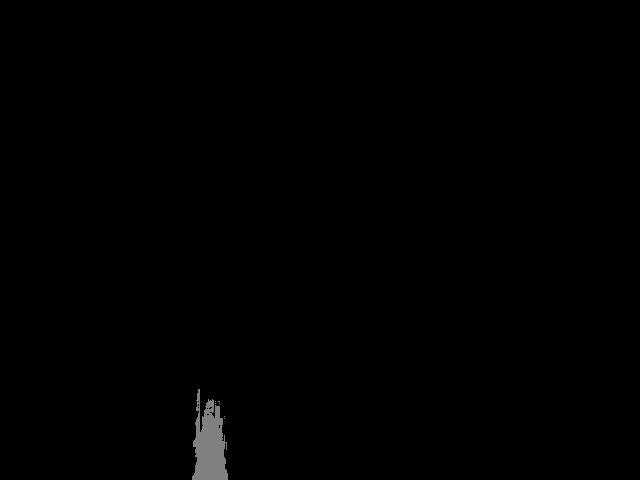

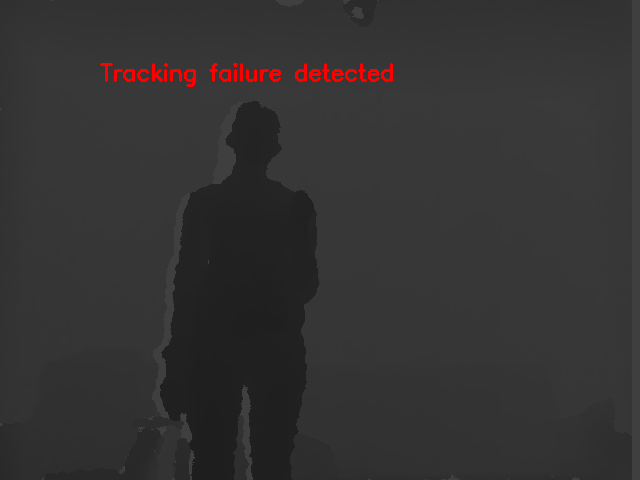

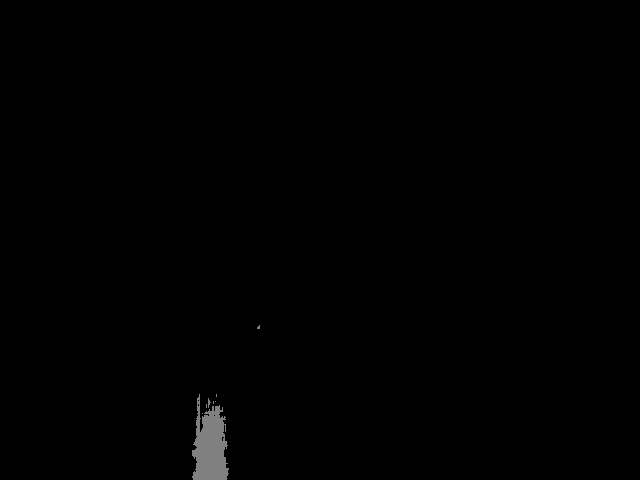

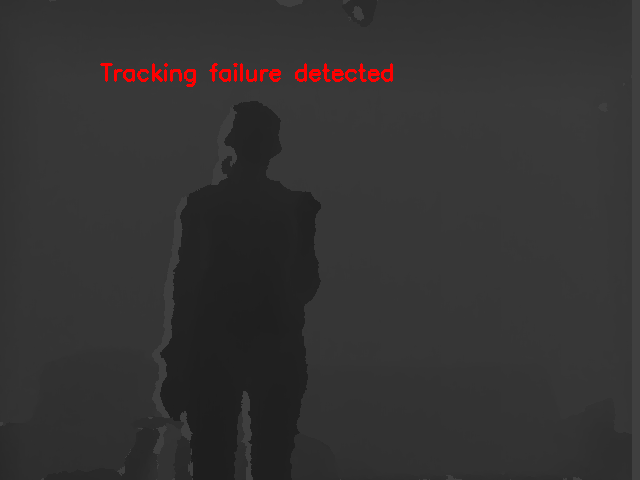

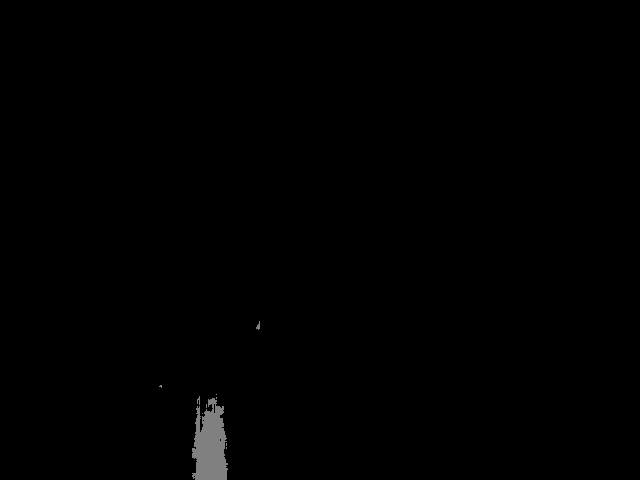

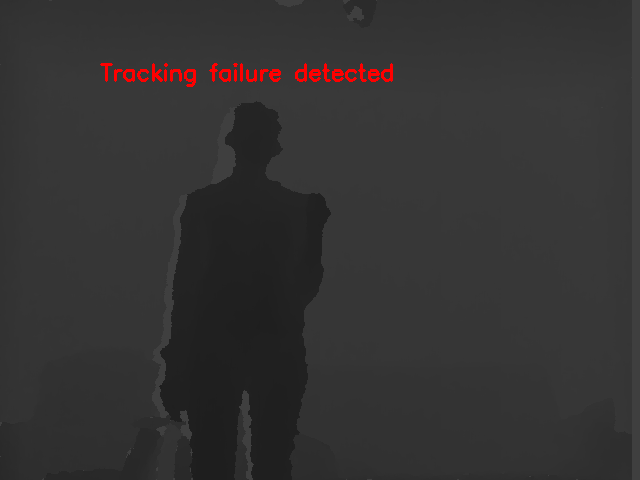

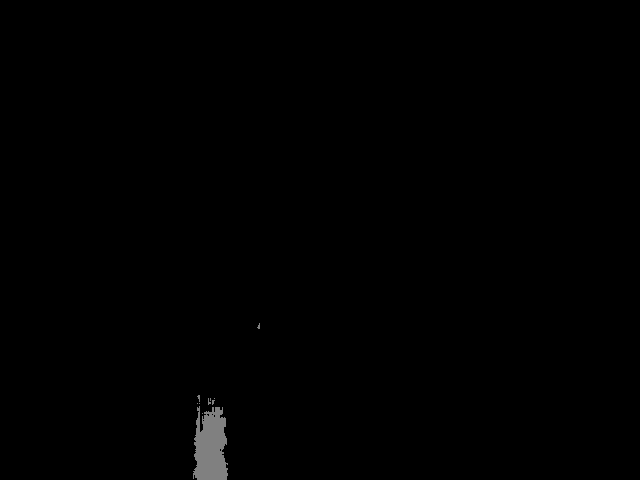

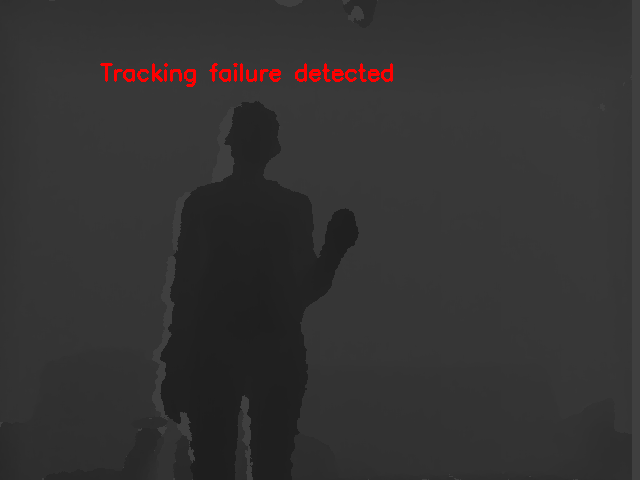

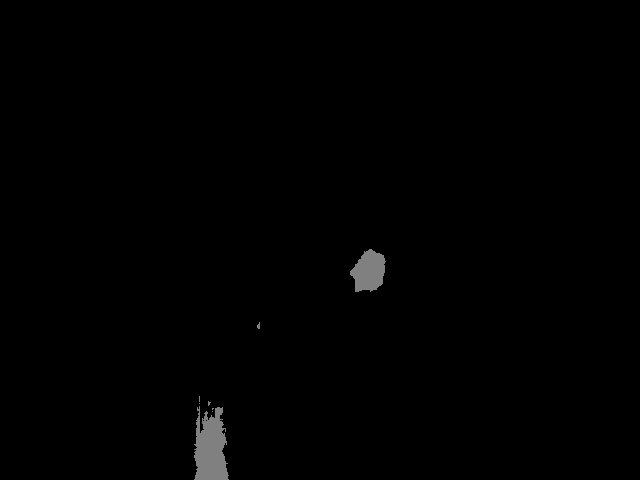

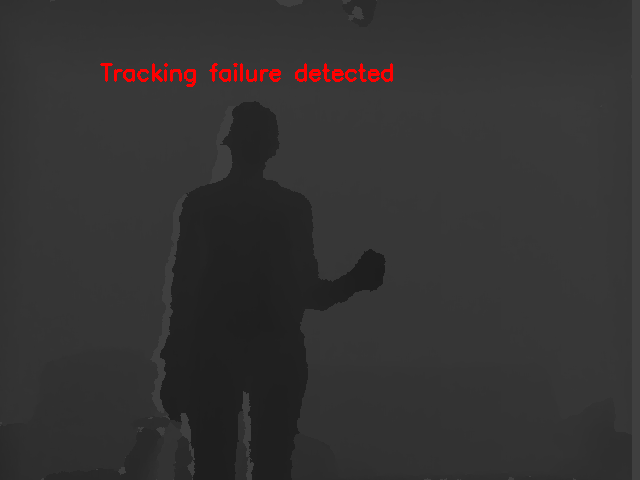

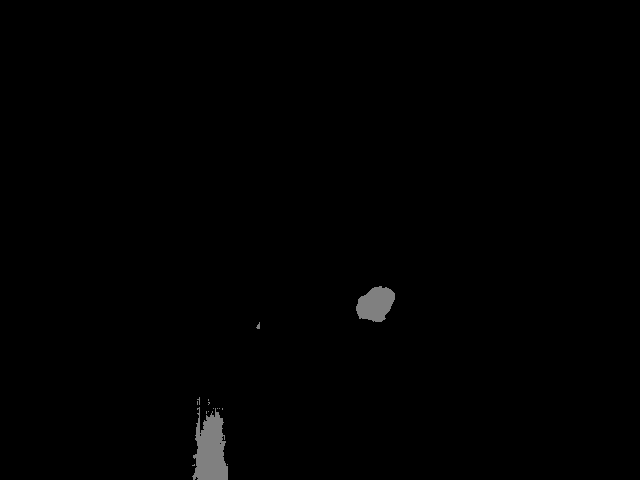

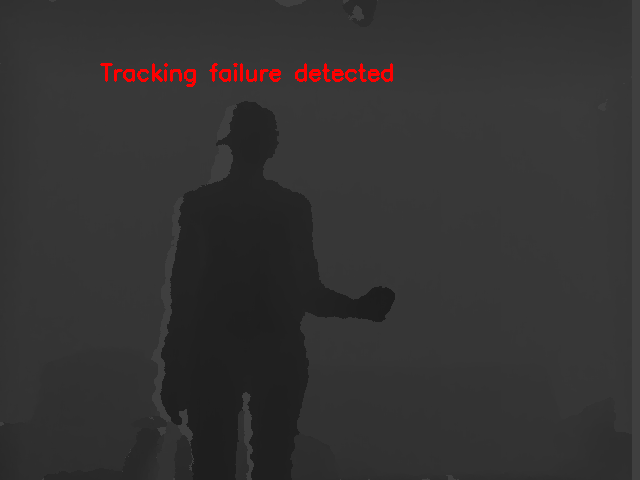

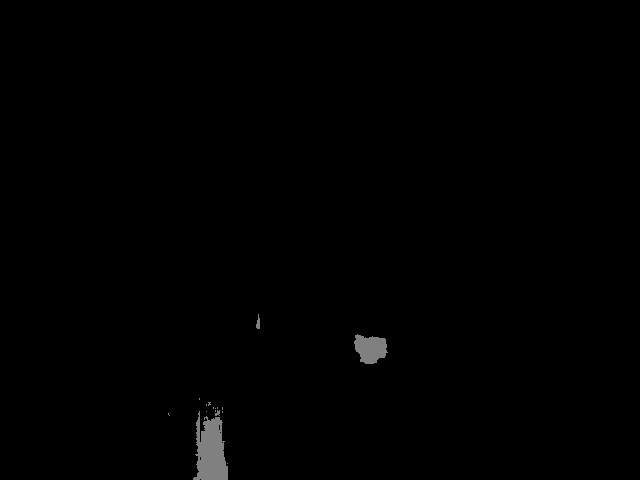

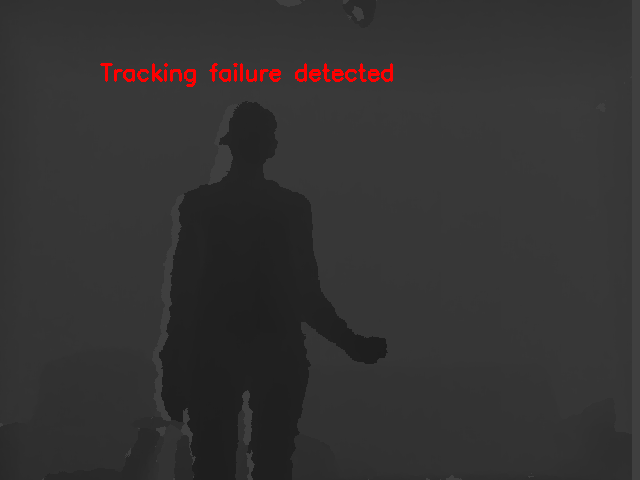

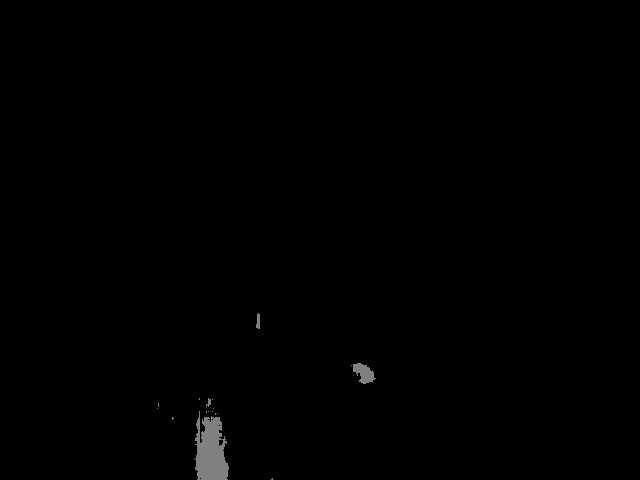

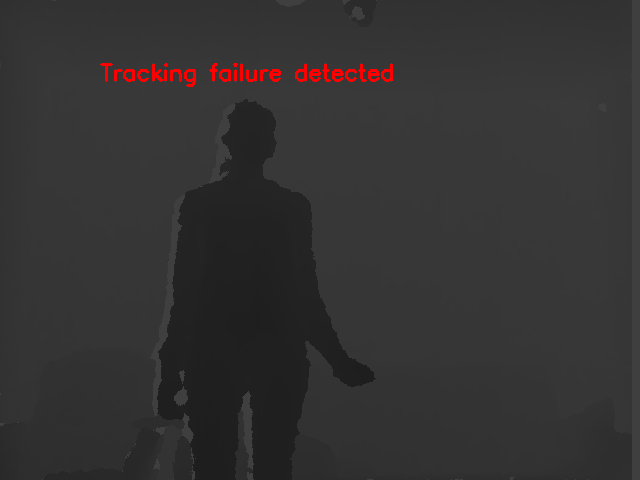

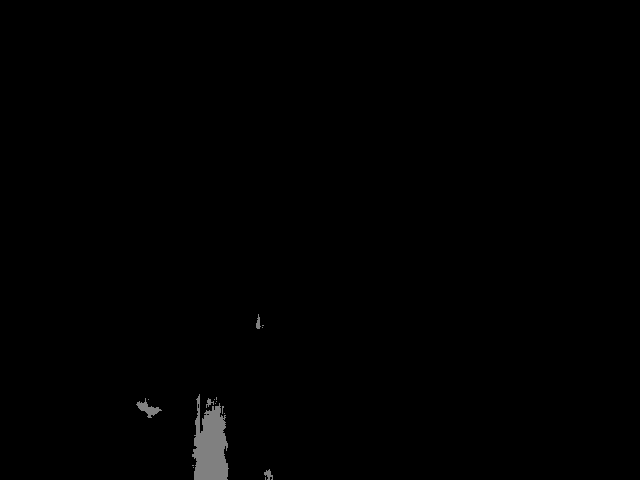

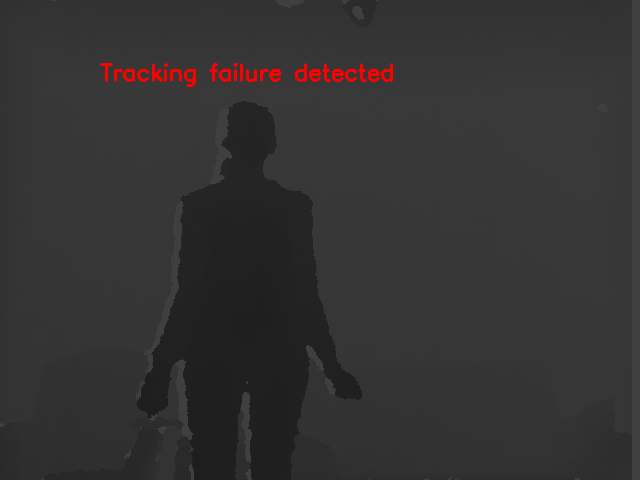

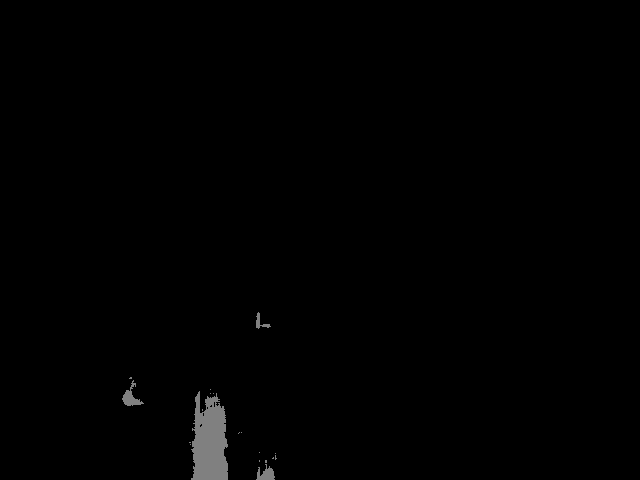

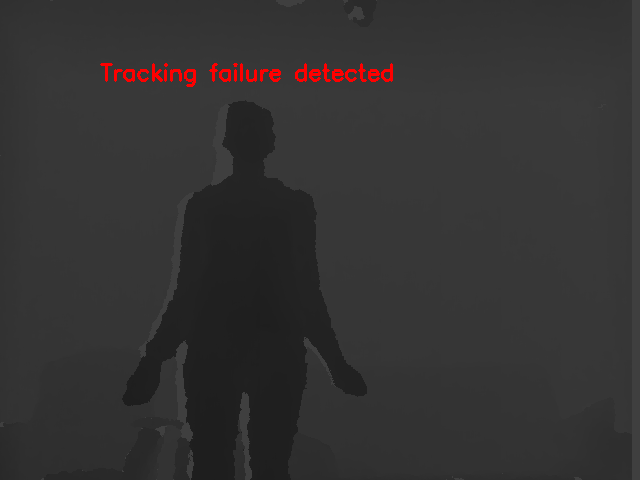

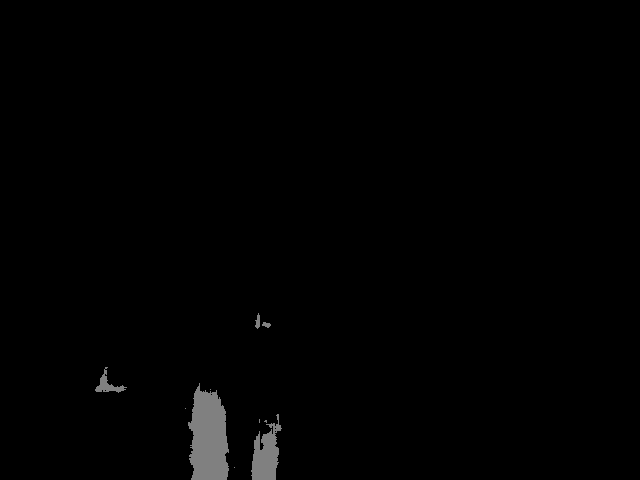

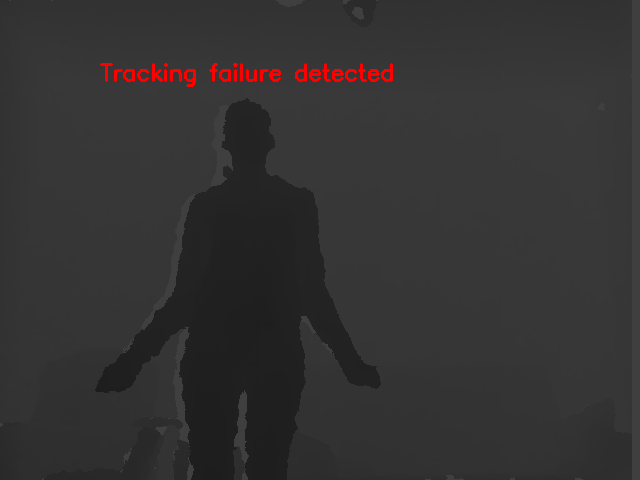

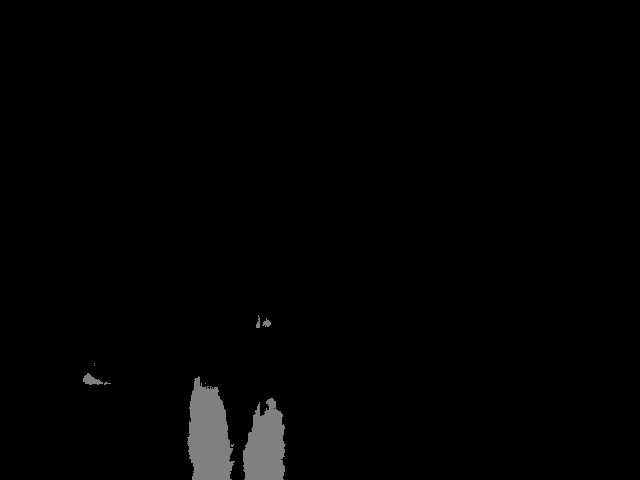

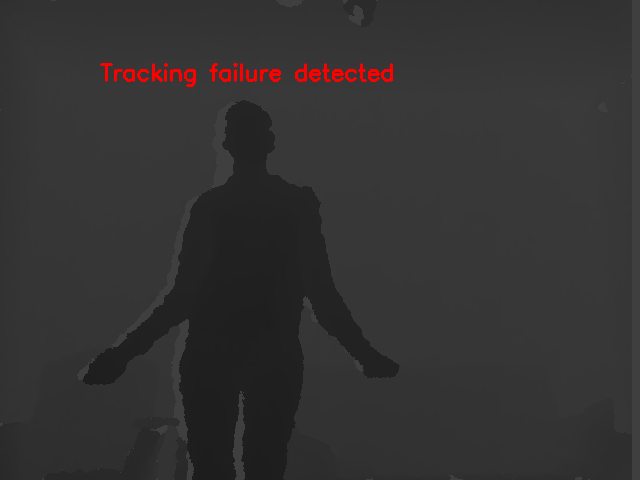

In [189]:
color = gray.copy()
boundRect = cv2.boundingRect(max_contour)
cv2.rectangle(color, (int(boundRect[0]), int(boundRect[1])),(int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), (255,255,0),2)

tracker = cv2.TrackerMedianFlow_create()
tracker.init(gray_copy, boundRect)

cv2_imshow(gray_copy)

for a in range(1000):
  frameLoaded, frame = cap.read()
  if not frameLoaded:
    break
  
  np.clip(frame, 0, 2**10-1, frame)
  frame >>= 2
  frame = frame.astype(np.uint8)   
  
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  gray_copy = gray.copy()
  
  gray_copy = np.where(((gray_copy <= 30) & (gray_copy >= 10)), 128, 0)
  gray_copy = gray_copy.astype('uint8')
  cv2_imshow(gray_copy)
  trackerUpdated, boundRect = tracker.update(gray_copy)
  if trackerUpdated:
  # Tracking success
    p1 = (int(boundRect[0]), int(boundRect[1]))
    p2 = (int(boundRect[0] + boundRect[2]), int(boundRect[1] + boundRect[3]))
    cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
    cv2.circle(frame, ((p1[0]+p2[0])//2, (p1[1]+p2[1])//2), 3, (0, 0, 255), -1)
    cv2.putText(frame, str(a), (20,20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
  else :
    # Tracking failure
    cv2.putText(frame, "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
  cv2_imshow(frame)

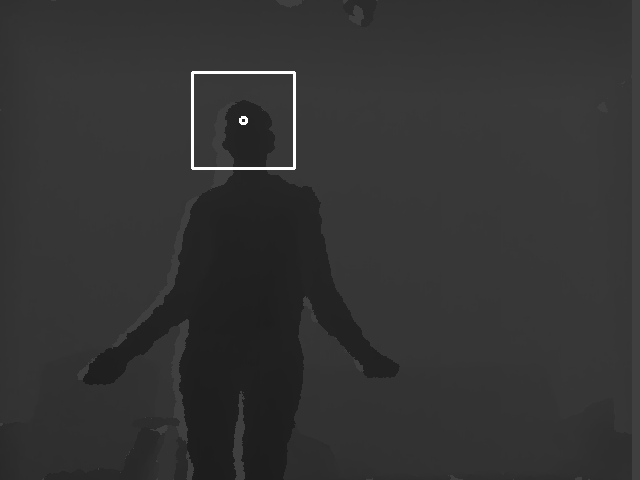

In [190]:
#color = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
color = gray.copy()



cv2.circle(color, (int((x1+x2) /2), int((y1+y2)/2)), 3, [255, 102, 0], 2)
cv2.rectangle(color, (x1, y1), (x2, y2), [255, 102, 0], 2)

cv2_imshow(color)
cap.release()